### DataDivas
Takımımız 3 kişiden oluşuyor.

* Sude Naz Öztürk
* Miray İnci Başaran
* Nisa Çiko

In [ ]:
# Gerekli kütüphaneler import edildi.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

from sklearn.metrics import r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf

# Aşama 1: Veri Keşfi ve Ön İşleme


In [513]:
# Kullanılacak Fonksiyonlar

def tekrar_eden_id_kontrolu(df):
    customer_counts = df["customer id"].value_counts()
    tekrar_edenler = customer_counts[customer_counts>1]
    print(tekrar_edenler)

def outlier_finder(feature):
    outliers_of_feature = []
    Q1 = merged_df[feature].quantile(0.25)
    Q3 = merged_df[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = merged_df[(merged_df[feature] < lower) | (merged_df[feature] > upper)]
    outliers_of_feature.extend(outliers.index)

    return outliers_of_feature

def outlier_finder_cat(feature):
    outliers_of_feature = []
    counts = merged_df[feature].value_counts()

    outlier_categories = counts[counts < lower_threshold].index

    outliers = merged_df[merged_df[feature].isin(outlier_categories)].index
    outliers_of_feature.extend(outliers)

    return outliers_of_feature

def fill_missing_values(df, target_col):
    train_data = df.dropna(subset=[target_col])
    test_data = df[df[target_col].isna()]

    if test_data.empty:
        return df
    feature_cols = [col for col in df.columns if col not in [target_col, "customer id", "response date"]]

    model = RandomForestRegressor(n_estimators=100, random_state=25)
    model.fit(train_data[feature_cols], train_data[target_col])

    train_predictions = model.predict(train_data[feature_cols]) # model skoru
    r2 = r2_score(train_data[target_col], train_predictions)

    predicted_values = model.predict(test_data[feature_cols])
    df.loc[df[target_col].isna(), target_col] = np.round(predicted_values).astype(int)

    print(f"R² skoru ({target_col}): {r2:.3f}")
    return df

def replace_outliers_with_median(df, column):
    outliers = outlier_finder(column)
    median_value = df[column].median()
    df.loc[outliers, column] = median_value




### Dosyaları görüntüleme ve inceleme

In [514]:
df_age = pd.read_csv('data/Customer_Age_Data.csv')
df_age = df_age.rename(columns={'CRM ID': 'Customer ID'}) 
# Tüm diğer df'lerde customer id olarak verilmiş, aynı olması için değiştirdik
df_age.head()

Customer ID  Customer Age (Months)
0  CRM-1471650                     24
1  CRM-1516050                     13
2  CRM-1087300                     25
3  CRM-1467150                     12
4   CRM-230550                     12

In [515]:
df_help_ticket = pd.read_csv('data/Help_Ticket_Data.csv')
df_help_ticket.head()

#Help Ticket Count: 
# Müşterinin, müşteri destek ekibinden yardım almak için oluşturduğu toplam talep sayısını gösterir.
#Help Ticket Lead Time(hours): 
# İlgili müşteri tarafından oluşturulan taleplerin ortalama çözüm süresini gösterir.

Customer ID  Help Ticket Count  Help Ticket Lead Time (hours)
0  CRM-1516050                  9                            418
1  CRM-1467150                  8                            382
2  CRM-1470950                 30                            366
3  CRM-1526100                  4                           1206
4  CRM-1506400                 22                            484

In [516]:
df_mrr = pd.read_csv('data/Customer_MRR_Data.csv')
df_mrr.head()

#MRR: 
#Müşterinin E-corp’a aylık olarak ödediği para miktarını gösterir.
#Amaçlarımızdan biri bu değeri arttırmak.

Customer ID     MRR
0  CRM-5454800  $8,212
1  CRM-5479950  $2,026
2  CRM-5494800  $2,100
3  CRM-5598450  $2,900
4  CRM-5602550  $1,898

In [517]:
df_status = pd.read_csv('data/StatusAndLevel_Data.csv')
df_status.head()

#Status: 
#Müşterinin satış sürecindeki mevcut durumunu gösterir.

Customer ID      Status   Customer Level
0  CRM-1471650  Onboarding       Enterprise
1  CRM-1516050  Onboarding        Long-tail
2  CRM-1087300       Churn  Semi-Enterprise
3  CRM-1467150       Churn  Semi-Enterprise
4   CRM-230550       Churn        Long-tail

In [518]:
df_newsletter = pd.read_csv('data/Newsletter_Interaction_Data.csv')
df_newsletter.head()

#Company Newsletter Interaction Count: 
#Müşterinin, E-corp tarafından gönderilen bültenlerle kaç kez etkileşime geçtiğini gösterir.


Customer ID  Company Newsletter Interaction Count
0   CRM-160150                                    54
1   CRM-166800                                    27
2   CRM-927200                                    24
3  CRM-1526050                                    23
4  CRM-1489600                                    20

In [519]:
df_region = pd.read_csv('data/RegionAndVertical_Data.csv')
df_region.head()

Customer ID     Region                      Vertical  \
0  CRM-1471650   Malaysia          Media and Publishing   
1  CRM-1516050     Taiwan                        Retail   
2  CRM-1087300  Australia  Transportation and Logistics   
3  CRM-1467150     Taiwan                        Retail   
4   CRM-230550     Turkey                        Retail   

                    Subvertical  
0              Content Websites  
1              Fashion Retailer  
2  Transportation and Logistics  
3                   Marketplace  
4              Fashion Retailer

In [520]:
df_product_bug = pd.read_csv('data/Product_Bug_Task_Data.csv')
df_product_bug.head()

Customer ID  Product Bug Task Count
0  CRM-1526150                     179
1  CRM-1477300                     150
2  CRM-1450300                      66
3   CRM-661350                     116
4  CRM-1435450                     106

In [521]:
df_survey = pd.read_csv('data/CSAT_Survey_Data.csv')
df_survey.head()


Customer ID  Year  Quarter Survey Date Response Date  \
0  CRM-1516050  2022        3  2022-07-01    2022-08-26   
1  CRM-1516050  2022        3  2022-07-01    2022-09-27   
2  CRM-1470950  2022        1  2022-01-01    2022-03-25   
3  CRM-1470950  2022        3  2022-07-01    2022-09-30   
4  CRM-1470950  2022        2  2022-04-01    2022-06-23   

   How likely are you to recommend insider to a friend or colleague   \
0                                                 10                   
1                                                 10                   
2                                                  4                   
3                                                  6                   
4                                                 10                   

   How would you rate the value you gain from our company  \
0                                                  5        
1                                                  5        
2                                                  3        
3                                                  3        
4                                                  5        

  How frequently are you using our platform  \
0                              Once a Month   
1                              Once a Month   
2                                Once a Day   
3                               Once a Week   
4                                Once a Day   

   Please rate the overall quality of our products  \
0                                                5   
1                                                5   
2                                                2   
3                                                4   
4                                                4   

   Please rate the usability of the panel  \
0                                     5.0   
1                                     5.0   
2                                     3.0   
3                                     4.0   
4                                     3.0   

  Please rate your understanding of our reporting capabilities in the panel  
0  I need someone from Insider team to provide me...                         
1                               I don't use it often                         
2  I need someone from Insider team to provide me...                         
3       I tried but could not find everything I need                         
4  I need someone from Insider team to provide me...

In [522]:
df_revenue= pd.read_csv('data/Customer_Revenue_Data.csv')
df_revenue.head()

#Total Revenue: 
#Müşterinin, E-corp ürünlerini kullanarak elde ettiği toplam gelir miktarını gösterir.

Customer ID Total Revenue
0  CRM-1470950      $732,199
1  CRM-1526100            $0
2  CRM-1506400      $375,135
3  CRM-1430550            $0
4  CRM-1485600      $116,732

In [523]:
dataframes = [df_survey,df_age,df_help_ticket,df_mrr,df_status,df_newsletter,df_region,df_product_bug,df_revenue ]

### Data tiplerini inceleme

In [524]:
for df in dataframes:
    print(df.dtypes)
    print("-------------------------------------")

Customer ID                                                                   object
Year                                                                           int64
Quarter                                                                        int64
Survey Date                                                                   object
Response Date                                                                 object
How likely are you to recommend insider to a friend or colleague               int64
How would you rate the value you gain from our company                         int64
How frequently are you using our platform                                     object
Please rate the overall quality of our products                                int64
Please rate the usability of the panel                                       float64
Please rate your understanding of our reporting capabilities in the panel     object
dtype: object
-------------------------------------
Customer ID  

### Tekrarlı verileri silme (duplicates)

In [525]:
for df in dataframes:
    df = df.drop_duplicates() 
    # tekrar eden satırlar silinir

### Normalize etme

In [526]:
for df in dataframes:
    df.columns = df.columns.str.strip().str.lower() # column adlarındaki boşlukları kaldır, küçük harf yap
    df['customer id'] = df['customer id'].str.replace(r'\s+', '', regex=True)
    df['customer id'] = df['customer id'].str.replace(r'[^A-Za-z0-9]', '', regex=True)  # CRM-3297983 -> CRM3297983


    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.strip()

    print(df.columns)
    print("Satır sayısı:", df.shape[0]) # satır sayılarını da inceleme amaçlı yazdırıyoruz.
    print("-----------------------------------------------------------------------------")



Index(['customer id', 'year', 'quarter', 'survey date', 'response date',
       'how likely are you to recommend insider to a friend or colleague',
       'how would you rate the value you gain from our company',
       'how frequently are you using our platform',
       'please rate the overall quality of our products',
       'please rate the usability of the panel',
       'please rate your understanding of our reporting capabilities in the panel'],
      dtype='object')
Satır sayısı: 1989
-----------------------------------------------------------------------------
Index(['customer id', 'customer age (months)'], dtype='object')
Satır sayısı: 2651
-----------------------------------------------------------------------------
Index(['customer id', 'help ticket count', 'help ticket lead time (hours)'], dtype='object')
Satır sayısı: 1367
-----------------------------------------------------------------------------
Index(['customer id', 'mrr'], dtype='object')
Satır sayısı: 1380
--------

### Column ismi düzenleme, gereksiz satır ve NaN temizliği

In [527]:
# Uzun sütun isimlerini işlevsellik açısından değiştiriyoruz

df_survey = df_survey.rename(columns={"how likely are you to recommend insider to a friend or colleague": "recommend_score"})
df_survey = df_survey.rename(columns={'how would you rate the value you gain from our company': "gain_score"})
df_survey = df_survey.rename(columns={'how frequently are you using our platform': "using_frequency"})
df_survey = df_survey.rename(columns={'please rate the overall quality of our products': "product_quality"})
df_survey = df_survey.rename(columns={'please rate the usability of the panel': "panel_usability"})
df_survey = df_survey.rename(columns={'please rate your understanding of our reporting capabilities in the panel': "panel_comment"})


In [528]:
# Bazı sütunlardaki az sayıda olan NaN değerleri siliyoruz, gereksiz görüdüğümüz sütunları da siliyoruz.

df_status = df_status.dropna(subset=["customer id"])
df_region = df_region.dropna(subset=["customer id"])
df_region = df_region.dropna(subset=["region"])
df_survey = df_survey.dropna(subset=["using_frequency"])
df_survey = df_survey.dropna(subset=["panel_usability"])
df_region = df_region.drop(columns=['subvertical']) # gereksiz
df_survey = df_survey.drop(columns=['year', 'quarter','survey date']) # gereksiz


### NaN değer kontrolü

In [529]:
warnings.filterwarnings("ignore", category=UserWarning)
for df in dataframes:
    print(df.isnull().sum())
    print("--------------------------------------------------------------------------")

customer id                                                                   0
year                                                                          0
quarter                                                                       0
survey date                                                                   0
response date                                                                 0
how likely are you to recommend insider to a friend or colleague              0
how would you rate the value you gain from our company                        0
how frequently are you using our platform                                     3
please rate the overall quality of our products                               0
please rate the usability of the panel                                       64
please rate your understanding of our reporting capabilities in the panel     0
dtype: int64
--------------------------------------------------------------------------
customer id              0
custo

In [530]:
# farklı cevapları gösteriyoruz

answers1 = df_age["customer age (months)"].unique()
print(answers1)
print("------------------------------------------------")
answers2 = df_help_ticket["help ticket count"].unique()
print(answers2)
print("------------------------------------------------")
answers3 = df_help_ticket["help ticket lead time (hours)"].unique()
print(answers3)
print("------------------------------------------------")
answers4 = df_mrr["mrr"].unique()
print(answers4)
print("------------------------------------------------")
answers5 = df_status["status"].unique()
print(answers5)
print("------------------------------------------------")
answers6 = df_status["customer level"].unique()
print(answers6)
print("------------------------------------------------")
answers7 = df_newsletter["company newsletter interaction count"].unique()
print(answers7)
print("------------------------------------------------")
answers8 = df_region["region"].unique()
print(answers8)
print("------------------------------------------------")
answers9 = df_region["vertical"].unique()
print(answers9)
print("------------------------------------------------")
answers10 = df_product_bug['product bug task count'].unique()
print(answers10)
print("------------------------------------------------")
answers11 = df_survey['recommend_score'].unique()
print(answers11)
print("------------------------------------------------")
answers12 = df_survey['gain_score'].unique()
print(answers12)
print("------------------------------------------------")
answers13 = df_survey['using_frequency'].unique()
print(answers13)
print("------------------------------------------------")
answers14 = df_survey['product_quality'].unique()
print(answers14)
print("------------------------------------------------")
answers15 = df_survey['panel_usability'].unique()
print(answers15)
print("------------------------------------------------")
answers16 = df_survey['panel_comment'].unique()
print(answers16)
print("------------------------------------------------")


[24 13 25 12 22 11 28  7 70 14 30 20 50 19 29  3  6 16 17 32  4 15 55 10
 26 38 72 18 42 39  8 36 69 49 34 44 27  9 40 21 43 54 31  5  2 53 41 48
 37 57 47  1 23 45 35 63 58 56 52 46 60 71 51 68 65 67 59 33 62 61 66 64]
------------------------------------------------
[  9   8  30   4  22   7   3  14   2  12   1  13  21  23  10 443  52  42
   5   6  24  11  72  38  32  36  20  33  17  15  16  25  47  34  57  64
  46  35  29  44  61 112  31  82  74  70  28  71  68  62  65  66  59  55
  40  53  89  26  86  37  84  27  51  39 104  63  41  54  18  49  96 114
  98  19  78  76 100 139  77  83  48 186  45  90 121 188 113 127  67 111
  56  43  50  69 277  85  88 101  94 110]
------------------------------------------------
[  418   382   366  1206   484   486   467   381  1223   952   946   574
   737  1811   918   272   630   356   535   981   417   444  1393   130
  1016   443   742   406   521   844   635   986   929   511   110    91
  2480   792   180   461   434   536   552  2221  1240  

In [531]:
for df in dataframes:
    tekrar_eden_id_kontrolu(df)
    print("-----------------------------------------------------")

# df survey ve df product bug'da tekrar eden customer id'ler var.

customer id
CRM1486150    12
CRM1438700    10
CRM164850     10
CRM1482200    10
CRM1455200    10
              ..
CRM812200      2
CRM1503300     2
CRM927700      2
CRM1436600     2
CRM378850      2
Name: count, Length: 490, dtype: int64
-----------------------------------------------------
Series([], Name: count, dtype: int64)
-----------------------------------------------------
Series([], Name: count, dtype: int64)
-----------------------------------------------------
Series([], Name: count, dtype: int64)
-----------------------------------------------------
Series([], Name: count, dtype: int64)
-----------------------------------------------------
Series([], Name: count, dtype: int64)
-----------------------------------------------------
Series([], Name: count, dtype: int64)
-----------------------------------------------------
customer id
CRM1486150    12
CRM1438700    10
CRM1473700    10
CRM1455200    10
CRM1482200    10
              ..
CRM1521150     2
CRM1506200     2
CRM15160

In [532]:
print(df_product_bug.shape[0])

df_product_bug = df_product_bug.groupby("customer id", as_index=False)["product bug task count"].mean()

# bu df için bir müşterinin farklı zamanlardaki bug sayıları bize anlma ifade etmiyor çünkü zaman belirteci yok. önceden neymiş ne olmuş karşılaştırması yapamayacağımız için her müşteri için bulunan product bugların ortalamsını alıyoruz.


1989


### Encoding

In [533]:
# Columnlardaki string değerleri numerical değerlere dönüştürüyoruz.

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
# ilerideki kodda sıkıntı yaratmayan kopya listeye yazdığına dair bir uyarı veriyordu, onu kapattık.

df_survey['panel_comment'] = df_survey['panel_comment'].map({
    'I need someone from Insider team to provide me the report from the panel': 1, # anlamamış
    "I don't use it often": 0, # kötü: kullanmıyor
    'I tried but could not find everything I need': 0,
    'I am able to report everything easily': 2, # iyi: kullanıyor
    "I can pull all the numbers, but don't understand them": 1 # anlamamış
})


df_survey['using_frequency'] = df_survey['using_frequency'].map({
    'Once a Month': 0,
    "Once a Week": 1,
    'Once a Day': 2,
})


df_status['converted_status'] =df_status['status'].map({
  'Churn': 0, # en kötü: kaybedilmiş
  "Retained": 2, # en iyi: aktif müşteri
  'Onboarding': 2,
  'Incomplete Deal':1, # kayıt aşamasında, beklemede müşteri
  'Contract Confirmation':1,
  'In Opportunity Pipeline':1,
  'PoC':1
})
#poc silinmezse onu da eklememiz gerekecek

df_status['converted_customer_level'] =df_status['customer level'].map({
  'Enterprise': 2,
  "Long-tail": 0,
  'Semi-Enterprise': 1,
})

df_region['converted_region'] = df_region['region'].map({
    # Avrupa
    "Turkey": 0,
    "United Kingdom": 0,
    "Russia": 0,
    "France": 0,
    "Spain": 0,
    "Benelux": 0,
    "CEE": 0,

    # Asya
    "Taiwan": 1,
    "Vietnam": 1,
    "Indonesia": 1,
    "Malaysia": 1,
    "Singapore": 1,
    "Korea": 1,
    "Thailand": 1,
    "Japan": 1,
    "Hong Kong": 1,
    "Philippines": 1,

    # Amerika Kıtası
    "Brazil": 2,
    "United States": 2,
    "Mexico": 2,
    "South Cone": 2,

    # Orta Doğu & Afrika
    "MENA": 3,
    "Australia": 3,
})

df_region['converted_vertical'] = df_region['vertical'].map({
    # Teknoloji & Dijital
    "Internet and Telecom": 0,
    "B2B SaaS": 0,
    "Consumer Electronics": 0,
    "Gaming": 0,
    "Comparison": 0,

    # Finans & Ticaret
    "Finance": 1,
    "B2B Commerce": 1,
    "Real Estate": 1,
    "Financial Services": 1,
    "Ebetting and Lottery": 1,

    # Ulaşım & Lojistik & Seyahat
    "Travel": 2,
    "Transportation and Logistics": 2,
    "Automotive": 2,
    "Retail": 2,

    # Sağlık & Eğitim & Medya
    "Healthcare": 3,
    "Career and Education": 3,
    "Media and Publishing": 3,
    "Non Profit Organizations": 3,

    # Diğer
    "Restaurants and Delivery": 4,
    "Classifieds": 4,
    "Fashion": 4,
    "Other": 4,
})
# Drop the original column
df_status.drop('status', axis=1, inplace=True)
df_status.drop('customer level', axis=1, inplace=True)
df_region.drop('region', axis=1, inplace=True)
df_region.drop('vertical', axis=1, inplace=True)



### Birleştirme işlemi

In [534]:
merged_df = pd.merge(df_survey, df_age, on='customer id', how='outer')
merged_df = pd.merge(merged_df, df_status, on='customer id', how='outer')
merged_df = pd.merge(merged_df, df_help_ticket, on='customer id', how='outer')
merged_df = pd.merge(merged_df, df_mrr, on='customer id', how='outer')
merged_df = pd.merge(merged_df, df_newsletter, on='customer id', how='outer')
merged_df = pd.merge(merged_df, df_product_bug, on='customer id', how='outer')
merged_df = pd.merge(merged_df, df_revenue, on='customer id', how='outer')
merged_df = pd.merge(merged_df, df_region, on='customer id', how='outer')
# Customer id'ler üzerinden birleştirme yaptığımız için 'outer' kullandık. Sadece kesişim id'leri içermeyecek, tüm id'leri toplayacak.

merged_df
# Totalde 4000'e yakın satır içeren bir dataset elde ettik.


customer id response date  recommend_score  gain_score  using_frequency  \
0     CRM1002400    2022-06-10              8.0         4.0              0.0   
1     CRM1002400    2022-09-29             10.0         4.0              0.0   
2     CRM1005900           NaN              NaN         NaN              NaN   
3     CRM1006000           NaN              NaN         NaN              NaN   
4     CRM1010150           NaN              NaN         NaN              NaN   
...          ...           ...              ...         ...              ...   
3984   CRM998550           NaN              NaN         NaN              NaN   
3985   CRM998800    2022-03-01              8.0         4.0              2.0   
3986   CRM998800    2022-07-05              8.0         4.0              1.0   
3987   CRM999900    2022-09-30              8.0         4.0              2.0   
3988   CRM999900    2022-06-29              8.0         3.0              2.0   

      product_quality  panel_usability  panel_comment  customer age (months)  \
0                 4.0              3.0            1.0                   39.0   
1                 3.0              3.0            1.0                   39.0   
2                 NaN              NaN            NaN                   36.0   
3                 NaN              NaN            NaN                   38.0   
4                 NaN              NaN            NaN                   38.0   
...               ...              ...            ...                    ...   
3984              NaN              NaN            NaN                    6.0   
3985              3.0              3.0            2.0                   50.0   
3986              4.0              4.0            1.0                   50.0   
3987              4.0              5.0            2.0                   40.0   
3988              4.0              4.0            0.0                   40.0   

      converted_status  converted_customer_level  help ticket count  \
0                  2.0                       2.0               55.0   
1                  2.0                       2.0               55.0   
2                  2.0                       2.0                4.0   
3                  2.0                       1.0                1.0   
4                  2.0                       0.0                5.0   
...                ...                       ...                ...   
3984               0.0                       0.0                NaN   
3985               2.0                       2.0              139.0   
3986               2.0                       2.0              139.0   
3987               2.0                       1.0               35.0   
3988               2.0                       1.0               35.0   

      help ticket lead time (hours)      mrr  \
0                             701.0   $6,716   
1                             701.0   $6,716   
2                            2709.0  $29,012   
3                            1789.0   $3,257   
4                             785.0     $679   
...                             ...      ...   
3984                            NaN      NaN   
3985                          516.0     $411   
3986                          516.0     $411   
3987                          747.0   $3,889   
3988                          747.0   $3,889   

      company newsletter interaction count  product bug task count  \
0                                      NaN              141.500000   
1                                      NaN              141.500000   
2                                      NaN                     NaN   
3                                      NaN              133.000000   
4                                      1.0                     NaN   
...                                    ...                     ...   
3984                                   NaN                     NaN   
3985                                   NaN              140.333333   
3986                   

In [535]:
tekrar_eden_id_kontrolu(merged_df)
# Tekrar eden customer id'lerde, birleşim yaptıktan sonra sıkıntı yaşanmış mı diye kontrol ediyoruz. Bir sıkıntı yok aynı şekilde kalmış.

customer id
CRM1455200    10
CRM1482200    10
CRM1450750    10
CRM1473700    10
CRM1486150    10
              ..
CRM1450300     2
CRM1378600     2
CRM1447100     2
CRM1446950     2
CRM1443150     2
Name: count, Length: 477, dtype: int64


In [536]:
merged_df = merged_df.dropna(axis=1, how='all')  # Tüm satırları NaN olan sütunları siler
merged_df= merged_df.drop_duplicates()

In [537]:
print( merged_df.isnull().sum())
# Çok sayıda NaN değerimiz var bunların üstesinden gelme işlemini ilerde gerçekleştireceğiz.

customer id                                0
response date                           2067
recommend_score                         2067
gain_score                              2067
using_frequency                         2067
product_quality                         2067
panel_usability                         2067
panel_comment                           2067
customer age (months)                     52
converted_status                          52
converted_customer_level                  53
help ticket count                       1428
help ticket lead time (hours)           1428
mrr                                     1378
company newsletter interaction count    3415
product bug task count                  2061
total revenue                           2003
converted_region                          53
converted_vertical                       120
dtype: int64


In [538]:
# Total revenue ve mrr verilerinin başındaki dolar işareti temizlendi.
merged_df["mrr"] = merged_df["mrr"].astype(str).str.replace(r'^\$', '', regex=True)
merged_df["mrr"] = pd.to_numeric(merged_df["mrr"], errors='coerce')  # Sayısal forma çevir

merged_df["total revenue"] = merged_df["total revenue"].astype(str).str.replace(r'^\$', '', regex=True)
merged_df["total revenue"] = pd.to_numeric(merged_df["total revenue"], errors='coerce')  # Sayısal forma çevir


### Numeric outlier tespiti ve üstesinden gelme

In [539]:
# Burada outlier'ları belirlemek için IQR methodu kullanıyoruz.
# IQR için başlarda tanımladığımız fonksiyonu kullandık.

numerical_outliers = []
numerical_col = ['mrr','total revenue','customer age (months)','help ticket lead time (hours)','help ticket count','product bug task count', 'company newsletter interaction count']

for col in numerical_col:
    outliers = outlier_finder(col)
    print("Number of outlier in", col, " feature: ", len(outliers))
    numerical_outliers.extend(outliers)

# Aynı satırları sil
numerical_outliers = list(set(numerical_outliers))

numerical_outliers.sort()

print("Number of numerical outliers: ",len(numerical_outliers))



Number of outlier in mrr  feature:  0
Number of outlier in total revenue  feature:  95
Number of outlier in customer age (months)  feature:  118
Number of outlier in help ticket lead time (hours)  feature:  133
Number of outlier in help ticket count  feature:  168
Number of outlier in product bug task count  feature:  44
Number of outlier in company newsletter interaction count  feature:  63
Number of numerical outliers:  562


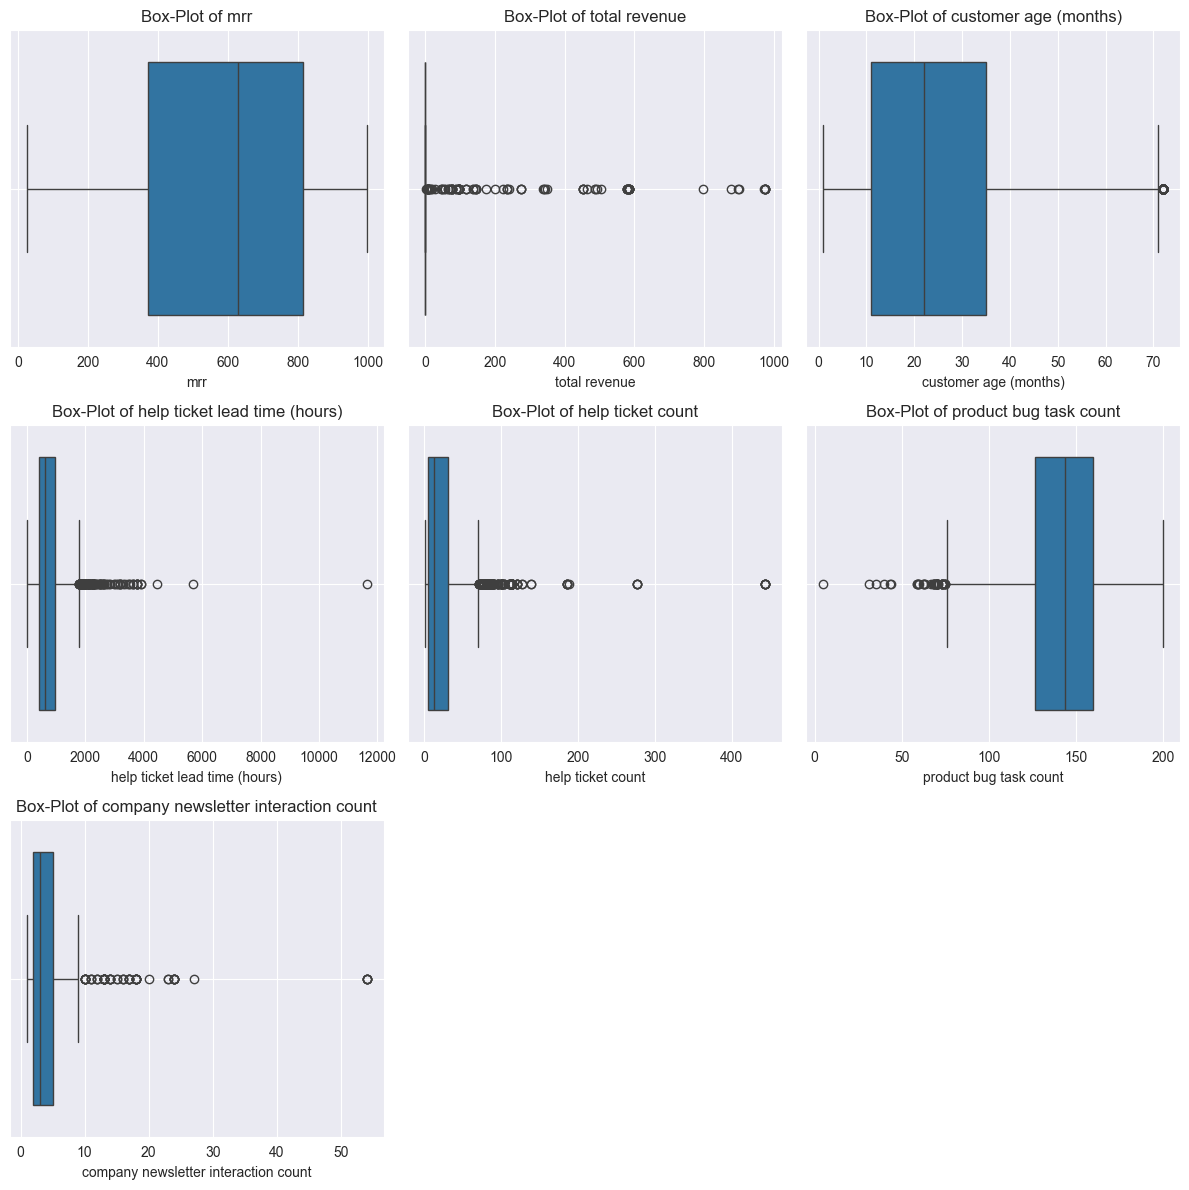

In [540]:
# Outlier'ları box-plot ile görselleştiriyoruz.

rows, cols = 3,3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 4, rows * 4))

for i, column in enumerate(numerical_col):
    row, col = divmod(i, cols)
    sns.boxplot(x=merged_df[column], ax=axes[row, col])
    axes[row, col].set_title(f'Box-Plot of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].grid(True)

fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])
plt.tight_layout()
plt.show()


Numerical columnlar için outlierları belirledik ve box-plot ile görselleştirmelerini yapıp daha net bir şekilde görebildik. MRR ve Total Revenue gibi hedef değişkenlerimiz için outlierları silmeyeceğiz veya değiştirmeyeceğiz çünkü analizi etkileyebilir ama diğerlerini analizde saptırma yapmamaları için dağılımlarını inceledikten sonra uygun şekilde dolduracağız.

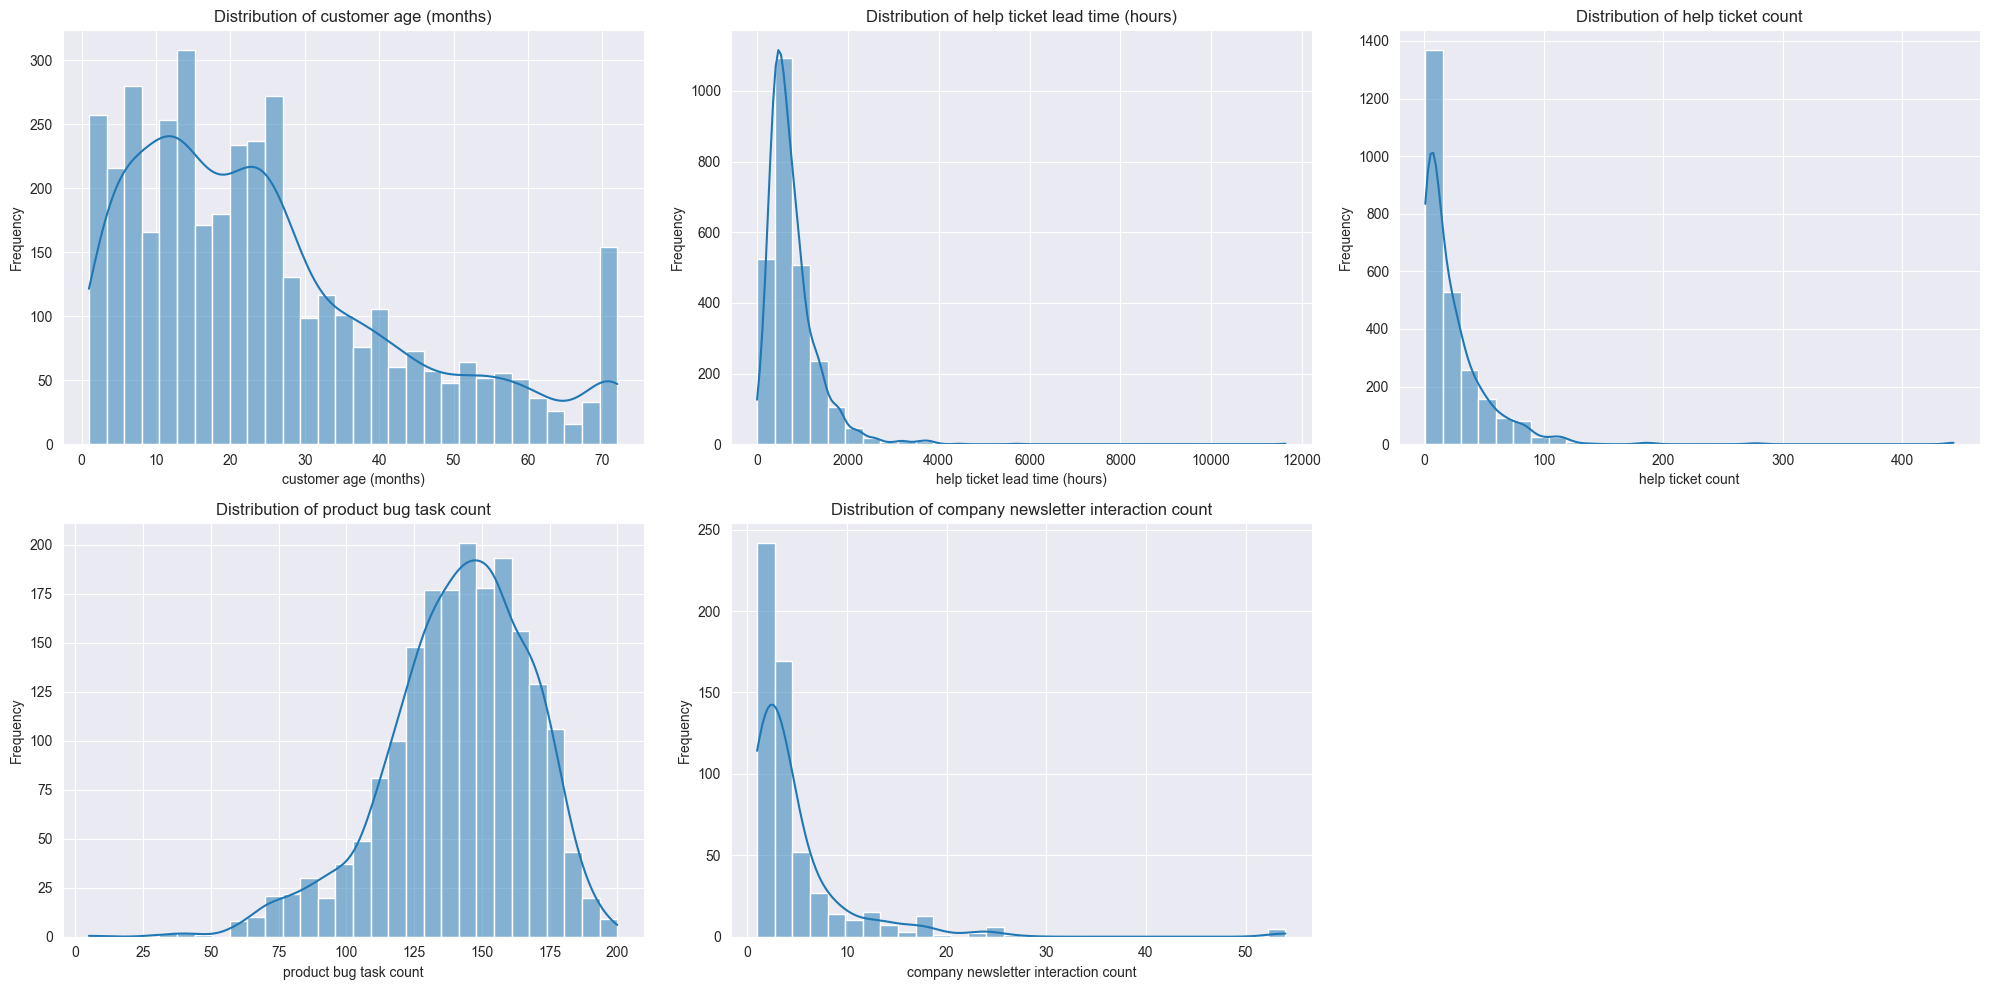

In [541]:
selected_col = ['customer age (months)', 'help ticket lead time (hours)',
                'help ticket count', 'product bug task count', 'company newsletter interaction count']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i, column in enumerate(selected_col[:3]):
    sns.histplot(merged_df[column], kde=True, bins=30, ax=axes[0, i])
    axes[0, i].set_title(f'Distribution of {column}')
    axes[0, i].set_xlabel(column)
    axes[0, i].set_ylabel('Frequency')

for i, column in enumerate(selected_col[3:]):
    sns.histplot(merged_df[column], kde=True, bins=30, ax=axes[1, i])
    axes[1, i].set_title(f'Distribution of {column}')
    axes[1, i].set_xlabel(column)
    axes[1, i].set_ylabel('Frequency')

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()


* Customer age grafiği sağa çarpık bir grafik, 50 ay ve üstü müşteri sayısı oldukça az. Çarpık bir dağılım olduğundan median ile doldurmak mantıklı olacak.
* Help ticket lead time grafiği aşırı sağa çarpık, çok büyük outlier’lar var. Median ile doldurulacak.
* Help ticket Count sağa çarpık bir grafik. Median ile doldurulacak.
* Product Bug Task Count neredeyse normal bir dağılıma sahip median ile doldurulacak.(mean denendi, median daha iyi sonuç veriyor)
* Company Newsletter Interaction Count grafiği sağa çarpık. Median ile dolduracağız.

Beş durumda da, normal olmayan, çoğunlukla sağa çarpık dağılımlar ve potansiyel aykırı değerler var.
Medyan ile doldurmak en uygun strateji gibi görünmektedir.

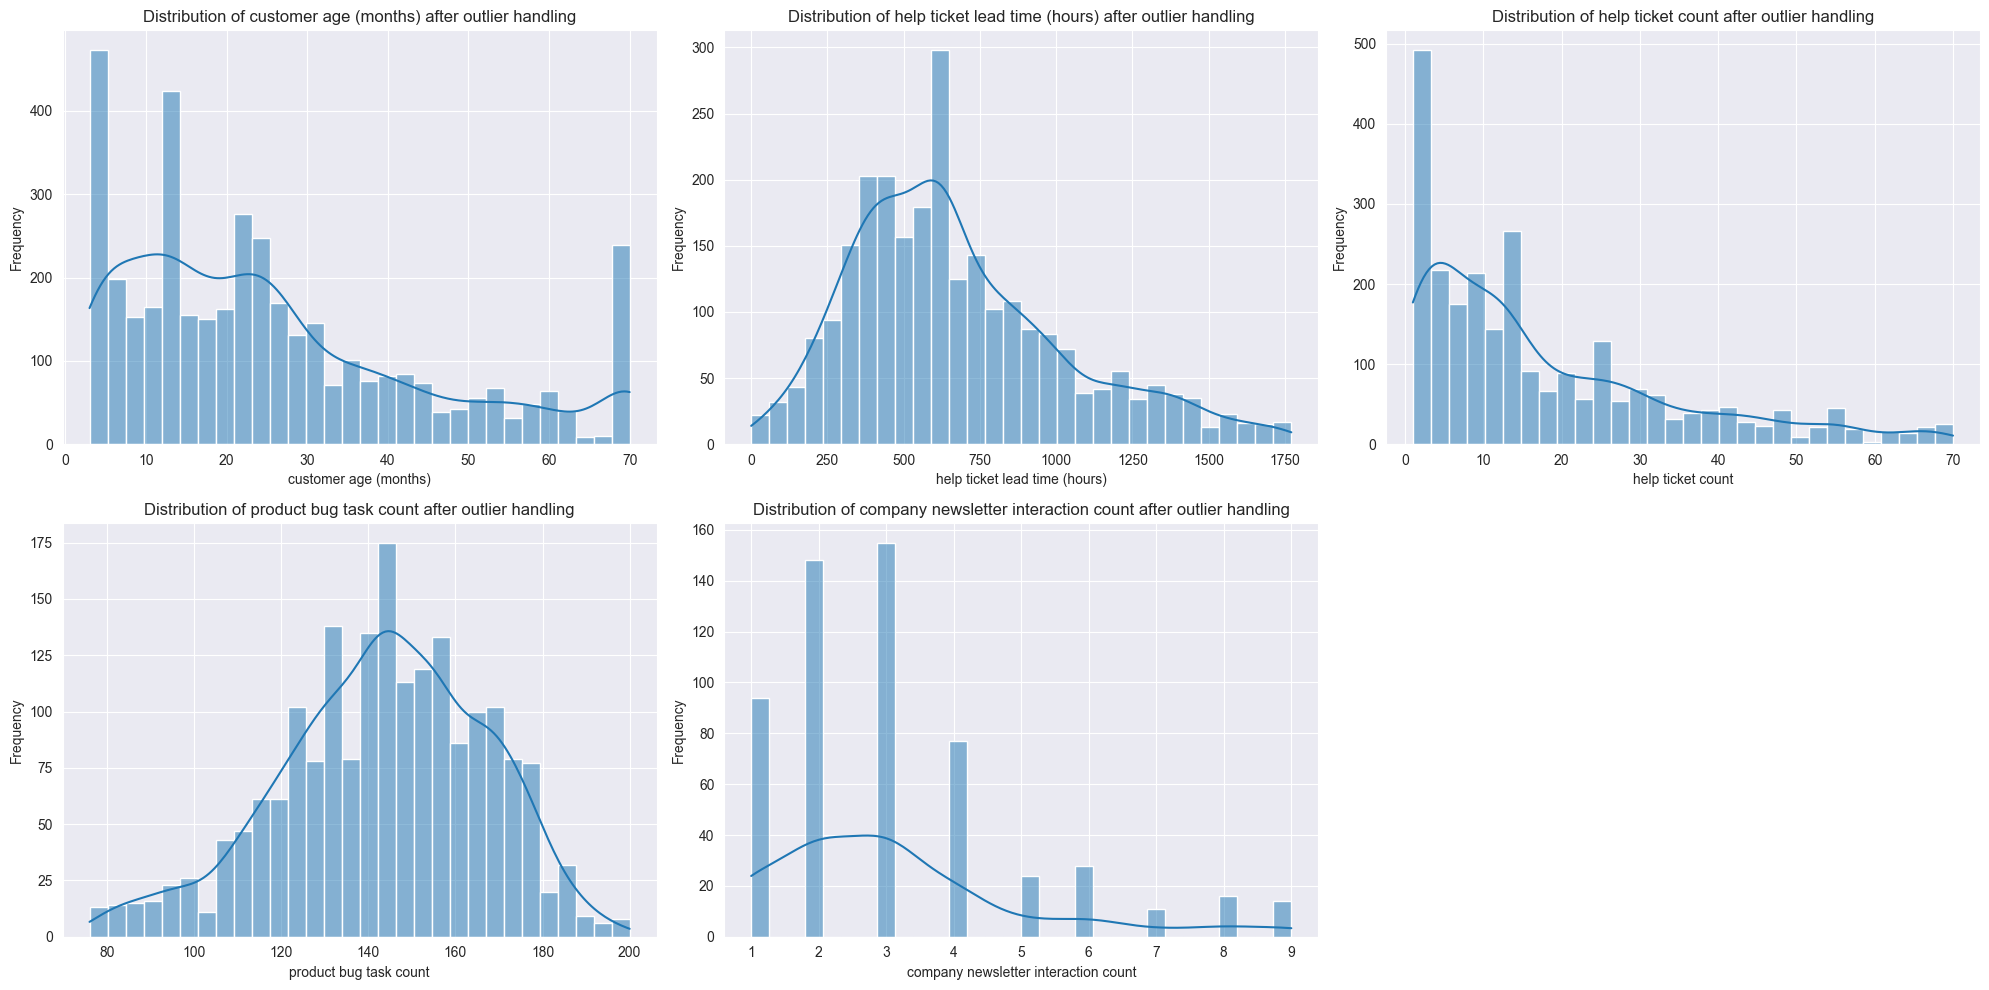

In [542]:
from scipy.stats._mstats_basic import winsorize

merged_df["customer age (months)"] = winsorize(merged_df["customer age (months)"], limits=[0.05, 0.05])

for col in selected_col:
    if col != "customer age (months)":
        replace_outliers_with_median(merged_df, col)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i, column in enumerate(selected_col[:3]):
    sns.histplot(merged_df[column], kde=True, bins=30, ax=axes[0, i])
    axes[0, i].set_title(f'Distribution of {column} after outlier handling')
    axes[0, i].set_xlabel(column)
    axes[0, i].set_ylabel('Frequency')

for i, column in enumerate(selected_col[3:]):
    sns.histplot(merged_df[column], kde=True, bins=30, ax=axes[1, i])
    axes[1, i].set_title(f'Distribution of {column} after outlier handling')
    axes[1, i].set_xlabel(column)
    axes[1, i].set_ylabel('Frequency')

fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


Aykırı değer işlemesinden sonraki histogram grafiklerini incelediğinde:

* Customer age grafiği: Aykırı değerler temizlendikten sonra da dağılım hala biraz sağa çarpık. 20-25 ay civarında belirgin bir tepe noktası var. Dağılım 70 aya kadar uzanıyor ancak 40 aydan sonra sıklık düşük seyrediyor.

* Help ticket lead time grafiği: Aykırı değerler temizlenmiş ve ölçek daha makul (yaklaşık 1750 saate kadar). Dağılım 500-600 saat civarında bir tepe gösteriyor ve daha dengeli bir form almış.

* Help ticket Count: İlk grafiğe göre ölçek küçülmüş (70'e kadar) ve sıfır değerinde çok yüksek bir frekans görülüyor. Hala sağa çarpık ancak aykırı değerler giderilmiş durumda.

* Product Bug Task Count: Bu dağılım şimdi daha normal görünüyor ve 140-150 aralığında bir tepe noktasına sahip. Önceki grafiğe göre değer aralığı daralmış (80-200 arası).

* Company Newsletter Interaction Count: Aykırı değerler temizlenmiş ve ölçek 1-9 arasına indirgenmiş. Dağılım 1, 2 ve 3 değerlerinde belirgin tepeler gösteriyor ve sonra hızla düşüyor.


Tüm grafikler aykırı değer işlemesi sayesinde daha anlamlı ve yorumlanabilir hale geldi. Bu işlem, özellikle çok çarpık olan dağılımlarda veri analizinin kalitesini arttırdı.

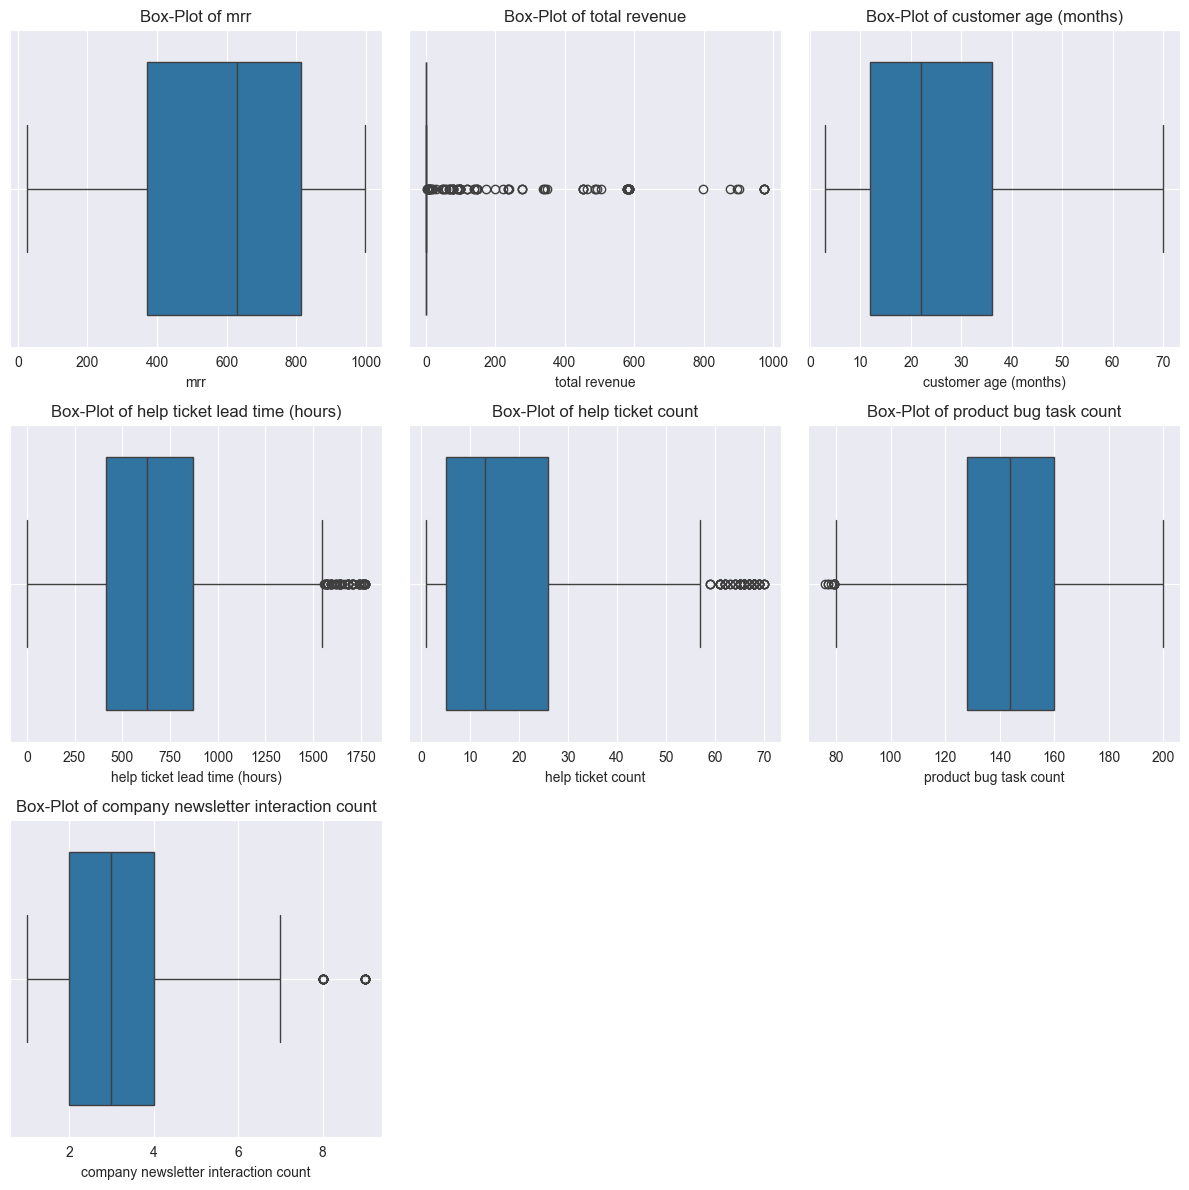

In [543]:
rows, cols = 3,3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 4, rows * 4))

for i, column in enumerate(numerical_col):
    row, col = divmod(i, cols)
    sns.boxplot(x=merged_df[column], ax=axes[row, col])
    axes[row, col].set_title(f'Box-Plot of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].grid(True)

fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])
plt.tight_layout()
plt.show()


### Categorical outlier tespiti ve üstesinden gelme

In [544]:
cat_outliers = []

categorical_col = ['recommend_score',
                   'gain_score',
                   'product_quality',
                   'panel_usability',
                   'using_frequency',
                   'converted_status',
                   'converted_customer_level',
                   'converted_region',
                   'converted_vertical']
lower_threshold = 50


for col in categorical_col:
    category_counts = merged_df[col].value_counts()
    rare_categories = category_counts[category_counts < lower_threshold].index.tolist()
    
    print(f"Aykırı kategoriler ({col}): {rare_categories}")


Aykırı kategoriler (recommend_score): [4.0, 3.0, 0.0, 1.0, 2.0]
Aykırı kategoriler (gain_score): [2.0, 1.0]
Aykırı kategoriler (product_quality): [2.0, 1.0, 0.0]
Aykırı kategoriler (panel_usability): [1.0]
Aykırı kategoriler (using_frequency): []
Aykırı kategoriler (converted_status): []
Aykırı kategoriler (converted_customer_level): []
Aykırı kategoriler (converted_region): []
Aykırı kategoriler (converted_vertical): []


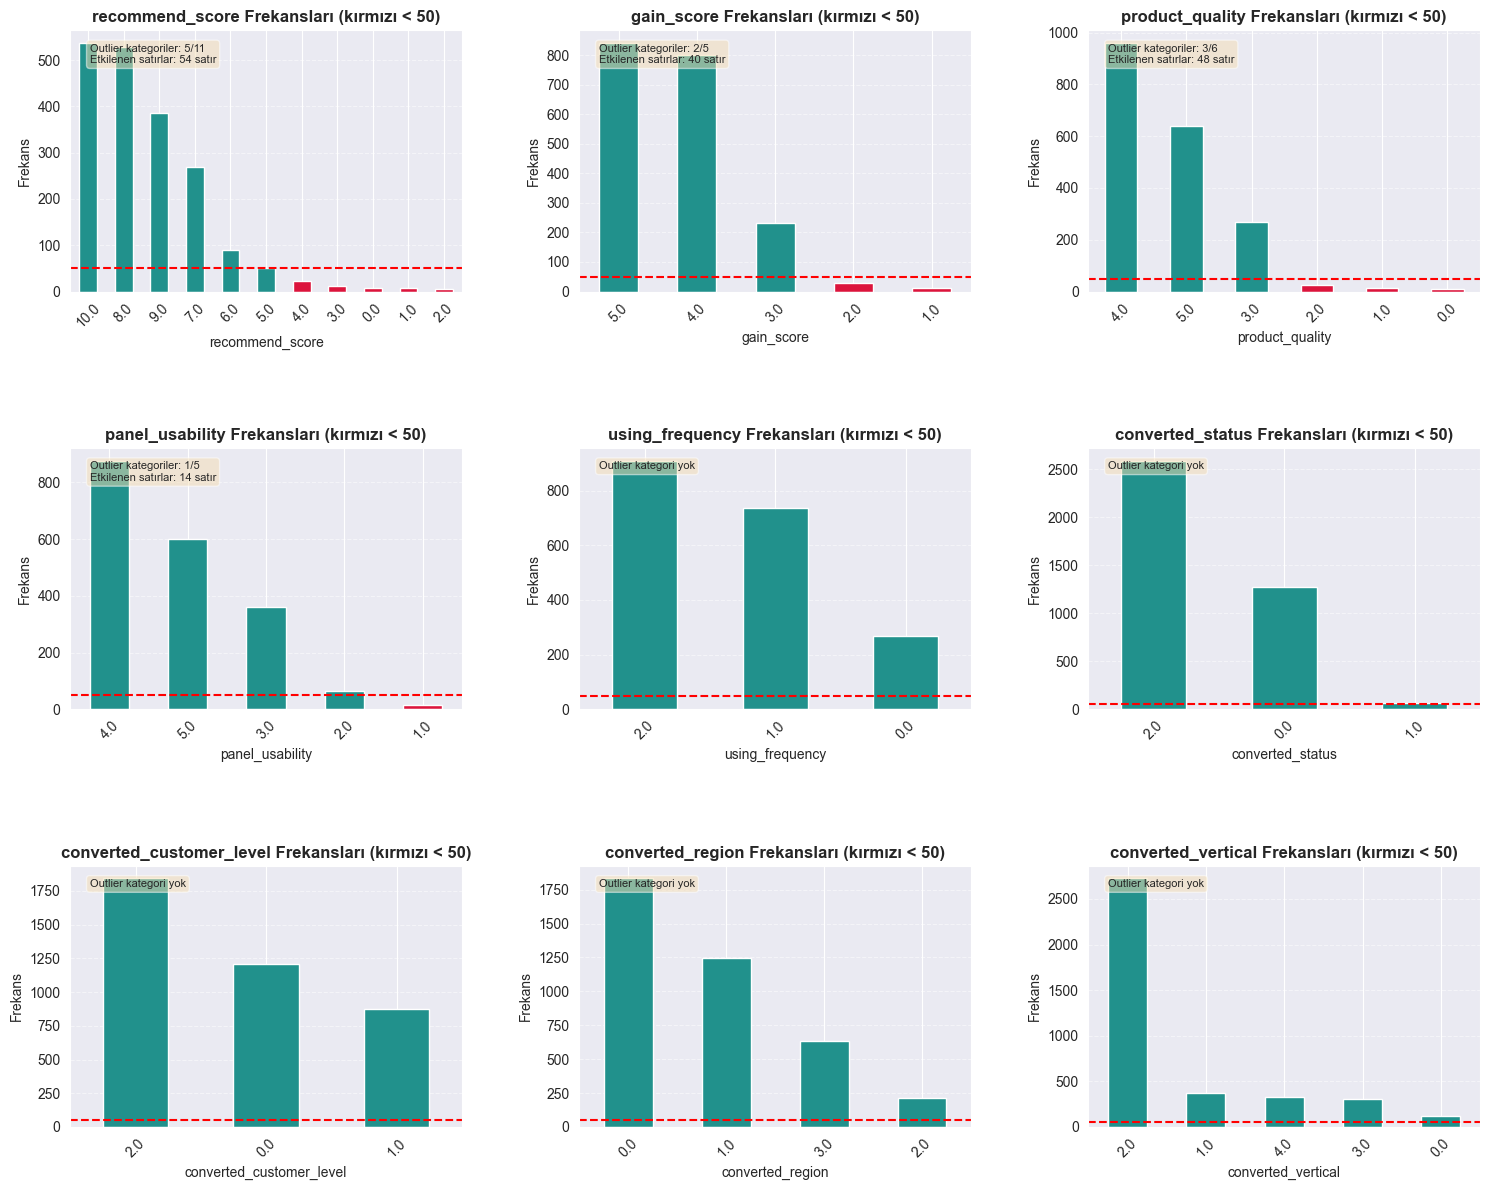


Kategorik Değişkenlerdeki Outlier Bilgileri:
recommend_score:
  Outlier kategoriler: 5/11 kategori
  Etkilenen satırlar: 54 satır
--------------------------------------------------
gain_score:
  Outlier kategoriler: 2/5 kategori
  Etkilenen satırlar: 40 satır
--------------------------------------------------
product_quality:
  Outlier kategoriler: 3/6 kategori
  Etkilenen satırlar: 48 satır
--------------------------------------------------
panel_usability:
  Outlier kategoriler: 1/5 kategori
  Etkilenen satırlar: 14 satır
--------------------------------------------------
using_frequency: Outlier kategori yok
--------------------------------------------------
converted_status: Outlier kategori yok
--------------------------------------------------
converted_customer_level: Outlier kategori yok
--------------------------------------------------
converted_region: Outlier kategori yok
--------------------------------------------------
converted_vertical: Outlier kategori yok
----------

In [545]:
lower_threshold = 50

n_cols = 3
n_rows = (len(categorical_col) + 1) // 3

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

color_threshold = 'crimson'
color_normal = plt.cm.viridis(0.5)
color_line = 'red'

outlier_info = {}

for i, column in enumerate(categorical_col):
    if i < len(axes):
        counts = merged_df[column].value_counts().sort_values(ascending=False)
        rare_categories = counts[counts < lower_threshold].index.tolist()
        colors = [color_normal if count >= lower_threshold else color_threshold for count in counts]
        counts.plot(kind='bar', color=colors, ax=axes[i])
        axes[i].axhline(y=lower_threshold, color=color_line, linestyle='--')
        axes[i].set_title(f'{column} Frekansları (kırmızı < {lower_threshold})', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Frekans', fontsize=10)
        axes[i].set_xlabel(column, fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, linestyle="--", alpha=0.5, axis='y')
        
        affected_rows = len(merged_df[merged_df[column].isin(rare_categories)])
        outlier_info[column] = {
            'outlier_count': len(rare_categories),
            'total_categories': len(counts),
            'affected_rows': affected_rows
        }
        
        if rare_categories:
            textstr = f"Outlier kategoriler: {len(rare_categories)}/{len(counts)}\n"
            textstr += f"Etkilenen satırlar: {affected_rows} satır"
        else:
            textstr = "Outlier kategori yok"
            
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axes[i].text(
            0.05, 0.95, textstr,
            transform=axes[i].transAxes,
            fontsize=8,
            verticalalignment='top',
            bbox=props
        )

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.3)
plt.show()

print("\nKategorik Değişkenlerdeki Outlier Bilgileri:")
print("="*50)
for col, info in outlier_info.items():
    if info['outlier_count'] > 0:
        print(f"{col}:")
        print(f"  Outlier kategoriler: {info['outlier_count']}/{info['total_categories']} kategori")
        print(f"  Etkilenen satırlar: {info['affected_rows']} satır")
        print("-"*50)
    else:
        print(f"{col}: Outlier kategori yok")
        print("-"*50)



Sadece memnuniyet metrikleri outlier içeriyor, buradaki outlier'ları silersek veya değiştirirsek analizimizin kalitesini düşüreceğini düşündüğümüzden silmiyoruz.

### NaN Valueları doldurma

NaN değerler çok fazla olduğu için model eğiterek eksik verileri dolduracağız. Model eğitirken target column'un NaN olduğu satırlar dışındaki verilerden öğrenerek boşluklar tahmin edilecek. Target column'un korelasyonunun yüksek olduğu columnları kullarak model eğitmek yerine tüm columnları kullanmamızın sebebi, model korelasyon analizinden daha ince detay ve benzerlikleri yakalayabileceğinden daha isabetli tahminler yapabilir bu yüzden NaN value miktarı da fazla olduğundan bu yöntemi kullanmak daha uygun.
Model olarak Random Forest Regressor kullanmamızın sebebi de lineer olmayan ilişkileri de öğrenebilmesi ve gürültü, aykırı değerlere karşı daha dayanıklı olması.

In [546]:
columns_to_fill = [
    'recommend_score',
    'gain_score',
    'product_quality',
    'panel_usability',
    'using_frequency',
    "customer age (months)",
    "converted_status",
    "converted_customer_level",
    "help ticket count",
    "help ticket lead time (hours)",
    "mrr",
    "company newsletter interaction count",
    "product bug task count",
    "total revenue",
    "converted_region",
    "converted_vertical",
    "panel_comment"
]

for col in columns_to_fill:
        merged_df = fill_missing_values(merged_df, col)

print(r2_score)
print( merged_df.isnull().sum())

# Response date'i doldurmak mantıksız olacağı için doldurmadık.

R² skoru (recommend_score): 0.939
R² skoru (gain_score): 0.936
R² skoru (product_quality): 0.908
R² skoru (panel_usability): 0.901
R² skoru (using_frequency): 0.865
R² skoru (converted_status): 0.929
R² skoru (converted_customer_level): 0.882
R² skoru (help ticket count): 0.968
R² skoru (help ticket lead time (hours)): 0.927
R² skoru (mrr): 0.938
R² skoru (company newsletter interaction count): 0.956
R² skoru (product bug task count): 0.951
R² skoru (total revenue): 0.945
R² skoru (converted_region): 0.949
R² skoru (converted_vertical): 0.934
R² skoru (panel_comment): 0.891
<function r2_score at 0x155d4c0e0>
customer id                                0
response date                           2067
recommend_score                            0
gain_score                                 0
using_frequency                            0
product_quality                            0
panel_usability                            0
panel_comment                              0
customer age (months)   

In [547]:
# Float olan tüm sütunları integer'a çevirme (customer id ve response date hariç)

for col in merged_df.columns:
    if col not in ["customer id", "response date"] and merged_df[col].dtype == 'float64':
        merged_df[col] = merged_df[col].astype(int)

print(merged_df.dtypes)

customer id                             object
response date                           object
recommend_score                          int64
gain_score                               int64
using_frequency                          int64
product_quality                          int64
panel_usability                          int64
panel_comment                            int64
customer age (months)                    int64
converted_status                         int64
converted_customer_level                 int64
help ticket count                        int64
help ticket lead time (hours)            int64
mrr                                      int64
company newsletter interaction count     int64
product bug task count                   int64
total revenue                            int64
converted_region                         int64
converted_vertical                       int64
dtype: object


### Feature Engineering

In [548]:
merged_df['recommend_score_new'] = np.select(
    [merged_df['recommend_score'].between(0, 4),
     merged_df['recommend_score'].between(5, 6),
     merged_df['recommend_score'].between(7, 10)],
    [0, 1, 2]
)

merged_df['gain_score_new'] = np.select(
    [merged_df['gain_score'].between(0, 1),
     merged_df['gain_score'].between(2, 3),
     merged_df['gain_score'].between(4, 5)],
    [0, 1, 2]
)

merged_df['product_quality_new'] = np.select(
    [merged_df['product_quality'].between(0, 1),
     merged_df['product_quality'].between(2, 3),
     merged_df['product_quality'].between(4, 5)],
    [0, 1, 2]
)

merged_df['panel_usability_new'] = np.select(
    [merged_df['panel_usability'].between(0, 1),
     merged_df['panel_usability'].between(2, 3),
     merged_df['panel_usability'].between(4, 5)],
    [0, 1, 2]
)

merged_df['sorun_çözme_süresi'] = merged_df['help ticket lead time (hours)'] / merged_df['help ticket count']

merged_df['birim_basi_kazanc'] = merged_df['total revenue'] / (merged_df['mrr'] * merged_df['customer age (months)'])

merged_df['memnuniyet_skoru'] = (merged_df['recommend_score'] + merged_df['panel_usability'] + merged_df['product_quality'] + merged_df['gain_score'])/4

merged_df['interaction_rate'] = merged_df['help ticket count']/merged_df['product bug task count']


* **recommend_score_new, gain_score_new, product_quality_new, panel_usability_new** : Skorları kategorize ederek daha anlamlı analizler yapmayı sağlar.
* **sorun_çözme_süresi (Help Ticket Lead Time / Help Ticket Count)**: Destek taleplerinin çözüm süresinin ölçüsü.
* **Birim_basi_kazanc (Total Revenue / (MRR * Customer Age))**: Müşterinin aylık olarak yatırdığı para başına kazancı.
* **memnuniyet_skoru (Memnuniyet değişkenlerinin ortalaması)**: Genel müşteri memnuniyetini tek bir metrikle özetler.
* **interaction_rate (Help Ticket Count / Product Bug Task Count)**: Müşterinin sorun başına istediği yardım sayısı. Kullanıcın şirketle geçtiği etkileşimi ölçmek için önemli.

# 2.Analiz ve Görselleştirmeler


### Görselleştirmeler

In [549]:
# Status için encoding (converted_status kullanılacak)
status_map = {
    0: 'Kaybedilmiş',
    1: 'Beklemede',
    2: 'Aktif Müşteri'
}
merged_df['status_category'] = merged_df['converted_status'].map(status_map)

# Customer level için encoding (converted_customer_level kullanılacak)
customer_level_map = {
    0: 'Long-tail',
    1: 'Semi-Enterprise',
    2: 'Enterprise'
}
merged_df['customer_level_category'] = merged_df['converted_customer_level'].map(customer_level_map)

# Region için encoding (converted_region kullanılacak)
region_map = {
    0: 'Avrupa',
    1: 'Asya',
    2: 'Amerika',
    3: 'Orta Doğu ve Afrika'
}
merged_df['region_category'] = merged_df['converted_region'].map(region_map)

# Vertical için encoding (converted_vertical kullanılacak)
vertical_map = {
    0: 'Teknoloji ve Dijital',
    1: 'Finans ve Ticaret',
    2: 'Ulaşım, Lojistik ve Seyahat',
    3: 'Sağlık, Eğitim ve Medya',
    4: 'Diğer'
}
merged_df['vertical_category'] = merged_df['converted_vertical'].map(vertical_map)


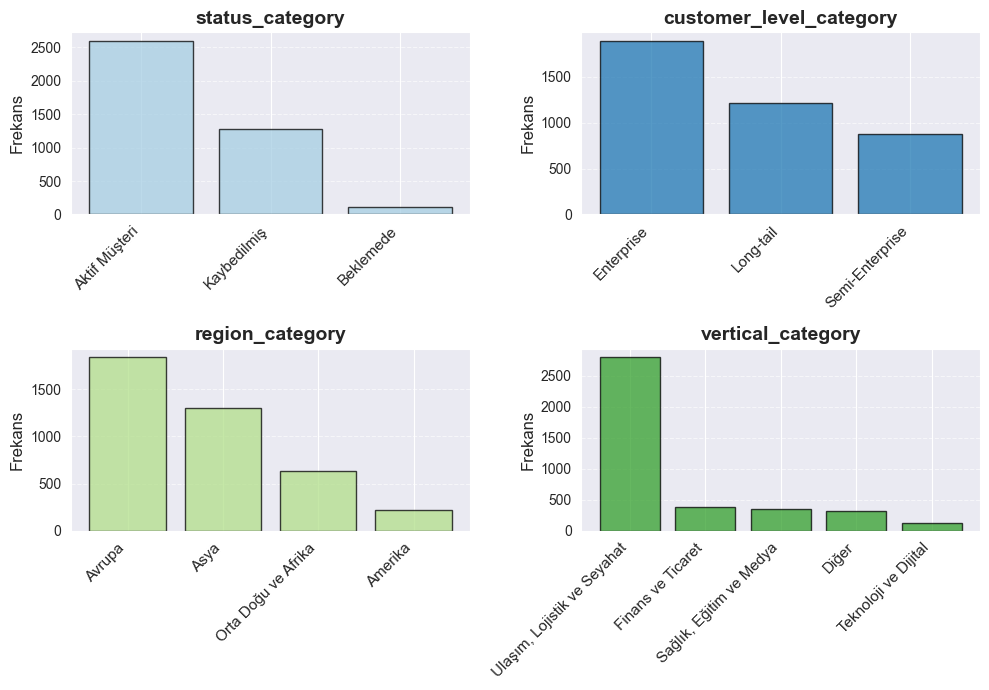

In [550]:
categorical_columns = [
    "status_category", "customer_level_category", 
    "region_category", "vertical_category"
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
axes = axes.flatten()

colors = plt.cm.Paired.colors

for i, col in enumerate(categorical_columns):
    value_counts = merged_df[col].value_counts()

    axes[i].bar(value_counts.index, value_counts.values,
                color=colors[i % len(colors)], edgecolor='black', alpha=0.75)

    axes[i].set_title(col, fontsize=14, fontweight='bold')
    axes[i].set_ylabel("Frekans", fontsize=12)

    axes[i].set_xticks(range(len(value_counts.index)))

    axes[i].set_xticklabels(value_counts.index, rotation=45, ha="right", fontsize=11)

    axes[i].grid(axis='y', linestyle="--", alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


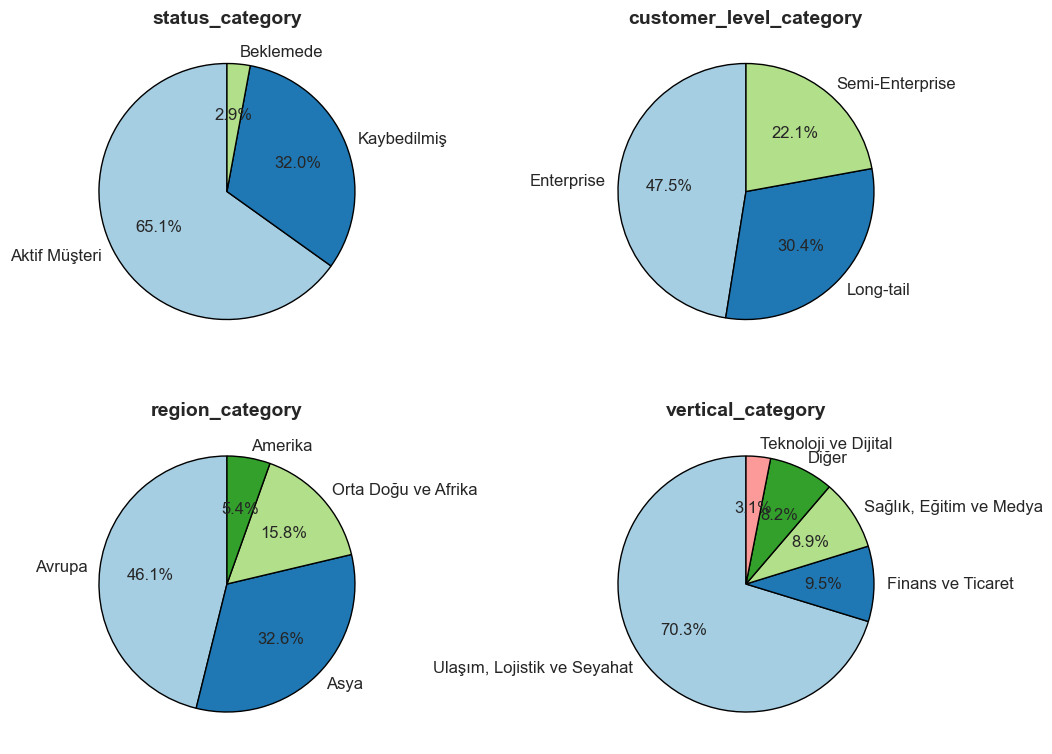

In [551]:
categorical_columns = [
    "status_category", "customer_level_category", 
    "region_category", "vertical_category"
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes = axes.flatten()

colors = plt.cm.Paired.colors

for i, col in enumerate(categorical_columns):
    value_counts = merged_df[col].value_counts()
    wedges, texts, autotexts = axes[i].pie(
        value_counts.values, labels=value_counts.index, 
        autopct="%1.1f%%", colors=colors, startangle=90, 
        wedgeprops={"edgecolor": "black", "linewidth": 1},
        textprops={"fontsize": 12}
    )
    
    axes[i].set_title(col, fontsize=14, fontweight="bold")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Pasta ve çubuk grafiklerin yorumları:

 **Status Category (Durum Kategorisi)**
- **Aktif Müşteri**: %65.2 ile çoğunluğu oluşturuyor (~2500 müşteri)
- **Kaybedilmiş**: %32.0 ile önemli bir kesim (~1300 müşteri)
- **Beklemede**: Sadece %2.9 (~100 müşteri)

Bu dağılım, müşteri tutma oranının nispeten iyi olduğunu ancak %32'lik bir kayıp oranının da dikkat çekici olduğunu gösteriyor. Kaybedilen müşterilerin nedenlerini analiz etmek önemli olacaktır.

 **Customer Level Category (Müşteri Seviye Kategorisi)**
- **Enterprise**: %47.5 ile en büyük segment (~1700 müşteri)
- **Long-tail**: %30.4 (~1200 müşteri)
- **Semi-Enterprise**: %22.0 (~850 müşteri)

İşletmenin müşteri tabanı ağırlıklı olarak kurumsal müşterilerden oluşuyor. Gelir artışı için Enterprise segmentinin ihtiyaçlarına odaklanmak mantıklı ancak diğer segmentleri de geliştirmek çeşitlilik sağlayacaktır.

**Region Category (Bölge Kategorisi)**
- **Avrupa**: %46.1 ile en büyük pazar (~1800 müşteri)
- **Asya**: %32.6 (~1300 müşteri)
- **Orta Doğu ve Afrika**: %15.8 (~600 müşteri)
- **Amerika**: %5.4 (~200 müşteri)

İşletme Avrupa pazarında güçlü, Asya'da önemli bir varlık gösteriyor. Amerika'daki düşük varlık, potansiyel büyüme fırsatı sunabilir. Bölgesel stratejileri müşteri ihtiyaçlarına göre uyarlamak önemli.

**Vertical Category (Dikey Kategori)**
- **Ulaşım, Lojistik ve Seyahat**: %71.0 ile baskın sektör (~2800 müşteri)
- **Finans ve Ticaret**: %9.5 (~400 müşteri)
- **Sağlık, Eğitim ve Medya**: %8.2 (~300 müşteri)
- **Diğer**: %7.2 (~300 müşteri)
- **Teknoloji ve Dijital**: %3.1 (~100 müşteri)

İşletme çok net bir şekilde ulaşım ve lojistik sektöründe uzmanlaşmış durumda. Bu, sektöre özel çözümlerde derin bir uzmanlık sağlayabilir ancak diğer sektörlere genişleme potansiyeli de mevcuttur.



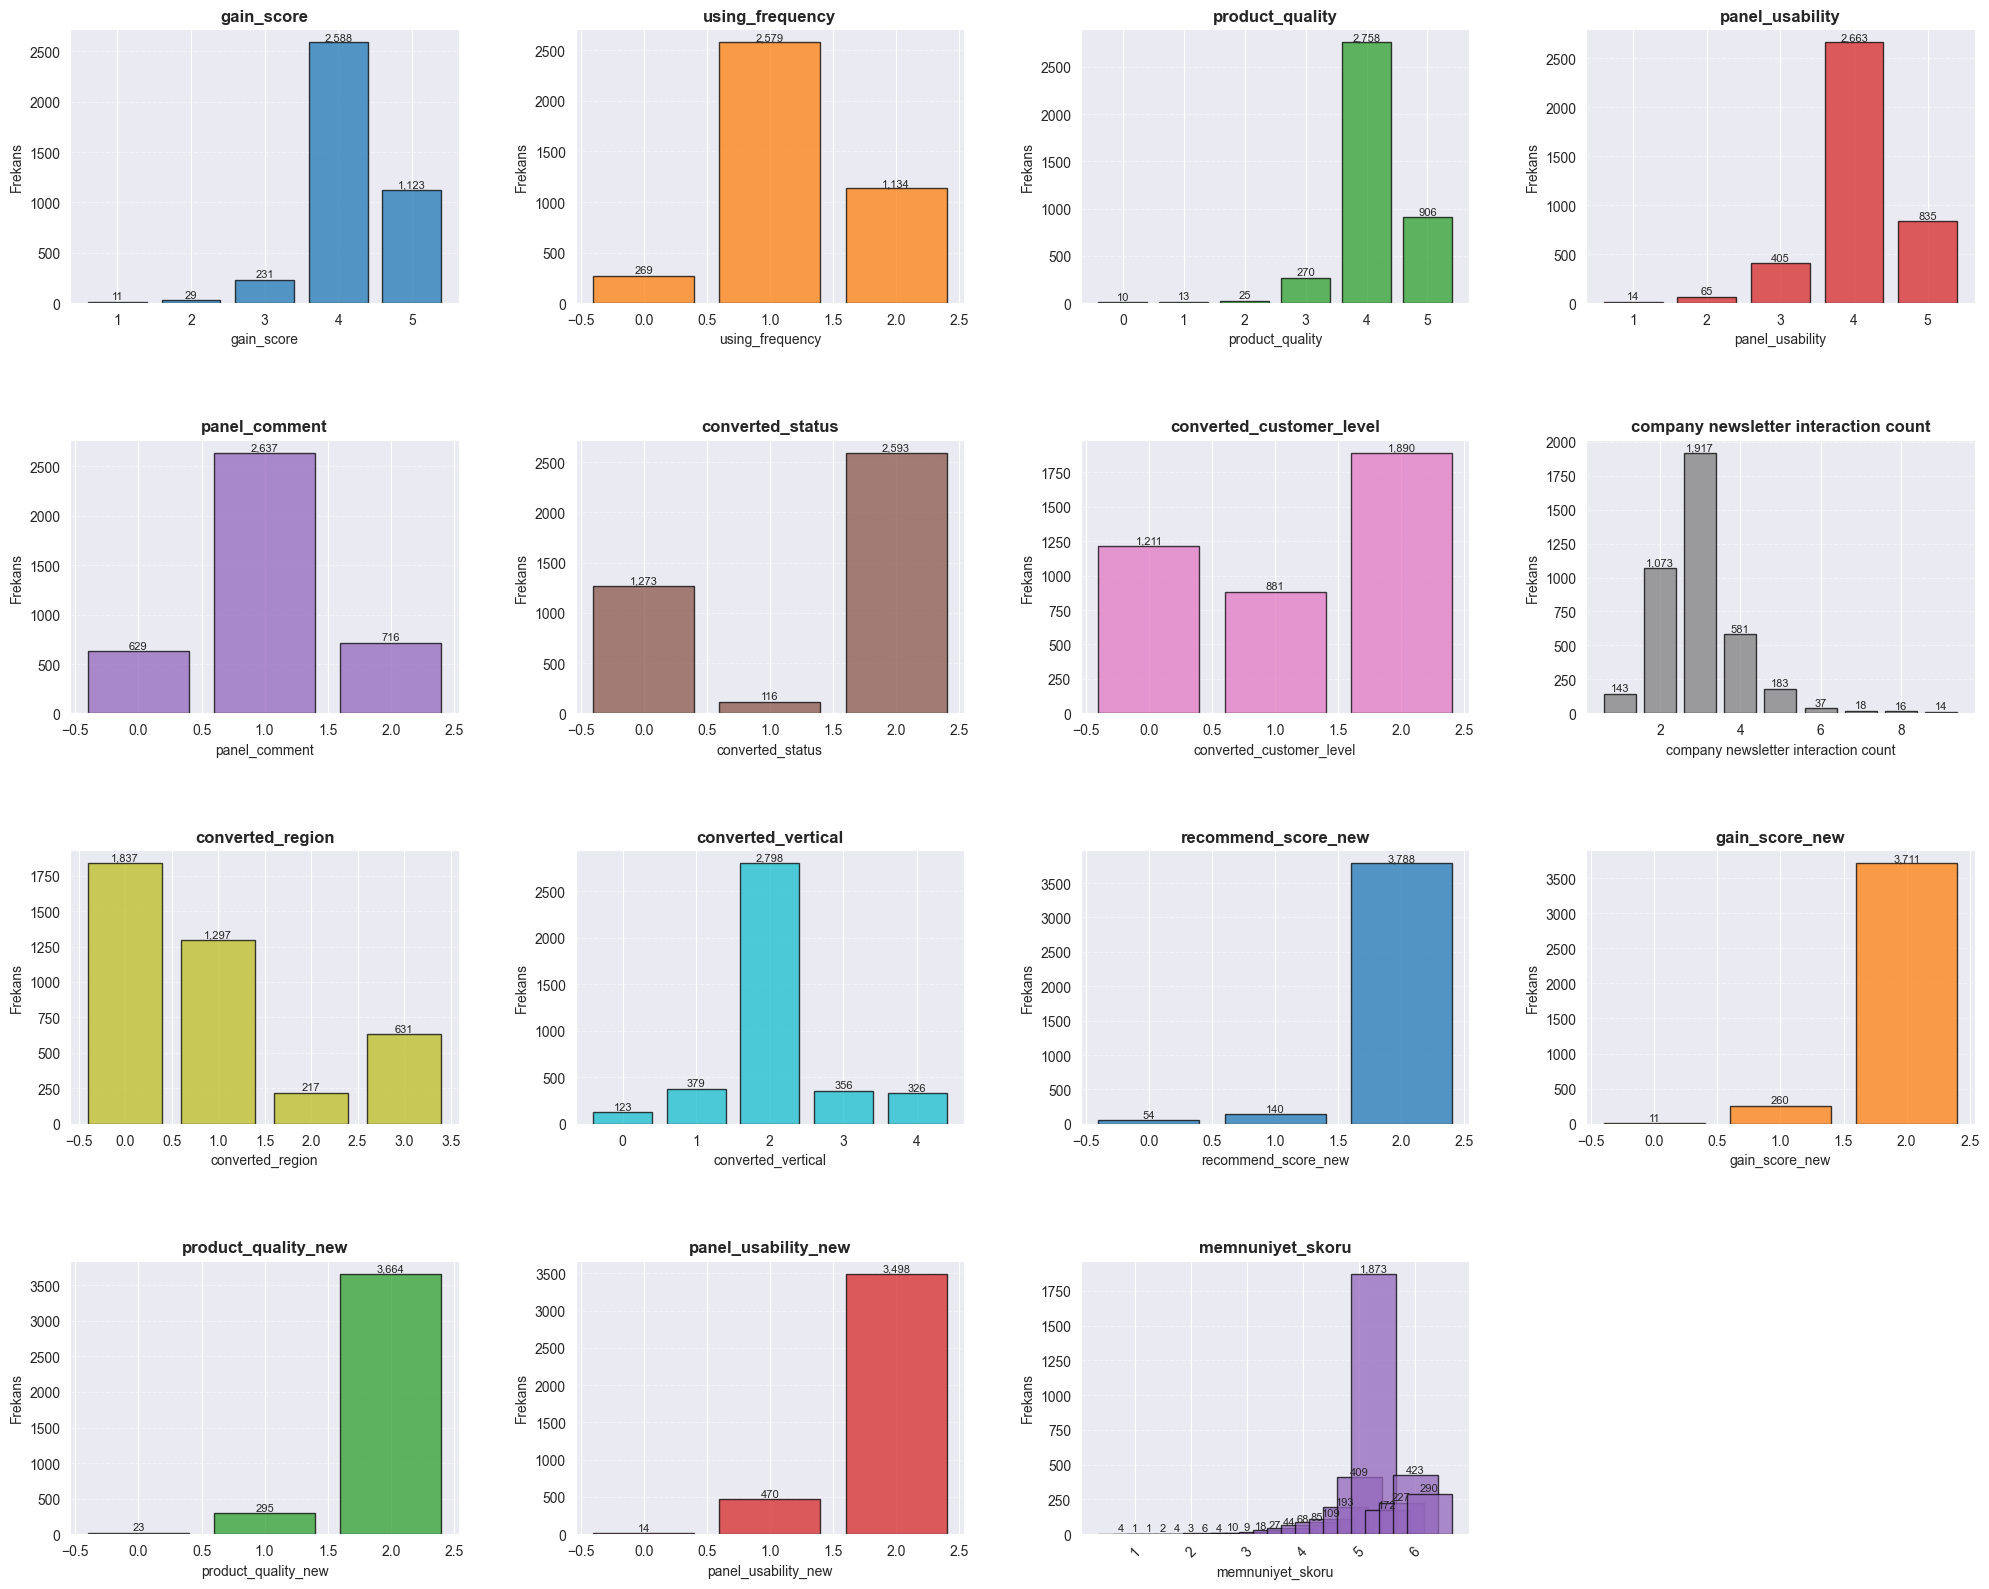

In [552]:
categorical_columns = [
    "gain_score", "using_frequency", "product_quality", "panel_usability", 
    "panel_comment", "converted_status", "converted_customer_level",
    "company newsletter interaction count", "converted_region", "converted_vertical",
    "recommend_score_new", "gain_score_new", "product_quality_new",
    "panel_usability_new", "memnuniyet_skoru"
]

n_cols = min(4, len(categorical_columns))
n_rows = math.ceil(len(categorical_columns) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

colors = plt.cm.tab10.colors

for i, col in enumerate(categorical_columns):
    value_counts = merged_df[col].value_counts().sort_index()
    
    bars = axes[i].bar(
        x=value_counts.index, 
        height=value_counts.values,
        color=colors[i % len(colors)],
        edgecolor='black',
        alpha=0.75
    )
    
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_ylabel("Frekans", fontsize=10)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].grid(True, linestyle="--", alpha=0.5, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width()/2.,
            height + 5,
            f'{height:,}',
            ha='center', 
            va='bottom',
            fontsize=8
        )
    
    if len(value_counts) > 10:
        plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

gain_score: Çoğunluk 4 puan vermiş (2,607 kişi), ikinci olarak 5 puan (1,104 kişi). Düşük puanlar çok az.

using_frequency: Kullanım sıklığı çoğunlukla 1.0 seviyesinde (2,587 kişi), ardından 2.0 (1,125 kişi) geliyor.

product_quality: Ürün kalitesi değerlendirmesi genellikle çok yüksek, çoğunluk 4 puan vermiş (2,777 kişi).

panel_usability: Panel kullanılabilirliği çoğunlukla 4 puanda yoğunlaşmış (2,696 kişi), ardından 5 puan (821 kişi) geliyor.

panel_comment: Yorumlar genellikle 1.0 değerinde (2,657 kişi), 0.0 ve 2.0 değerleri daha az.

converted_status: Dönüştürme durumu çoğunlukla 2.0 seviyesinde (2,595 kişi), ikinci olarak 0.0 (1,273 kişi).

converted_customer_level: Müşteri seviyesi dönüşümü en çok 2.0 (1,892 kişi), sonra 0.0 (1,212 kişi) ve 1.0 (878 kişi).

company_newsletter: Bülten etkileşimi çoğunlukla 2-3 aralığında, 3 etkileşim en yüksek (1,912 kişi).

converted_region: Bölge dönüşümü 0.0'da en yüksek (1,834 kişi), değer arttıkça katılım azalıyor.

converted_vertical: Dikey dönüşüm belirgin şekilde 2.0 seviyesinde yoğunlaşmış (2,826 kişi).

recommend_score_new: Tavsiye puanı çok yüksek, çoğunluk 2.0 puanda (3,788 kişi).

gain_score_new: Kazanç puanı da çok yüksek, çoğunluk 2.0'da (3,711 kişi).

product_quality_new: Ürün kalitesi yeni değerlendirmesi baskın şekilde 2.0 puanda (3,664 kişi).

panel_usability_new: Panel kullanılabilirliği yeni değerlendirmesi büyük oranda 2.0 puanda (3,519 kişi).

memnuniyet_skoru: Memnuniyet skoru çoğunlukla 5 civarında yoğunlaşmış (1,884 kişi), 4-6 aralığında dağılım gösteriyor.

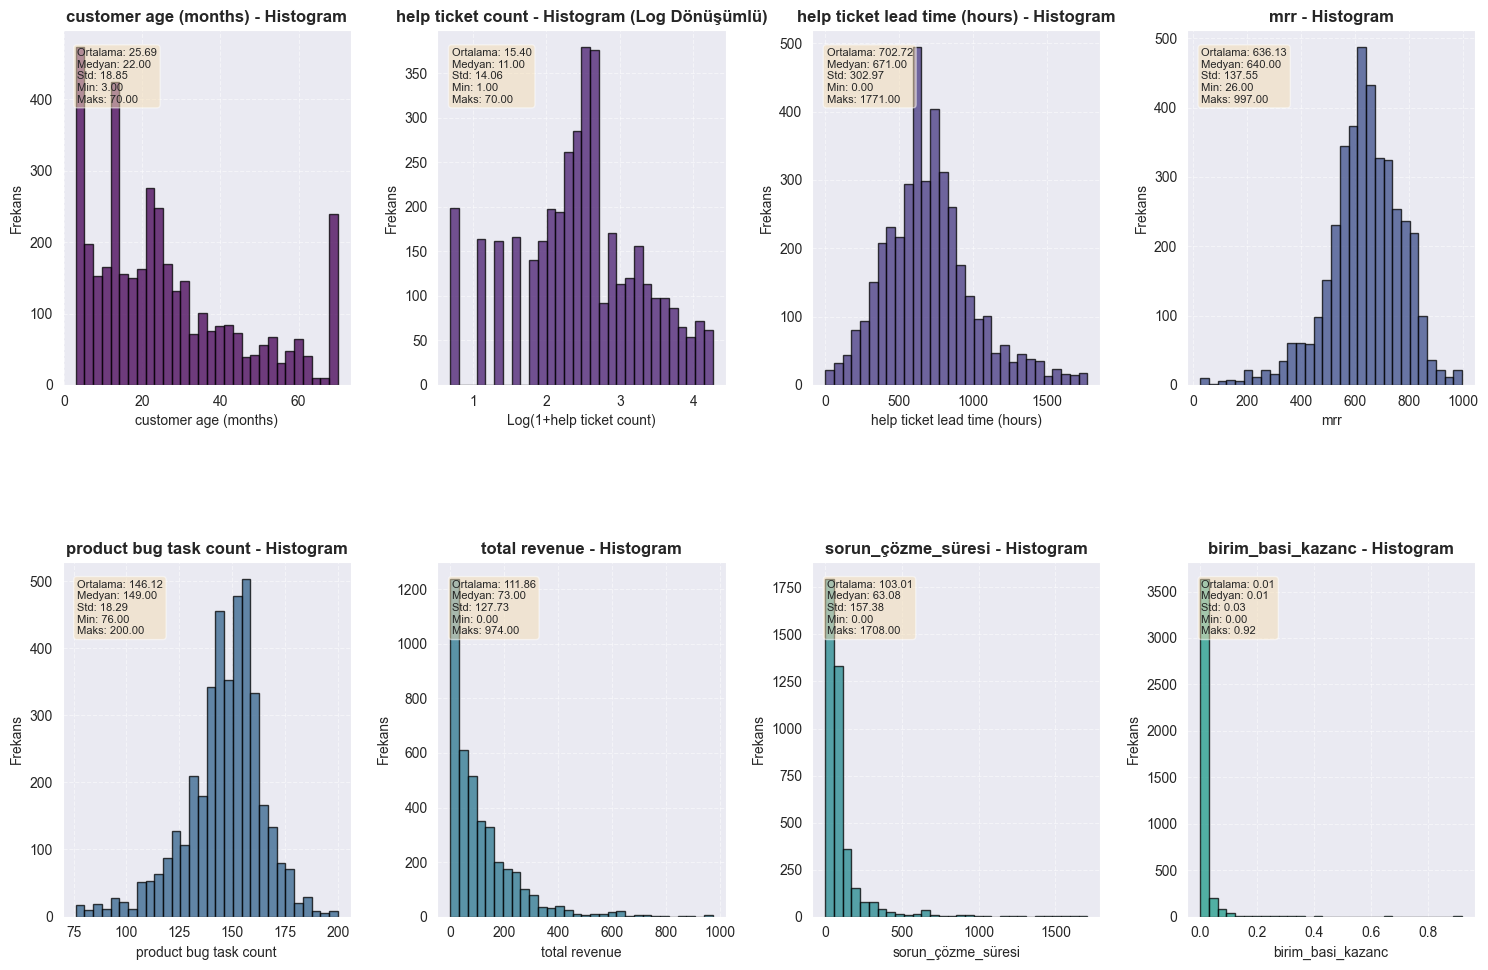

In [553]:
numeric_columns = [
    "customer age (months)", "help ticket count", "help ticket lead time (hours)",
    "mrr", "product bug task count", "total revenue", "sorun_çözme_süresi", 
    "birim_basi_kazanc"
]

skewed_columns = ["help ticket count", "total revenue", "sorun_çözme_süresi", "birim_basi_kazanc"]

n_plots = len(numeric_columns)
n_rows = (n_plots + 1) // 2
n_cols = 4

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

colors = plt.cm.viridis.colors

for i, col in enumerate(numeric_columns):
    if i < len(axes):
        data = merged_df[col].dropna()
        
        if col in skewed_columns and (data > 0).all():
            transformed_data = np.log1p(data)
            data_to_plot = transformed_data
            xlabel = f"Log(1+{col})"
            title = f"{col} - Histogram (Log Dönüşümlü)"
        else:
            data_to_plot = data
            xlabel = col
            title = f"{col} - Histogram"
        
        axes[i].hist(
            data_to_plot,
            bins=30,
            color=colors[i*20 % len(colors)],
            edgecolor='black',
            alpha=0.75
        )
        axes[i].set_title(title, fontsize=12, fontweight='bold')
        axes[i].set_ylabel("Frekans", fontsize=10)
        axes[i].set_xlabel(xlabel, fontsize=10)
        axes[i].grid(True, linestyle="--", alpha=0.5)
        
        textstr = f"Ortalama: {data.mean():.2f}\n"
        textstr += f"Medyan: {data.median():.2f}\n"
        textstr += f"Std: {data.std():.2f}\n"
        textstr += f"Min: {data.min():.2f}\n"
        textstr += f"Maks: {data.max():.2f}"
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axes[i].text(
            0.05, 0.95, textstr,
            transform=axes[i].transAxes,
            fontsize=8,
            verticalalignment='top',
            bbox=props
        )

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

**Customer Age (Months)**
Bimodal dağılım, müşterilerin çoğunlukla 0-20 ay ve 30-40 ay aralığında yoğunlaştığını gösteriyor. Ortalama 23.66 ay olan müşteri yaşı, hem yeni müşteri kazanımında hem de belirli bir müşteri grubunu elde tutmada başarılı olunduğuna işaret ediyor.

**Help Ticket Count (Log Dönüşümlü)**
Destek bileti sayısında belirgin kümeleşmeler görülüyor (ortalama 15.43, medyan 11). Bazı müşteriler çok az destek bileti açarken, diğer bir grup yaklaşık 20 bilet açıyor. Bu farklı destek ihtiyaçları, müşteri segmentasyonu ve proaktif destek stratejileri için bir fırsat sunuyor.

**Help Ticket Lead Time (Hours)**
Destek biletlerinin çözüm süresi ortalama 29 gün (700.27 saat) civarında ve çoğunlukla 20-40 gün arasında yoğunlaşmış. Bu uzun çözüm süresi müşteri destek süreçlerinin optimize edilmesi gerektiğini gösteriyor.

**MRR (Monthly Recurring Revenue)**
Aylık tekrarlayan gelir çoğunlukla 500-700 aralığında yoğunlaşmış (ortalama 629.73, medyan 635). Bu istikrarlı gelir akışı olumlu bir gösterge olsa da, dağılımın genişletilmesi için üst segment müşterilere yönelik stratejiler geliştirilebilir. Fiyatlandırma modeli ve ek değer yaratma fırsatları değerlendirilmelidir.

**Diğer Metrikler**
Ürün hata görevleri tutarlı bir dağılım gösterirken (ortalama 146.60), toplam gelir ve sorun çözme süresi aşırı sağa çarpık dağılımlar sergiliyor. Birim başı kazancın çok düşük olması (ortalama 0.01) ya düşük marjlı bir iş modeline ya da hesaplama yönteminin gözden geçirilmesi gerektiğine işaret ediyor. Yüksek gelirli müşteri oranını artırmak ve karmaşık sorunların çözüm süreçlerini iyileştirmek öncelikli alanlar olmalıdır.


### Korelasyon analizi

In [554]:
corr_df= merged_df.drop(columns=['customer id', 'response date','converted_region','converted_vertical','gain_score_new','recommend_score_new','product_quality_new','converted_status','status_category','customer_level_category','region_category','vertical_category'])
plt.figure(figsize=(20, 16))
correlation_matrix = corr_df.corr() 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.show()

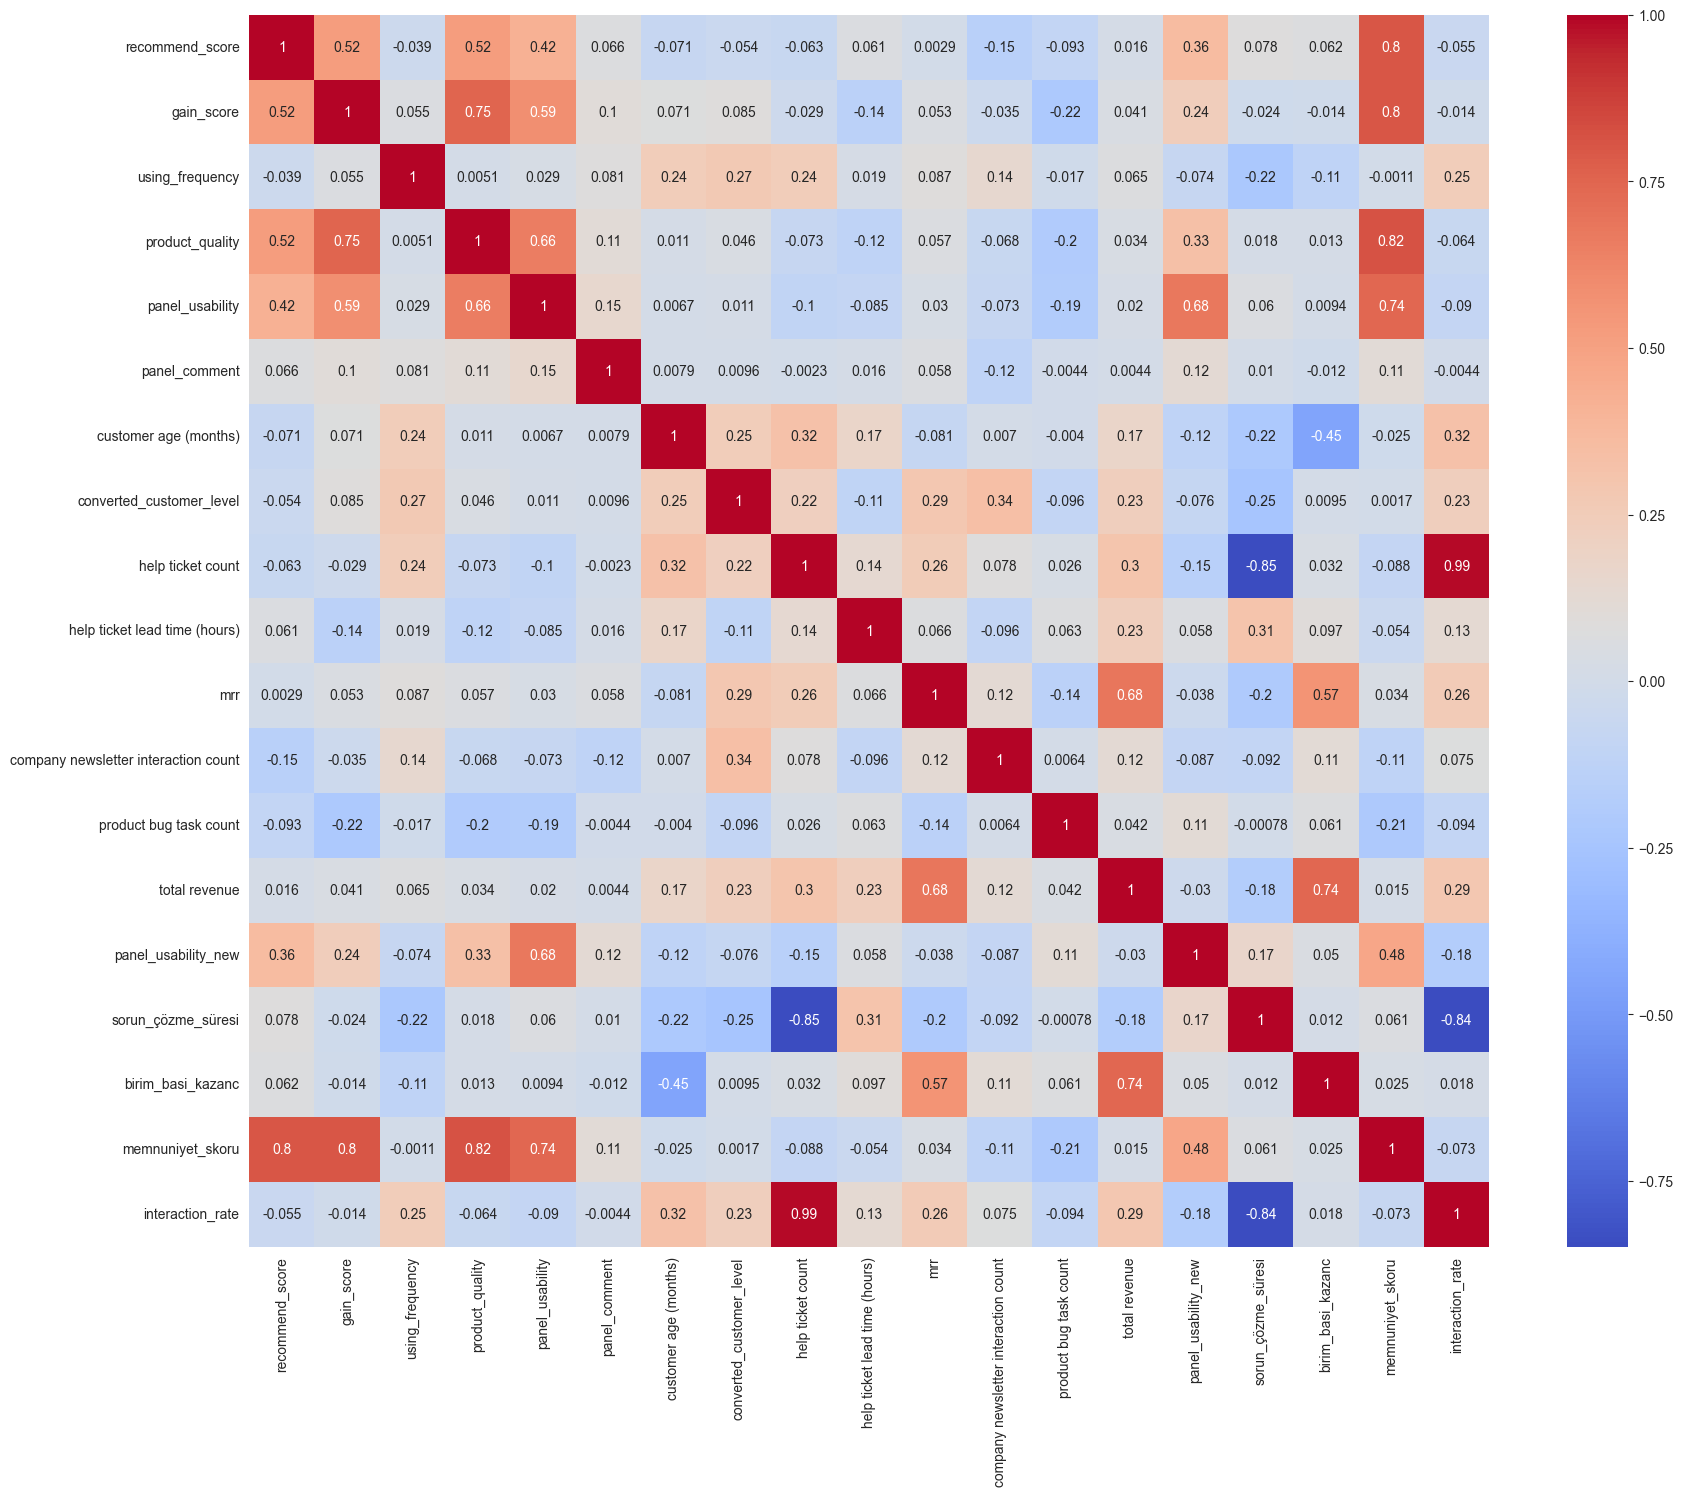

In [555]:
plt.figure(figsize=(20, 16))
corr_spearman = corr_df.corr(method='spearman')
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm')
plt.show()


**Güçlü Pozitif İlişkiler**

Memnuniyet skoru ile tavsiye puanı (0.87/0.81), ürün kalitesi (0.82/0.81) ve panel kullanılabilirliği (0.76/0.73) arasındaki güçlü korelasyonlar, müşteri memnuniyeti metriklerinin birbiriyle tutarlı olduğunu gösteriyor. Bu, bir alandaki iyileştirmenin diğer alanlara da olumlu yansıyacağına işaret ediyor.

MRR ile toplam gelir arasındaki korelasyon (0.52/0.74) ve birim başı kazanç ile toplam gelir arasındaki ilişki (0.24/0.82) gelir dinamiklerini anlamak için kritik öneme sahip. İkinci matriste birim başı kazanç ile toplam gelir arasındaki ilişkinin çok daha güçlü olması, fiyatlandırma stratejisinin etkisini vurguluyor.

Müşteri seviyesi  ile bülten etkileşimi arasındaki ilişki (0.41), müşteri etkileşiminin dönüşüm oranlarıyla doğrudan bağlantılı olduğunu gösteriyor.

**Güçlü Negatif İlişkiler**

Sorun çözme süresi ile destek bileti sayısı arasındaki güçlü negatif korelasyon (-0.40/-0.85), daha fazla destek talebi açan müşterilerin sorunlarının daha hızlı çözüldüğünü gösteriyor. Bu, ya kaynak önceliklendirmesini ya da aktif müşterilere daha fazla önem verildiğini yansıtıyor.

Müşteri yaşı ile birim başı kazanç arasındaki negatif ilişki (-0.16/-0.39), uzun süreli müşterilerin zaman içinde daha az kârlı hale geldiğini düşündürüyor. Bu durum, sadakat indirimleri veya zamanla değişen fiyatlandırma politikalarından kaynaklanabilir.

Kullanım sıklığı ve sorun çözme süresi arasındaki negatif korelasyon (-0.10/-0.23), aktif kullanıcıların destek taleplerinin önceliklendirildiğini gösteriyor.


### Clustering Analizi

Korelasyon analizi doğrusal ilşkileri gösteren bir analiz şeklidir bu yüzden direkt korelasyon ile göremediğimiz ilşkiler var mı diye clustering analizi de yapıyoruz.

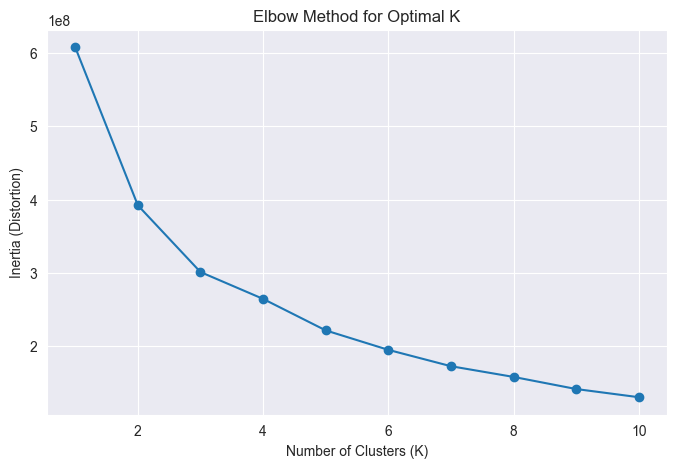

In [556]:
features = merged_df.drop(columns=['customer id', 'response date','gain_score','recommend_score','product_quality', 'panel_usability','status_category','customer_level_category','region_category','vertical_category'], errors="ignore")
clustering_df = merged_df.drop(columns=['customer id', 'response date','gain_score_new','recommend_score_new','product_quality_new', 'panel_usability_new','help ticket lead time (hours)','status_category','customer_level_category','region_category','vertical_category'])

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=25)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Distortion)")
plt.title("Elbow Method for Optimal K")
plt.show()


Elbow Methodunu kullarak clustering analizinda kaç cluster seçmemiz gerektiğini anlıyoruz. Grafiğin dirsek noktasına göre, 3 veya 4 cluster seçmek en doğru seçim olacak gibi görülüyor.

In [557]:
# Veriri standardize ediyoruz, clustering öncesi yapılması gereken bir adım.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

optimal_k = 3  # 4 ile de denendi, 3 daha isabetli sonuç veriyor

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clustering_df["cluster"] = kmeans.fit_predict(scaled_features)
clustering_df["cluster"].value_counts()


cluster
2    1954
1    1713
0     315
Name: count, dtype: int64

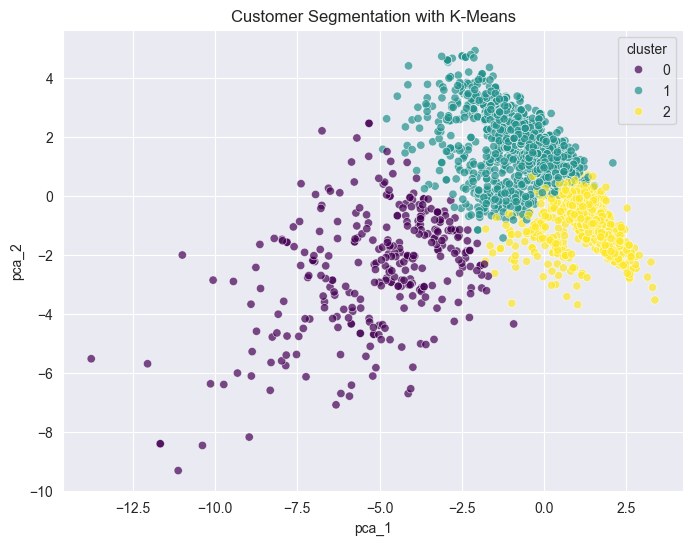

In [558]:
# PCA ile veriyi 2 boyuta indirgiyoruz
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

clustering_df["pca_1"] = pca_features[:, 0]
clustering_df["pca_2"] = pca_features[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=clustering_df["pca_1"], y=clustering_df["pca_2"], hue=clustering_df["cluster"], palette="viridis", alpha=0.7)
plt.title("Customer Segmentation with K-Means")
plt.show()


In [559]:
cluster_summary = clustering_df.groupby("cluster").mean()
cluster_summary

recommend_score  gain_score  using_frequency  product_quality  \
cluster                                                                  
0               5.980952    3.168254         1.361905         2.882540   
1               8.849971    4.402802         1.424402         4.323993   
2               8.882805    4.190890         1.012282         4.155578   

         panel_usability  panel_comment  customer age (months)  \
cluster                                                          
0               3.098413       0.857143              35.400000   
1               4.196731       1.084063              32.910683   
2               4.104913       0.993859              17.789150   

         converted_status  converted_customer_level  help ticket count  ...  \
cluster                                                                 ...   
0                1.838095                  1.412698          22.031746  ...   
1                1.798599                  1.713952          22.479276  ...   
2                0.840328                  0.655067           8.119754  ...   

         product bug task count  total revenue  converted_region  \
cluster                                                            
0                    124.101587     121.815873          1.050794   
1                    146.151197     171.715120          1.039696   
2                    149.644319      57.790686          0.773797   

         converted_vertical  sorun_çözme_süresi  birim_basi_kazanc  \
cluster                                                              
0                  2.063492           70.294062           0.006298   
1                  1.943958           61.842874           0.014751   
2                  2.234903          144.383616           0.011478   

         memnuniyet_skoru  interaction_rate     pca_1     pca_2  
cluster                                                          
0                3.782540          0.183244 -5.037143 -2.446783  
1                5.443374          0.155907 -0.507074  1.389562  
2                5.333547          0.053996  1.256560 -0.823737  

[3 rows x 22 columns]

Cluster 0:
* Recommend Score: Yüksek
* ⁠  ⁠Gain Score: Yüksek
* ⁠  ⁠Using Frequency: Orta
* ⁠  ⁠Product Quality: Yüksek
* ⁠  ⁠Panel Usability: Yüksek
* ⁠  ⁠Customer Age: Orta - Yüksek
* ⁠  ⁠Converted Status: Çoğunlukla aktif kullanıcılar, bazıları beklemede
* ⁠  ⁠Customer Level: Genelde Büyük İşletmeler
* ⁠  ⁠Help Ticket Count: Yüksek
* ⁠  ⁠Newsletter Interaction: Orta -Yüksek
* ⁠  ⁠Product Bug Task Count: Yüksek
* ⁠  ⁠Total Revenue: Yüksek
* ⁠  ⁠Birim Başı Kazanç: Orta - Yüksek
* ⁠  ⁠Sorun Çözme Süresi: Düşük
* ⁠  ⁠Memnuniyet Skoru: Yüksek

Yorum: Memnuniyet Skoru, Customer Age ve Total Revenue yüksek olduğundan, bu segmenti sadık ve kârlı müşteri grubu olarak değerlendirilebilir.

Newsletter Interaction orta-yüksek seviyede olduğundan, iletişim ve pazarlama kampanyaları bu segmentte etkili olabilir.

Müşteriler daha çok sorunla karşılaşmasına rağmen hızlı çözüldüğü için memnuniyet yüksek kalmış. Sorunun hızlı çözülmesi memnuniyet için önem taşıdığını görüyoruz.


Cluster 1:
* ⁠  ⁠Recommend Score: Yüksek
* ⁠  ⁠Gain Score: Orta-Yüksek
* ⁠  ⁠Using Frequency: Düşük
* ⁠  ⁠Product Quality: Yüksek
* ⁠  ⁠Panel Usability: Yüksek
* ⁠  ⁠Customer Age: Düşük
* ⁠  ⁠Converted Status: Churn olma riski taşıyan kullanıcılar
* ⁠  ⁠Customer Level: Küçük İşletmeler
* ⁠  ⁠Help Ticket Count: Düşük
* ⁠  ⁠Newsletter Interaction: Düşük
* ⁠  ⁠Product Bug Task Count: Yüksek
* ⁠  ⁠Total Revenue: Düşük
* ⁠  ⁠Birim Başı Kazanç: Orta
* ⁠  ⁠Sorun Çözme Süresi: Yüksek
* ⁠  ⁠Memnuniyet Skoru: Yüksek

Yorum: Bu küme daha çok yeni ve ayrılma riski taşıyan müşterilerden oluşuyor.

Sorun çözme süresinin yüksek olması, destek süreçlerinin yavaş işlediğini ve müşterilerin sorunlarına yeterince hızlı yanıt verilemediğini gösteriyor.

Müşteri çok bug yaşamasına rağmen az yardım istemiş. Bu etkileşimin azalmasına neden olur. Müşteriler yardım istemeye teşvik edilmeli

Müşterinin etkileşiminin düşük olması churn riskini arttırıyor olabilir. Müşteri için hızlı eğitimler, sürekli bildirimler ile etkileşim artabilir.

Cluster 2:
* ⁠  ⁠Recommend Score: Orta
* ⁠  ⁠Gain Score: Orta
* ⁠  ⁠Using Frequency: Orta
* ⁠  ⁠Product Quality: Orta
* ⁠  ⁠Panel Usability: Orta
* ⁠  ⁠Customer Age: Yüksek
* ⁠  ⁠Converted Status: Çoğunlukla aktif kullanıcılar, bazıları beklemede
* ⁠  ⁠Customer Level: Orta-Büyük İşletmeler
* ⁠  ⁠Help Ticket Count: Düşük
* ⁠  ⁠Newsletter Interaction: Orta -Yüksek
* ⁠  ⁠Product Bug Task Count: Düşük
* ⁠  ⁠Total Revenue: Orta
* ⁠  ⁠Birim Başı Kazanç: Düşük
* ⁠  ⁠Sorun Çözme Süresi: Düşük
* ⁠  ⁠Memnuniyet Skoru: Düşük

Yorum: Customer Age'i yüksek seviyesi orta yüksek ve memnuniyet skoru en düşük küme olması müşterilerin yüksek beklentisi olduğu ama bunun karşılanamadığını gösteriyor

Yardım isteklerinin düşük olması ve bug sayısının düşük olması sorunların bildirilmediğini gösteriyor.

( Notebook her çalıştırıldığında clusterların sayısı değişiyor o yüzden veriler ve yorum tutuşmaması yaşanırsa bu yüzden oluyor.)

### Tekrar eden customer id analizi

In [560]:
## model kullanırken syntax hatası almamak için sütun isimlerini düzeltiyoruz

merged_df = merged_df.rename(columns={'customer id': "customer_id"})
merged_df = merged_df.rename(columns={'response date': "response_date"})
merged_df = merged_df.rename(columns={'help ticket count': "help_ticket_count"})
merged_df = merged_df.rename(columns={'help ticket lead time (hours)': "help_ticket_lead_time"})
merged_df = merged_df.rename(columns={'company newsletter interaction count': "newsletter_interaction_count"})
merged_df = merged_df.rename(columns={'total revenue': "total_revenue"})
merged_df = merged_df.rename(columns={'product bug task count': "bug_count"})
merged_df = merged_df.rename(columns={'customer age (months)': "age"})

In [561]:
merged_df['response_date'] = pd.to_datetime(merged_df['response_date'])
merged_df = merged_df.sort_values(['customer_id', 'response_date'])

In [562]:
# Analizde kullanmak için skorların farkları metriği oluşturuyoruz.

merged_df["recommend_score_change"] = merged_df.groupby("customer_id")["recommend_score"].diff()
merged_df["gain_score_change"] = merged_df.groupby("customer_id")["gain_score"].diff()
merged_df["using_frequency_change"] = merged_df.groupby("customer_id")["using_frequency"].diff()
merged_df["product_quality_change"] = merged_df.groupby("customer_id")["product_quality"].diff()
merged_df["panel_usability_change"] = merged_df.groupby("customer_id")["panel_usability"].diff()

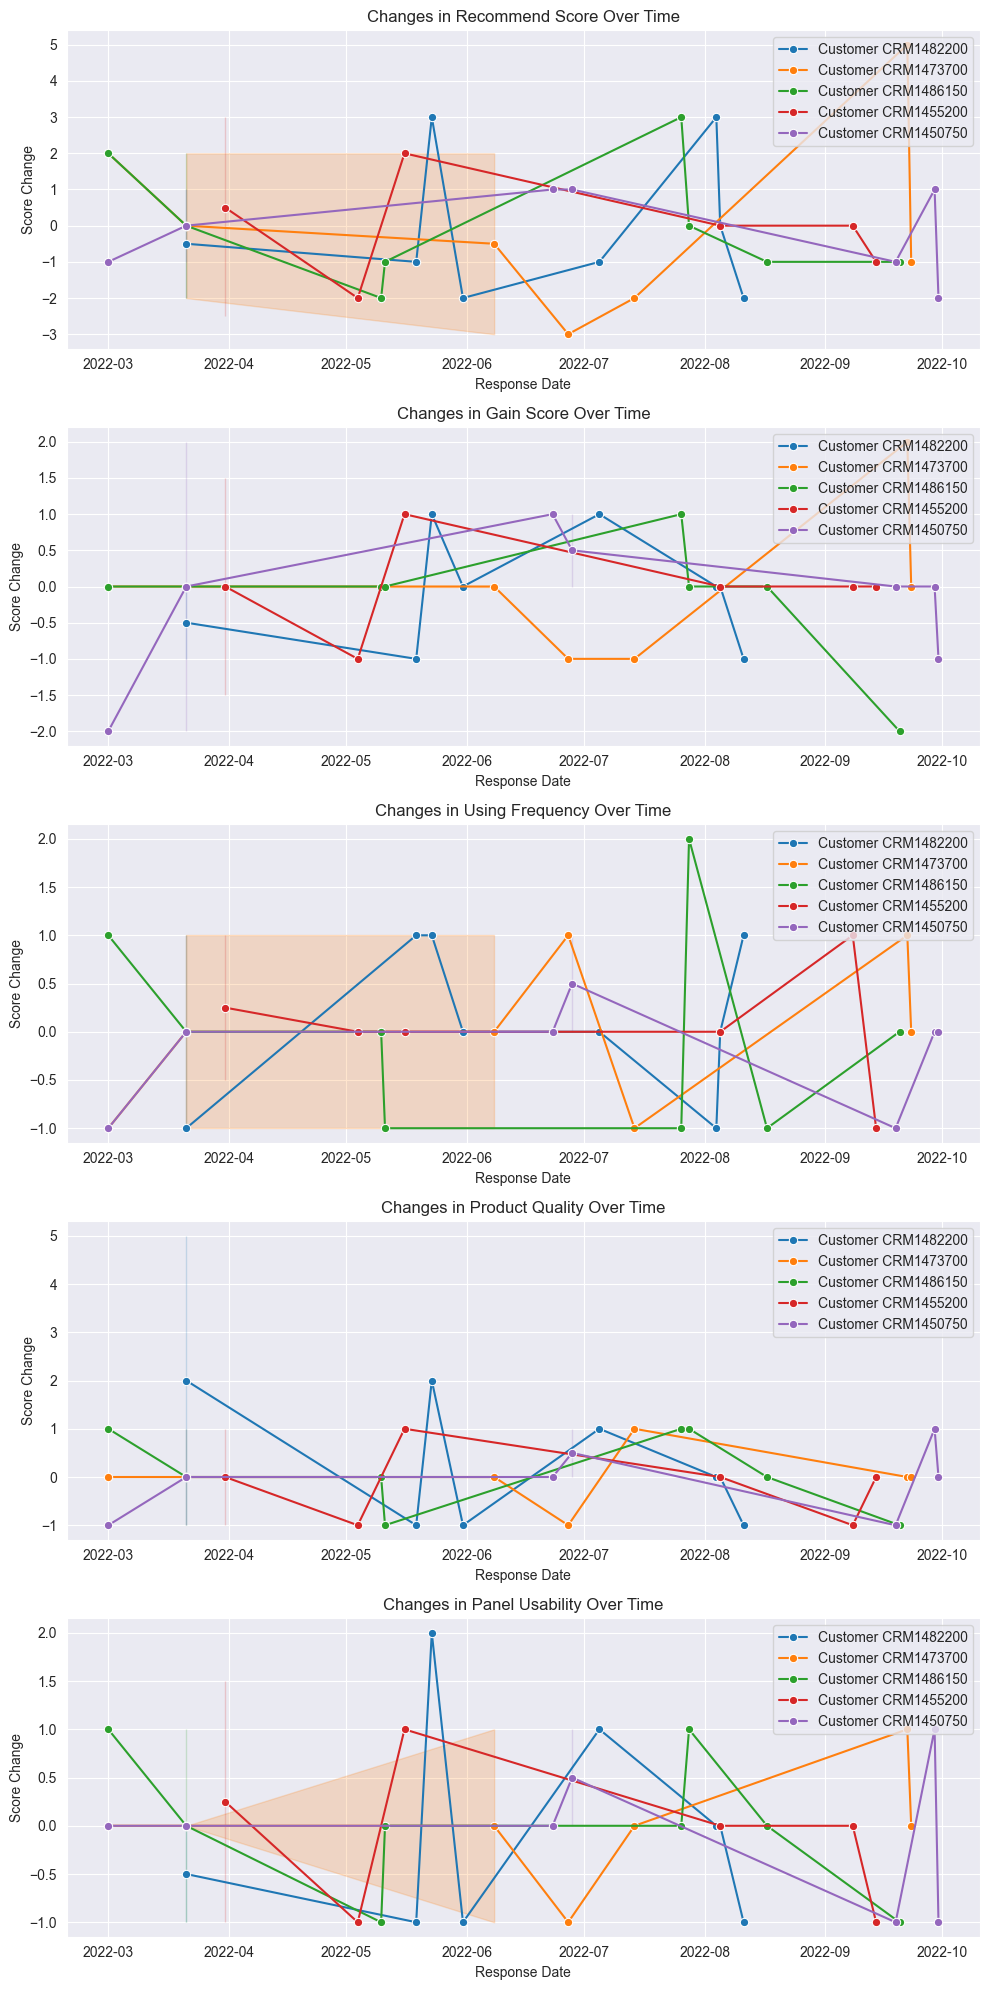

In [563]:
sample_customers = merged_df["customer_id"].value_counts().loc[lambda x: x > 1].index[:5]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

score_columns = ["recommend_score_change", "gain_score_change", "using_frequency_change", "product_quality_change", "panel_usability_change"]

for i, score in enumerate(score_columns):
    ax = axes[i]
    for customer in sample_customers:
        customer_data = merged_df[merged_df["customer_id"] == customer]
        sns.lineplot(data=customer_data, x="response_date", y=score, marker="o", label=f"Customer {customer}", ax=ax)
    
    ax.set_title(f"Changes in {score.replace('_change', '').replace('_', ' ').title()} Over Time")
    ax.set_xlabel("Response Date")
    ax.set_ylabel("Score Change")
    ax.legend(loc="best")

plt.tight_layout()
plt.show()


Burada tekrar eden customer id'leri anket cevaplarının zamana göre değişimine baktık ancak mantıklı bir sonuç göremedik.

Müşteri grubu - MRR analizi

/var/folders/g1/9n6mfv4s6mv26tyn3jvx79bw0000gn/T/ipykernel_61083/77822349.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_mrr.index, y=segment_mrr.values, palette="Blues")


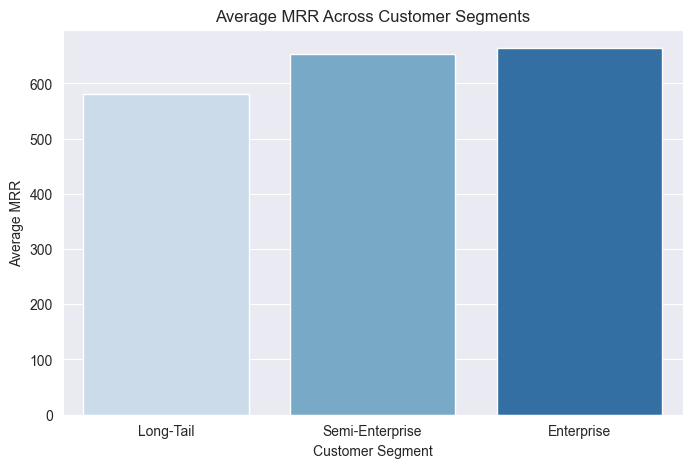

In [564]:
segment_mrr = merged_df.groupby("converted_customer_level")["mrr"].mean()

segment_labels = {0: "Long-Tail", 1: "Semi-Enterprise", 2: "Enterprise"}
segment_mrr.index = segment_mrr.index.map(segment_labels)

plt.figure(figsize=(8, 5))
sns.barplot(x=segment_mrr.index, y=segment_mrr.values, palette="Blues")
plt.title("Average MRR Across Customer Segments")
plt.xlabel("Customer Segment")
plt.ylabel("Average MRR")
plt.show()


en çok enterprise'ın mrr'a katkı sağladığını gördük
o grubu dikkate alarak cevaplarının zamana göre değişimleirne bakalım

  customer_id response_date  recommend_score  gain_score  using_frequency  \
0  CRM1002400    2022-06-10                8           4                0   
1  CRM1002400    2022-09-29               10           4                0   
2  CRM1005900           NaT                9           4                1   
6  CRM1019500    2022-05-31               10           5                2   
7  CRM1019500    2022-06-01                8           4                2   

   product_quality  panel_usability  panel_comment  age  converted_status  \
0                4                3              1   39                 2   
1                3                3              1   39                 2   
2                4                4              1   36                 2   
6                5                5              2   36                 2   
7                4                4              2   36                 2   

   ...  interaction_rate  status_category  customer_level_category  \
0  .

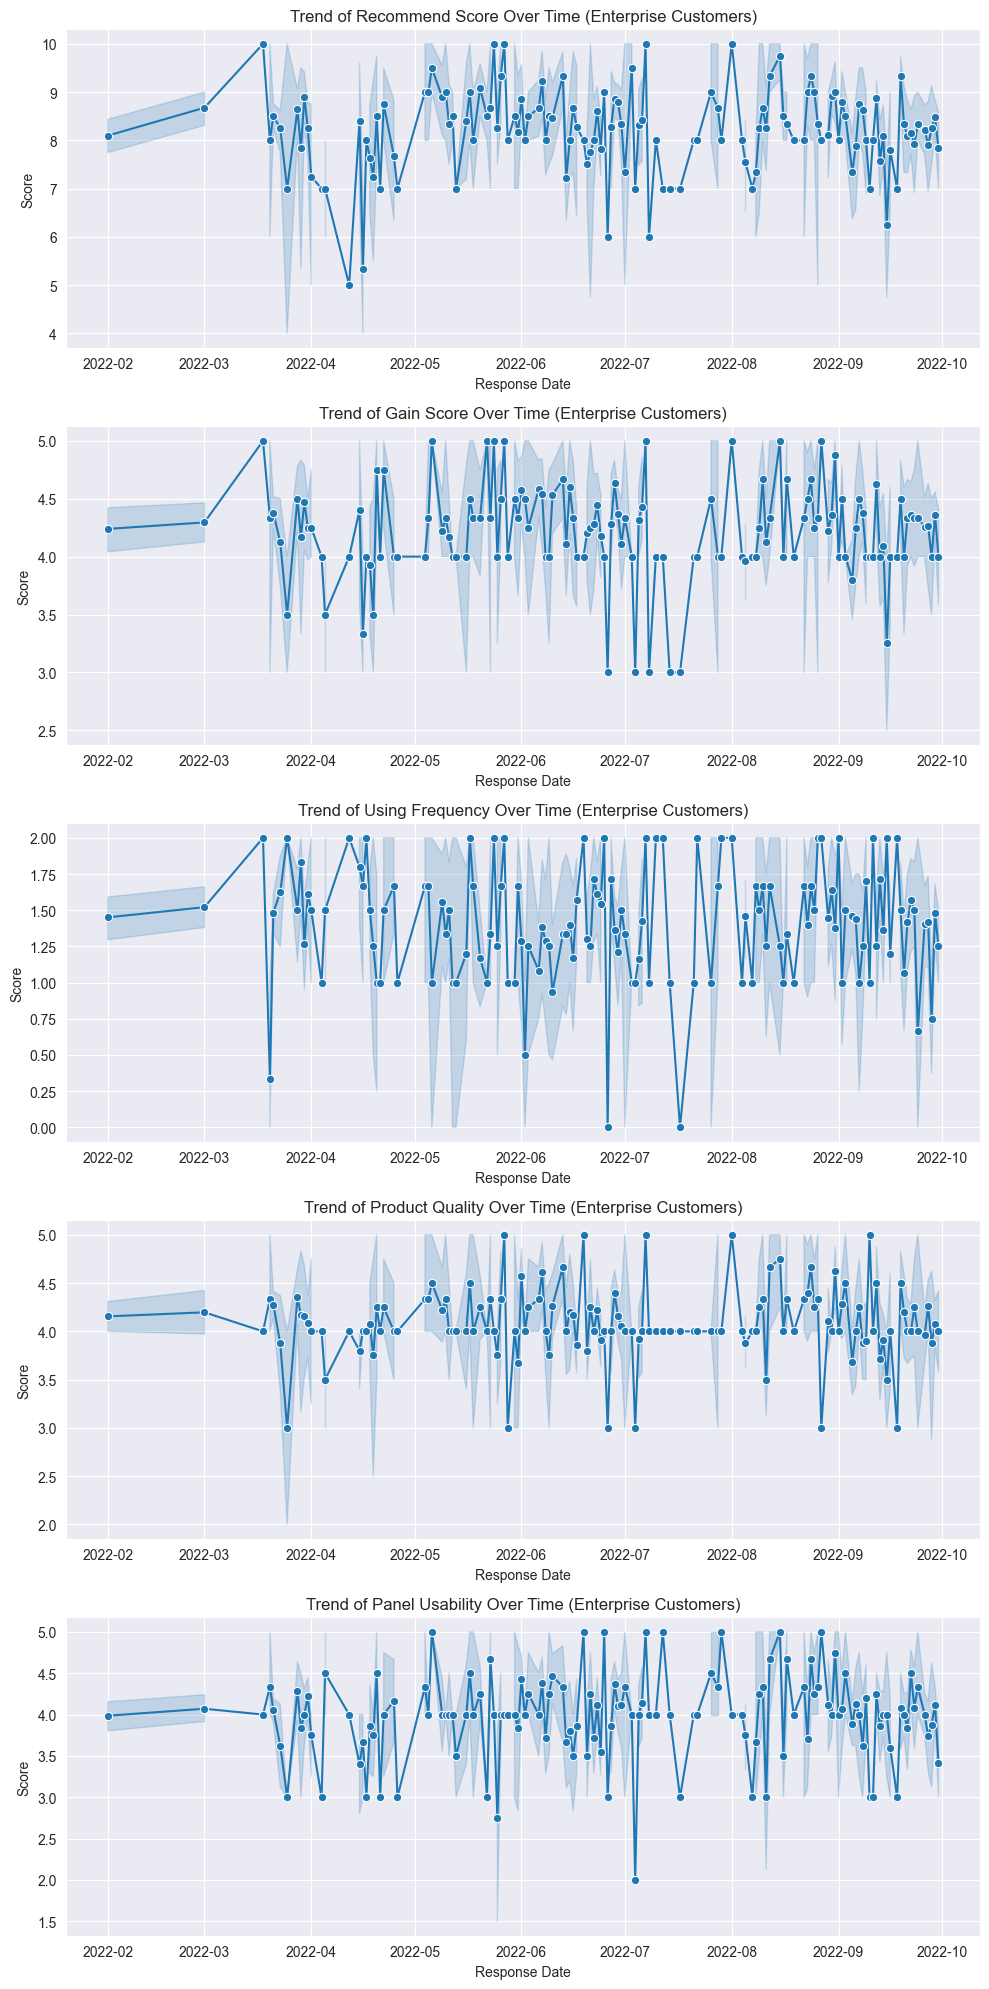

In [565]:
enterprise_df = merged_df[merged_df["converted_customer_level"] == 2]

enterprise_df["response_date"] = pd.to_datetime(enterprise_df["response_date"])

enterprise_df = enterprise_df.sort_values(by=["customer_id", "response_date"])

print(enterprise_df.head())

score_columns = ["recommend_score", "gain_score", "using_frequency", "product_quality", "panel_usability"]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

for i, score in enumerate(score_columns):
    ax = axes[i]
    sns.lineplot(data=enterprise_df, x="response_date", y=score, marker="o", ax=ax)
    ax.set_title(f"Trend of {score.replace('_', ' ').title()} Over Time (Enterprise Customers)")
    ax.set_xlabel("Response Date")
    ax.set_ylabel("Score")

plt.tight_layout()
plt.show()

Zamana bağlı burdan çok kayda değer bir şey elde edemedik. Keskin düşüşlerin olduğu zamanlardaki güncellemelere dikkat edilebilir.

### 1. Müşteri Memnuniyeti Analizi

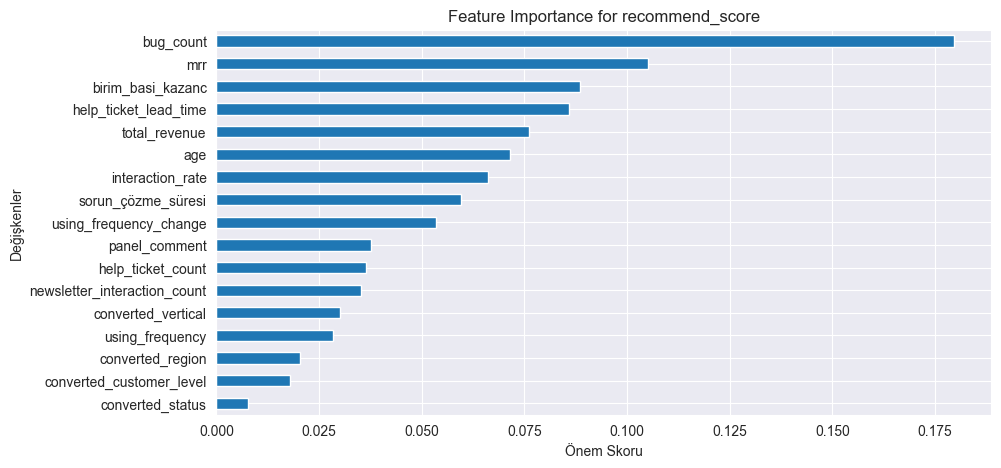

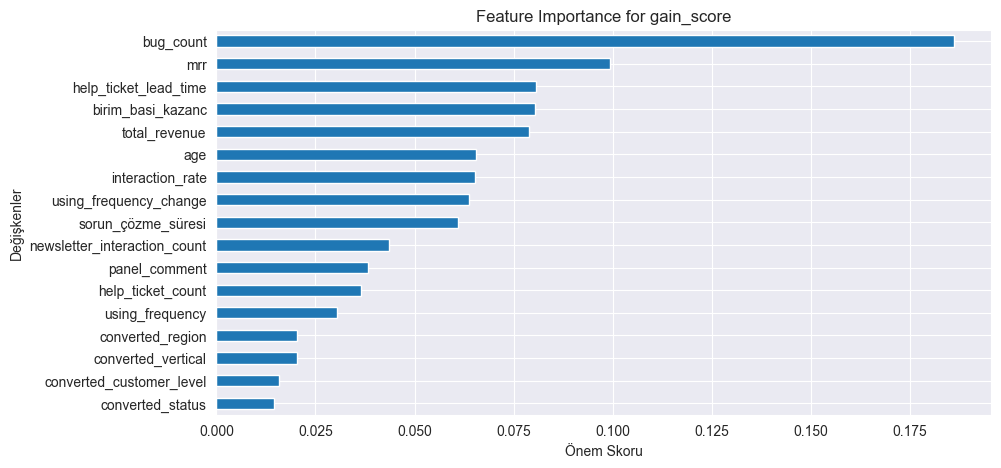

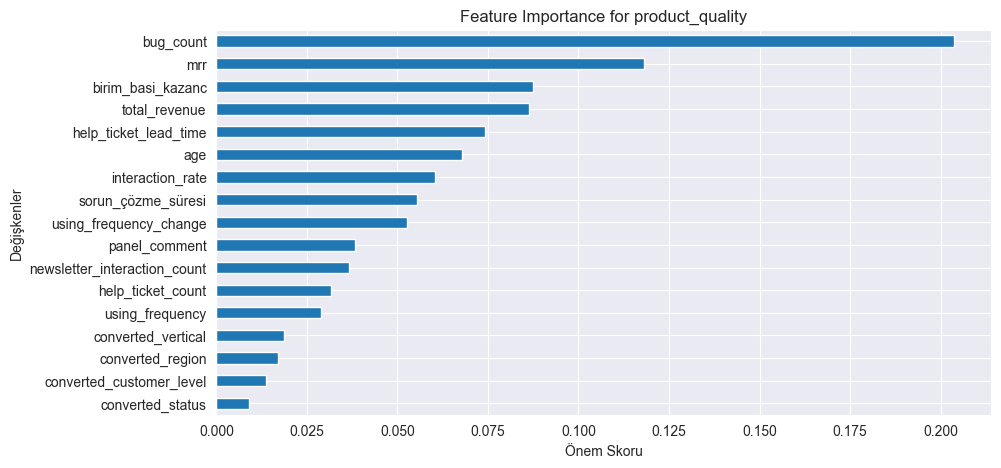

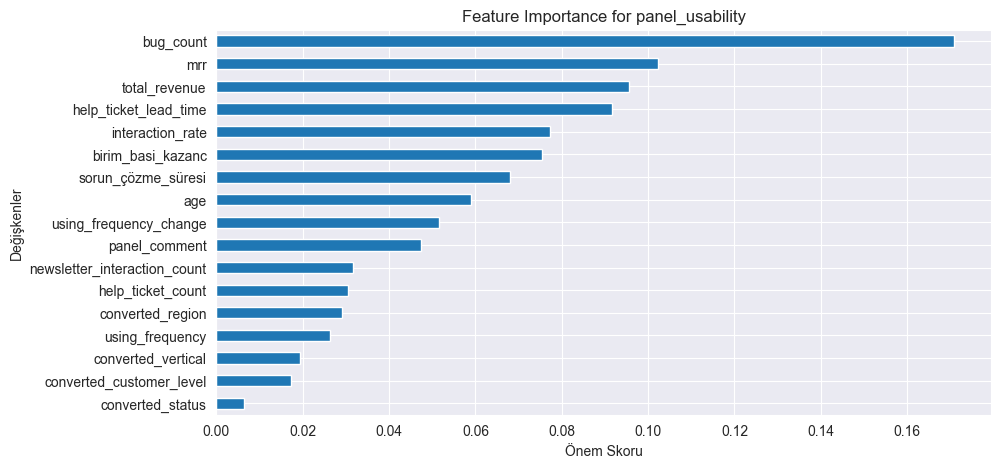

In [566]:
X = merged_df.drop(columns=['recommend_score', 'gain_score', 'product_quality', 'panel_usability', 'customer_id','response_date','recommend_score_new','gain_score_new','product_quality_new','panel_usability_new','memnuniyet_skoru','status_category', 'customer_level_category', 'region_category', 'vertical_category','recommend_score_change','gain_score_change','product_quality_change','panel_usability_change'])
y_variables = ['recommend_score', 'gain_score', 'product_quality', 'panel_usability']

feature_importances = {}

for y_col in y_variables:
    y = merged_df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    feature_importances[y_col] = rf.feature_importances_

feature_importance_df = pd.DataFrame(feature_importances, index=X.columns)
feature_importance_df = feature_importance_df.sort_values(by="recommend_score", ascending=False)

for y_col in y_variables:
    plt.figure(figsize=(10,5))
    feature_importance_df[y_col].sort_values(ascending=True).plot(kind="barh")
    plt.title(f"Feature Importance for {y_col}")
    plt.xlabel("Önem Skoru")
    plt.ylabel("Değişkenler")
    plt.show()



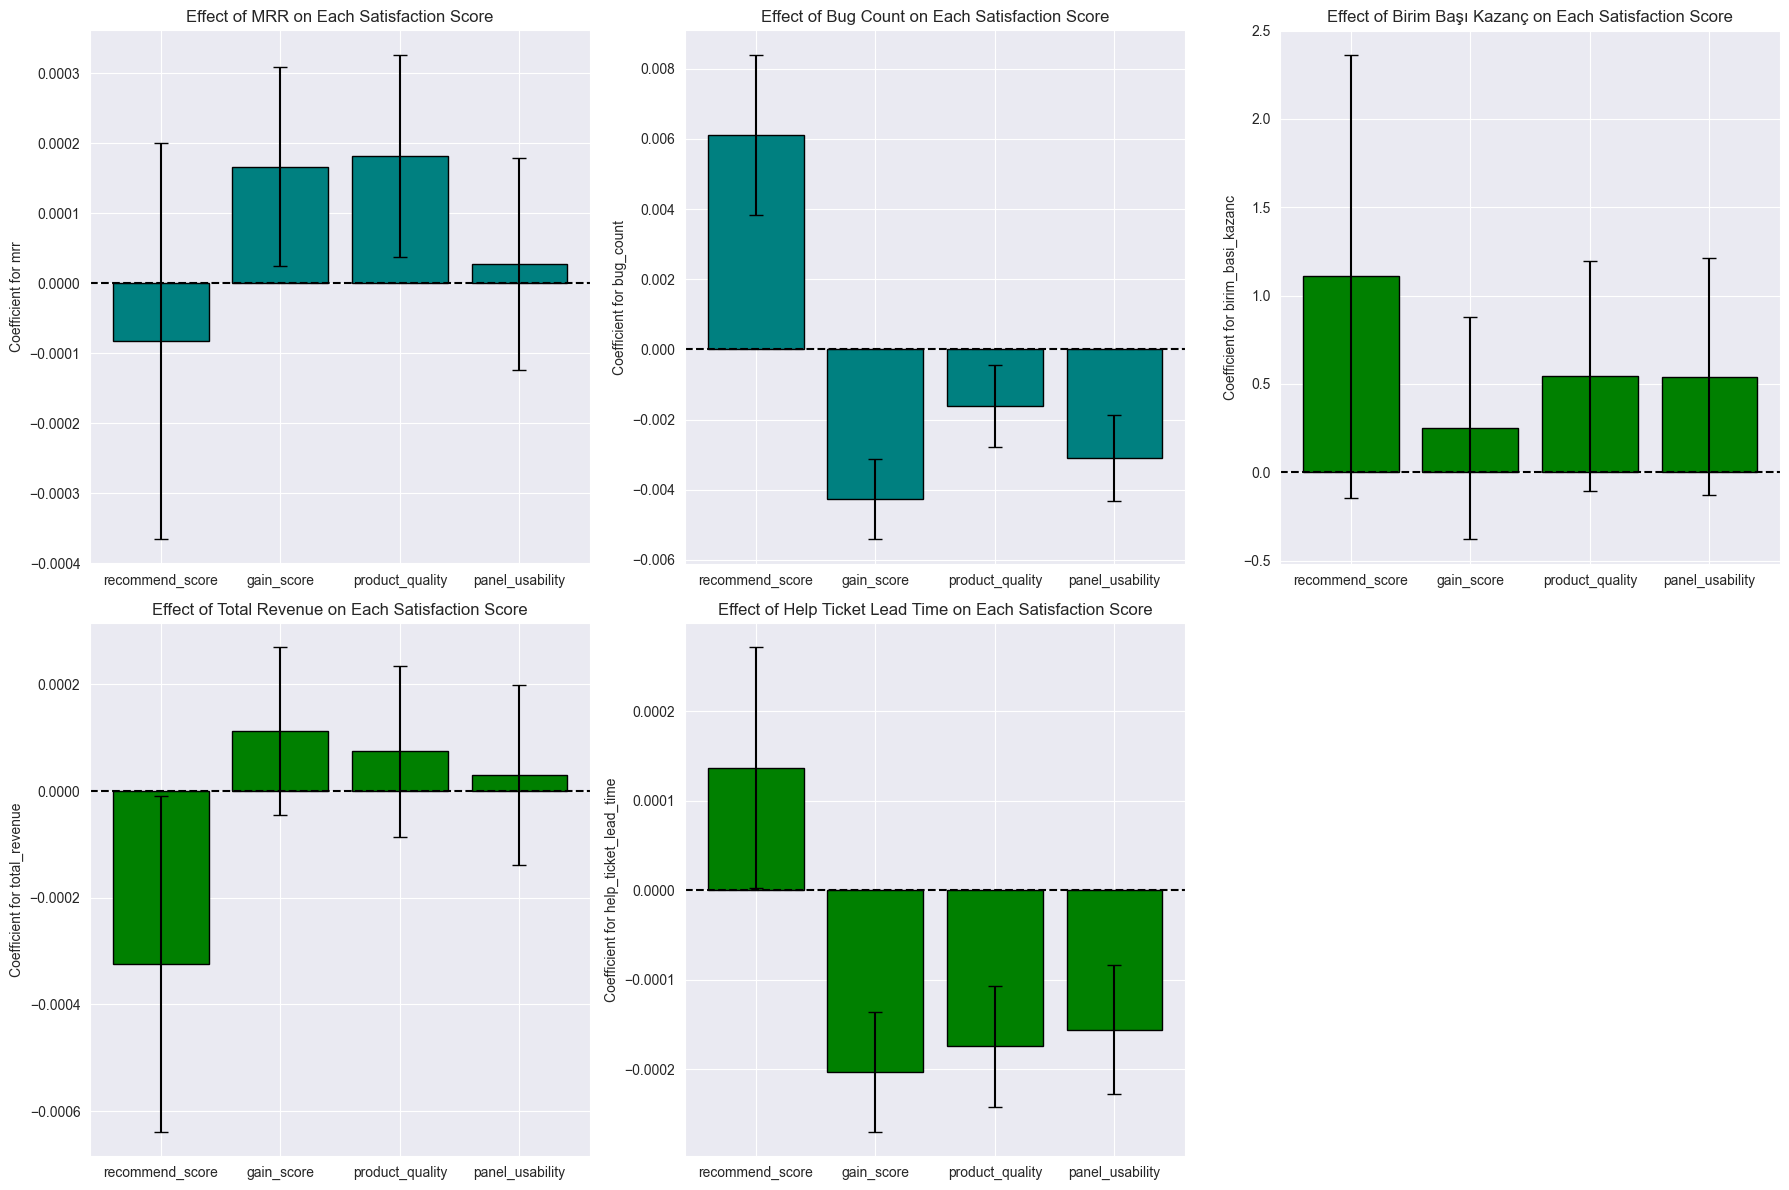

In [567]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas as pd

score_columns = ['recommend_score', 'gain_score', 'product_quality', 'panel_usability']
factors = ['mrr', 'bug_count', 'birim_basi_kazanc', 'total_revenue', 'help_ticket_lead_time']
titles = [
    "Effect of MRR on Each Satisfaction Score",
    "Effect of Bug Count on Each Satisfaction Score",
    "Effect of Birim Başı Kazanç on Each Satisfaction Score",
    "Effect of Total Revenue on Each Satisfaction Score",
    "Effect of Help Ticket Lead Time on Each Satisfaction Score"
]
colors = ['teal', 'teal', 'green', 'green', 'green']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 satır, 3 sütun

for i, (factor, title, color) in enumerate(zip(factors, titles, colors)):
    results_list = []

    for score in score_columns:
        formula = f"{score} ~ {factor}"
        model = smf.mixedlm(formula, merged_df, groups=merged_df["customer_id"])
        result = model.fit()

        coef = result.params[factor]
        ci_lower, ci_upper = result.conf_int().loc[factor]

        results_list.append({
            'score': score,
            'coef': coef,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })

    df_results = pd.DataFrame(results_list)

    row, col = divmod(i, 3)
    axes[row, col].bar(
        df_results['score'],
        df_results['coef'],
        yerr=[
            df_results['coef'] - df_results['ci_lower'],
            df_results['ci_upper'] - df_results['coef']
        ],
        capsize=5,
        color=color,
        edgecolor='black'
    )

    axes[row, col].axhline(0, color='black', linestyle='--')
    axes[row, col].set_ylabel(f"Coefficient for {factor}")
    axes[row, col].set_title(title)

# Boş kalan son plotu silme işlemi
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


Negatif Etkiler:
* Bug Count (Hata Sayısı)  → Hatalar arttıkça tüm memnuniyet skorları düşüyor.
* Help Ticket Lead Time (Yardım Bileti Çözüm Süresi)  → Destek taleplerinin uzun sürede çözülmesi, memnuniyeti azaltıyor.
* Total Revenue (Toplam Gelir)  → İlginç bir şekilde, daha fazla gelir elde eden müşterilerin memnuniyet skoru düşebiliyor. Bu, belki de daha fazla ödeme yapan müşterilerin beklentilerinin daha yüksek olduğunu ve karşılanmadığında hayal kırıklığı yaşadıklarını gösteriyor.

Pozitif Etkiler:
* MRR (Aylık Tekrarlayan Gelir)  → Memnuniyet skorları ile genellikle pozitif ilişkiye sahip. Düzenli ödeme yapan müşteriler, genellikle daha uzun süre sistemde kalıyor ve ürün değerini daha fazla algılıyor.
* Birim Başı Kazanç (Profit Per Unit) → Müşterinin yatırımına karşı elde ettiği kazanç ne kadar yüksekse, memnuniyet o kadar artıyor.

### Müşteri bağlılığı analizi

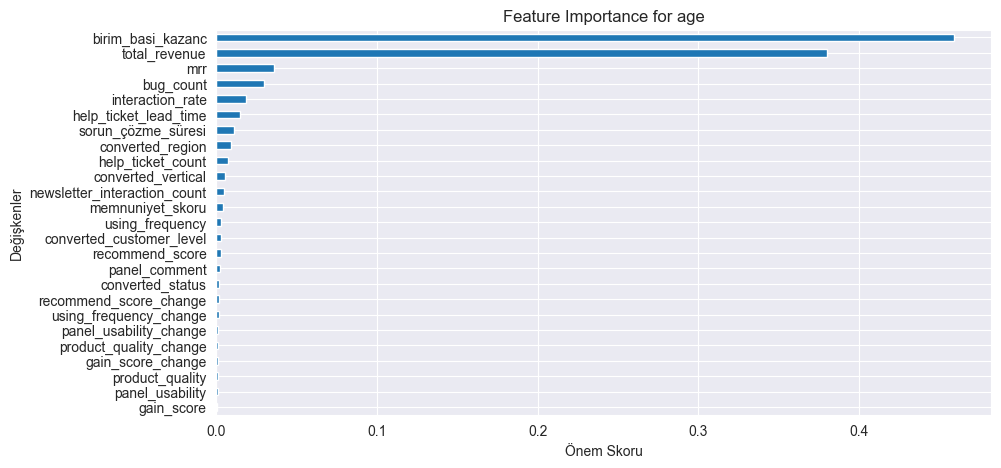

In [568]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = merged_df.drop(columns=[ 'age','customer_id','response_date','recommend_score_new','gain_score_new','product_quality_new','panel_usability_new','status_category', 'customer_level_category', 'region_category', 'vertical_category'])
y_variables = ['age']

feature_importances = {}

for y_col in y_variables:
    y = merged_df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    feature_importances[y_col] = rf.feature_importances_

feature_importance_df = pd.DataFrame(feature_importances, index=X.columns)

for y_col in y_variables:
    plt.figure(figsize=(10,5))
    feature_importance_df[y_col].sort_values(ascending=True).plot(kind="barh")
    plt.title(f"Feature Importance for {y_col}")
    plt.xlabel("Önem Skoru")
    plt.ylabel("Değişkenler")
    plt.show()



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is depr

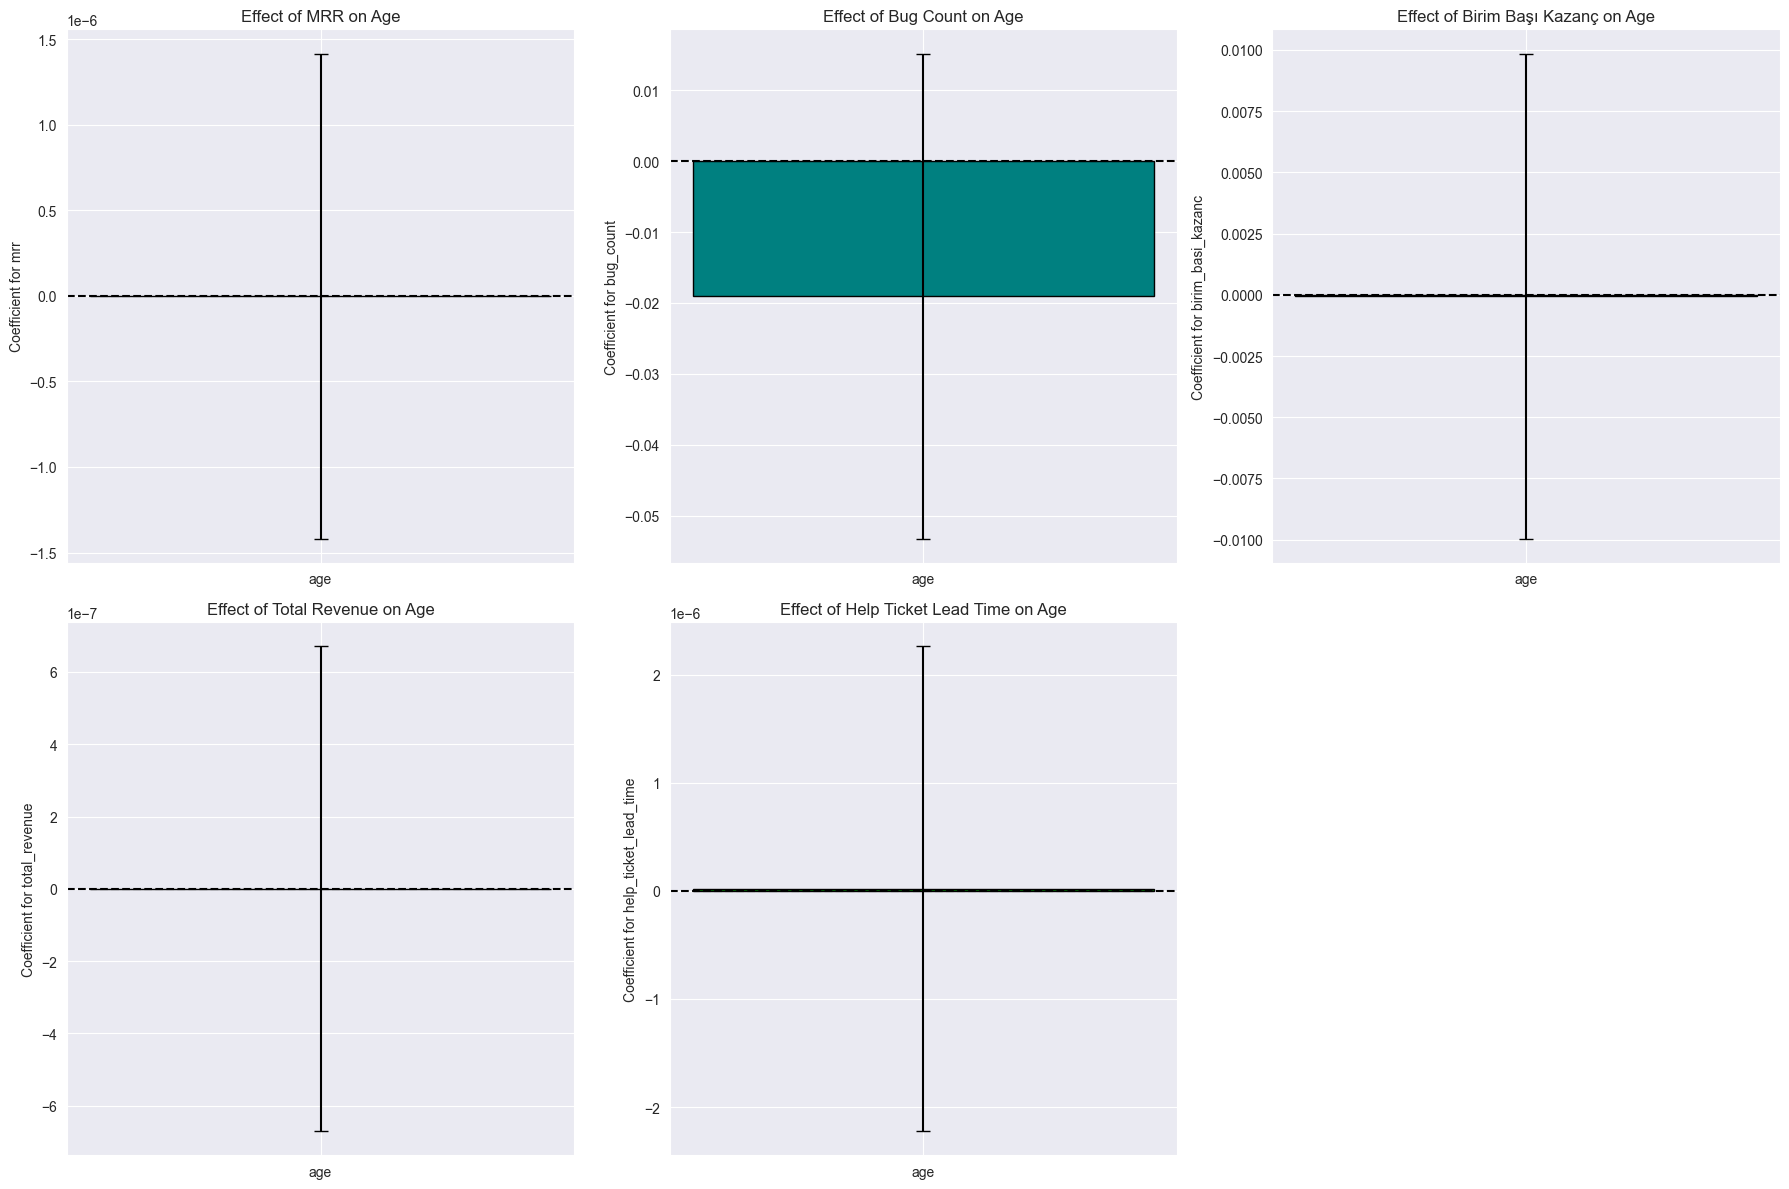

In [569]:
score_columns = ['age']
factors = ['mrr', 'bug_count', 'birim_basi_kazanc', 'total_revenue', 'help_ticket_lead_time', 'sorun_çözülme_süresi']
titles = [
    "Effect of MRR on Age",
    "Effect of Bug Count on Age",
    "Effect of Birim Başı Kazanç on Age",
    "Effect of Total Revenue on Age",
    "Effect of Help Ticket Lead Time on Age",
    "Effect of Sorun Çözülme Süresi on Age"
]
colors = ['teal', 'teal', 'green', 'green', 'green']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (factor, title, color) in enumerate(zip(factors, titles, colors)):
    results_list = []

    for score in score_columns:
        formula = f"{score} ~ {factor}"
        model = smf.mixedlm(formula, merged_df, groups=merged_df["customer_id"])
        result = model.fit()

        coef = result.params[factor]
        ci_lower, ci_upper = float(result.conf_int().loc[factor].iloc[0]), float(result.conf_int().loc[factor].iloc[1])


        results_list.append({
            'score': score,
            'coef': coef,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })

    df_results = pd.DataFrame(results_list)

    row, col = divmod(i, 3)
    axes[row, col].bar(
        df_results['score'],
        df_results['coef'],
        yerr=[
            df_results['coef'] - df_results['ci_lower'],
            df_results['ci_upper'] - df_results['coef']
        ],
        capsize=5,
        color=color,
        edgecolor='black'
    )

    axes[row, col].axhline(0, color='black', linestyle='--')
    axes[row, col].set_ylabel(f"Coefficient for {factor}")
    axes[row, col].set_title(title)

fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


Pozitif Etkiler:

* MRR (Aylık Tekrarlayan Gelir): Müşterilerin düzenli ödeme yapması, genellikle üründen uzun vadede memnun kalmalarıyla ilişkili.
* Birim Başı Kazanç: Müşterinin yaptığı yatırım karşılığında elde ettiği getiri arttıkça memnuniyet de artıyor.

Negatif Etkiler:

* Bug Count (Hata Sayısı): Artan hata sayısı, kullanıcı deneyimini olumsuz etkileyerek memnuniyet skorlarını düşürüyor.
* Help Ticket Lead Time (Yardım Bileti Çözüm Süresi): Destek taleplerinin geç çözülmesi, müşterilerin memnuniyetini azaltıyor.
* Total Revenue (Toplam Gelir): Geliri yüksek müşteriler, daha yüksek beklentilere sahip olduğundan bu beklentiler karşılanmadığında memnuniyetsizlik artabiliyor.

### Müşteri kaybı analizi

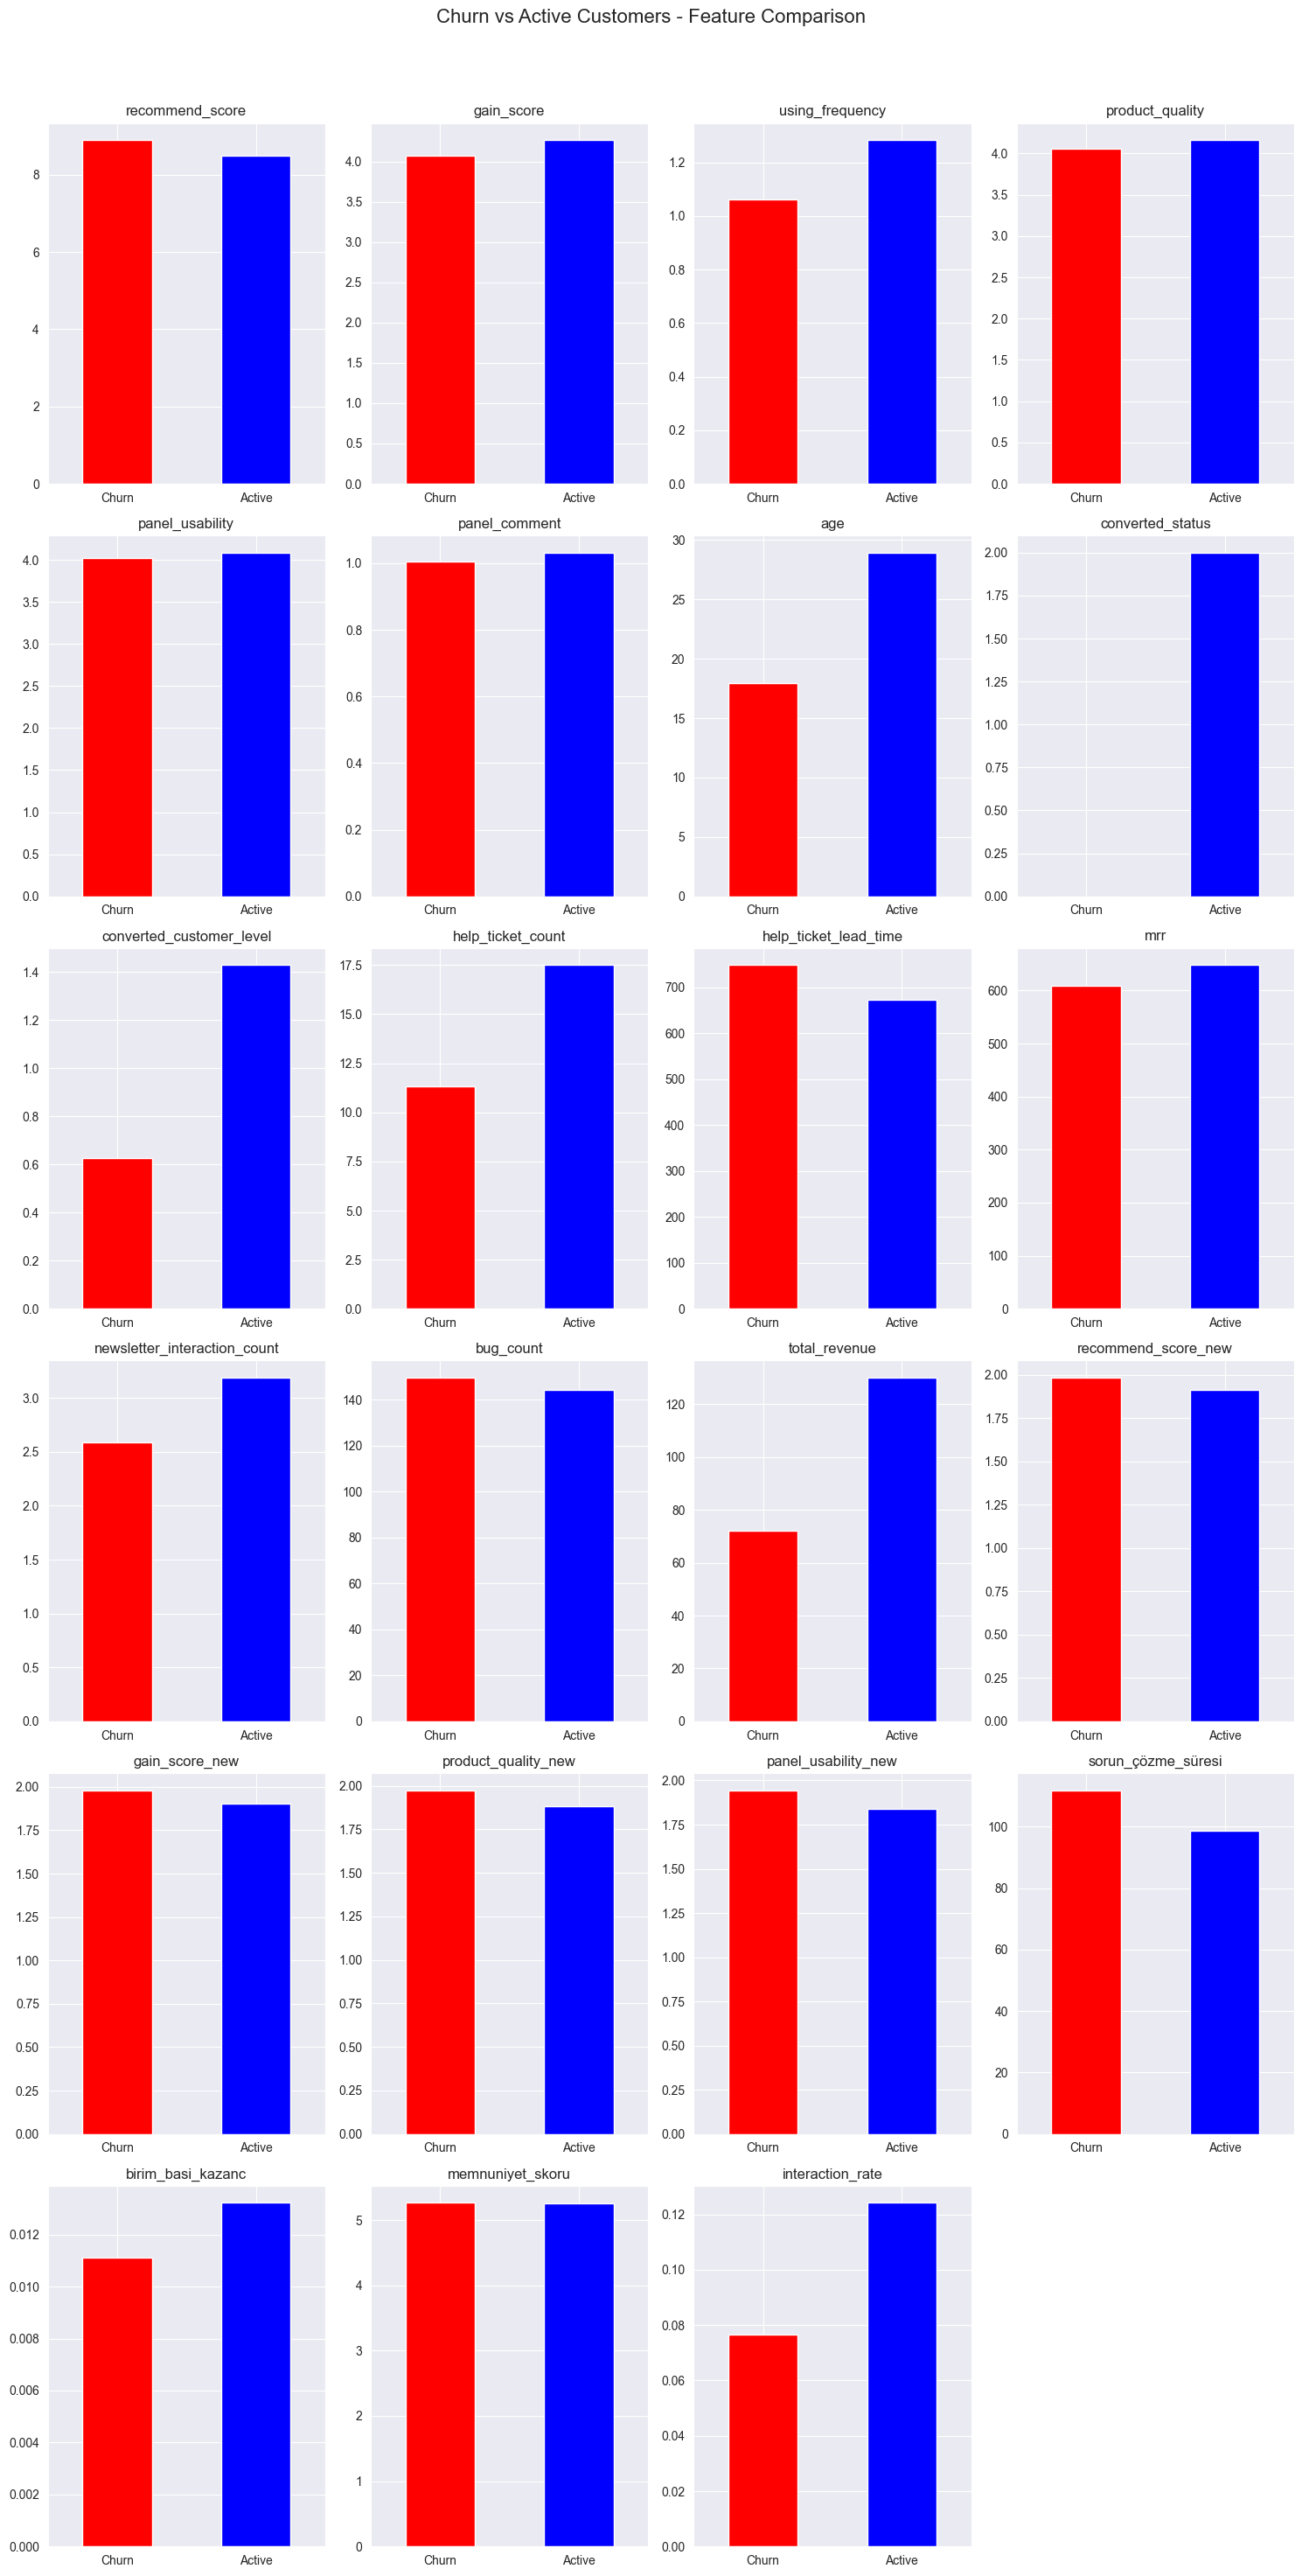

In [570]:
df = merged_df.drop(columns= ['customer_id','response_date','converted_vertical','converted_region','status_category',
'customer_level_category', 'region_category', 'vertical_category','recommend_score_change','gain_score_change','product_quality_change','using_frequency_change','panel_usability_change'], axis=1)

churn_df = df[df['converted_status'] == 0]
active_df = df[df['converted_status'] == 2]

summary_stats = pd.concat([
    churn_df.describe().T.rename(columns={'mean': 'Churn Mean'}),
    active_df.describe().T.rename(columns={'mean': 'Active Mean'})
], axis=1)

comparison_df = summary_stats[['Churn Mean', 'Active Mean']]

num_features = len(comparison_df)
cols = 4
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
fig.suptitle("Churn vs Active Customers - Feature Comparison", fontsize=16)

for i, feature in enumerate(comparison_df.index):
    row = i // cols
    col = i % cols
    ax = axes[row, col]

    comparison_df.loc[feature].plot(kind='bar', ax=ax, color=["red", "blue"])
    ax.set_title(feature)
    ax.set_xticklabels(["Churn", "Active"], rotation=0)

for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



Churned (ayrılan) ve active(aktif) müşterilerin özelliklerinin meanlerini karşılaştırdık. Müşterilerin neden ayrılmaya karar verdiklerini anlamamız için yardımcı olabileceğini düşündük. Aktif müşteriler daha yüksek kullanım sıklığı, kazanç puanı, ürün kalitesi, müşteri seviyesine sahip ve çok daha uzun süre şirketle çalışmışlar. Aynı zamanda aktif müşterilerin etkileşimleri, total revenueları ve MRRları daha fazla.

Ayrılan müşterilerin destek çözüm süreleri daha uzun ve daha fazla hata bildiriyorlar. Ayrıca gain_score_new ve product_quality_new ayrılan müşterilerde daha yüksek.

Bu yüzden destek çözüm süresini kısaltma, hata sayısını azaltma ve üşterilerin etkileşimini arttırmak mantıklı olabilir.

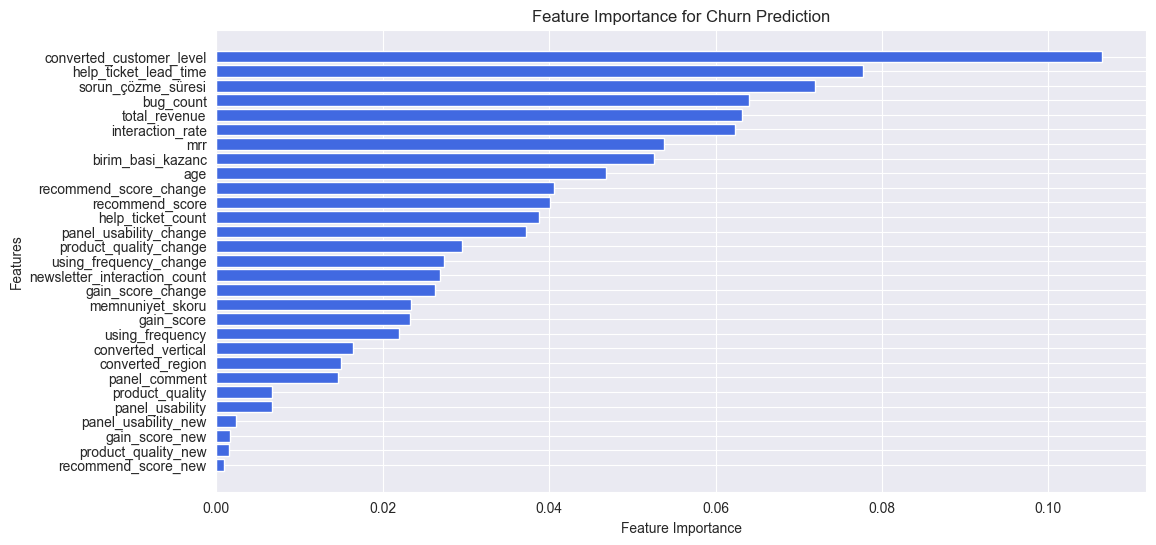

In [571]:
df_churn = merged_df[merged_df['converted_status'].isin([0, 2])]

X = df_churn.drop(columns=['converted_status', 'customer_id', 'response_date','status_category', 'customer_level_category', 'region_category', 'vertical_category'])
y = df_churn['converted_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Churn Prediction")
plt.gca().invert_yaxis()
plt.show()



Sonra müşteri kaybı tahmini için random forest sınıflandırması yaparak özelliklerin önem derecesini sınıflandırdık.

Açık ara en önemli faktör converted_customer_level, bunun yanı sıra help_ticket_lead_time, sorun_cozme_suresi, bug_count kritik. etkileri önemli yani.

total_revenue, total_revenue, mrr, birim_basi_kazanc orta düzeyde etkiliyor ve skor değişimlerini gösteren ⁠ _change ⁠ özellikleri, vertical ve region ⁠ _new ⁠ ile biten özellikler çok daha az etkiliyor

Finansal faktörler önemli ama hizmet kalitesi ve hızı kadar önemli değil.

### MRR ve Total Revenue Analizi

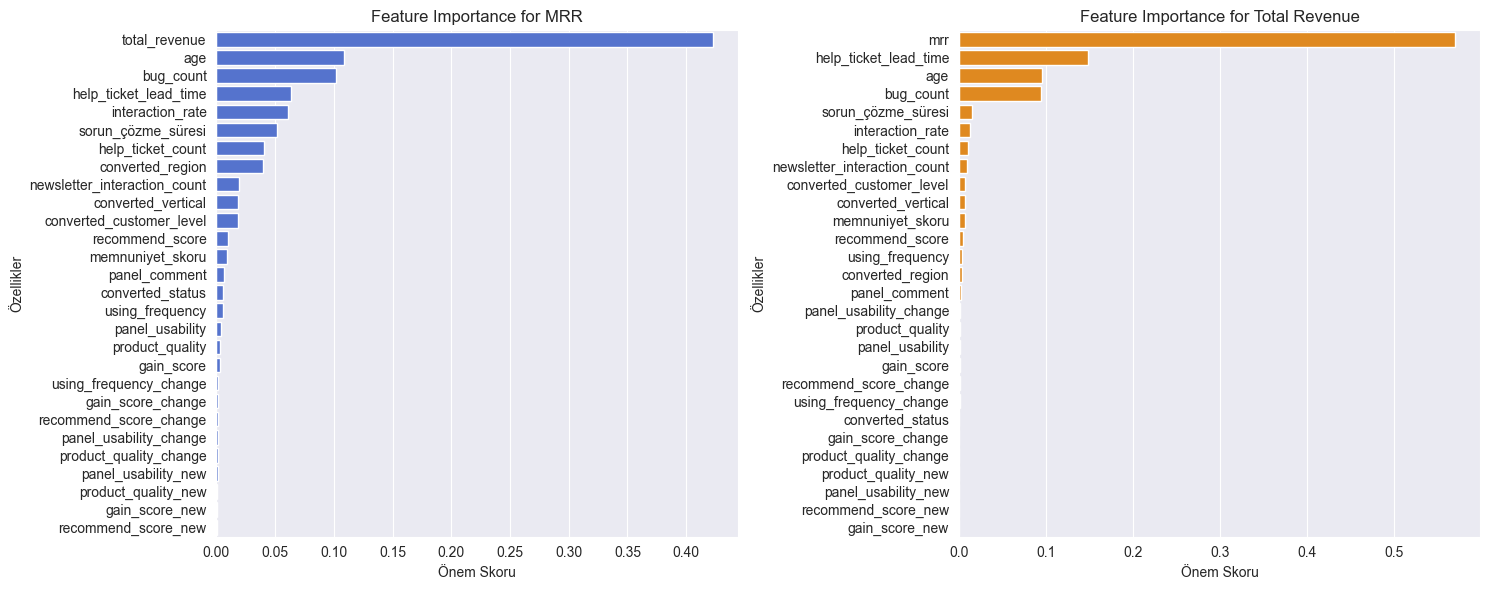

In [572]:
X_mrr = merged_df.drop(columns=['mrr', 'customer_id', 'response_date', 'birim_basi_kazanc','status_category', 'customer_level_category', 'region_category', 'vertical_category'])
X_revenue = merged_df.drop(columns=['total_revenue', 'customer_id', 'response_date', 'birim_basi_kazanc','status_category', 'customer_level_category', 'region_category', 'vertical_category'])
y_mrr = merged_df['mrr']
y_total_revenue = merged_df['total_revenue']

rf_mrr = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mrr.fit(X_mrr, y_mrr)

rf_revenue = RandomForestRegressor(n_estimators=100, random_state=42)
rf_revenue.fit(X_revenue, y_total_revenue)

importances_mrr = pd.DataFrame({'Feature': X_mrr.columns, 'Importance': rf_mrr.feature_importances_}).sort_values(by='Importance', ascending=False)
importances_revenue = pd.DataFrame({'Feature': X_revenue.columns, 'Importance': rf_revenue.feature_importances_}).sort_values(by='Importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(y=importances_mrr['Feature'], x=importances_mrr['Importance'], ax=axes[0], color='royalblue')
axes[0].set_title("Feature Importance for MRR")
axes[0].set_xlabel("Önem Skoru")
axes[0].set_ylabel("Özellikler")

sns.barplot(y=importances_revenue['Feature'], x=importances_revenue['Importance'], ax=axes[1], color='darkorange')
axes[1].set_title("Feature Importance for Total Revenue")
axes[1].set_xlabel("Önem Skoru")
axes[1].set_ylabel("Özellikler")

plt.tight_layout()
plt.show()


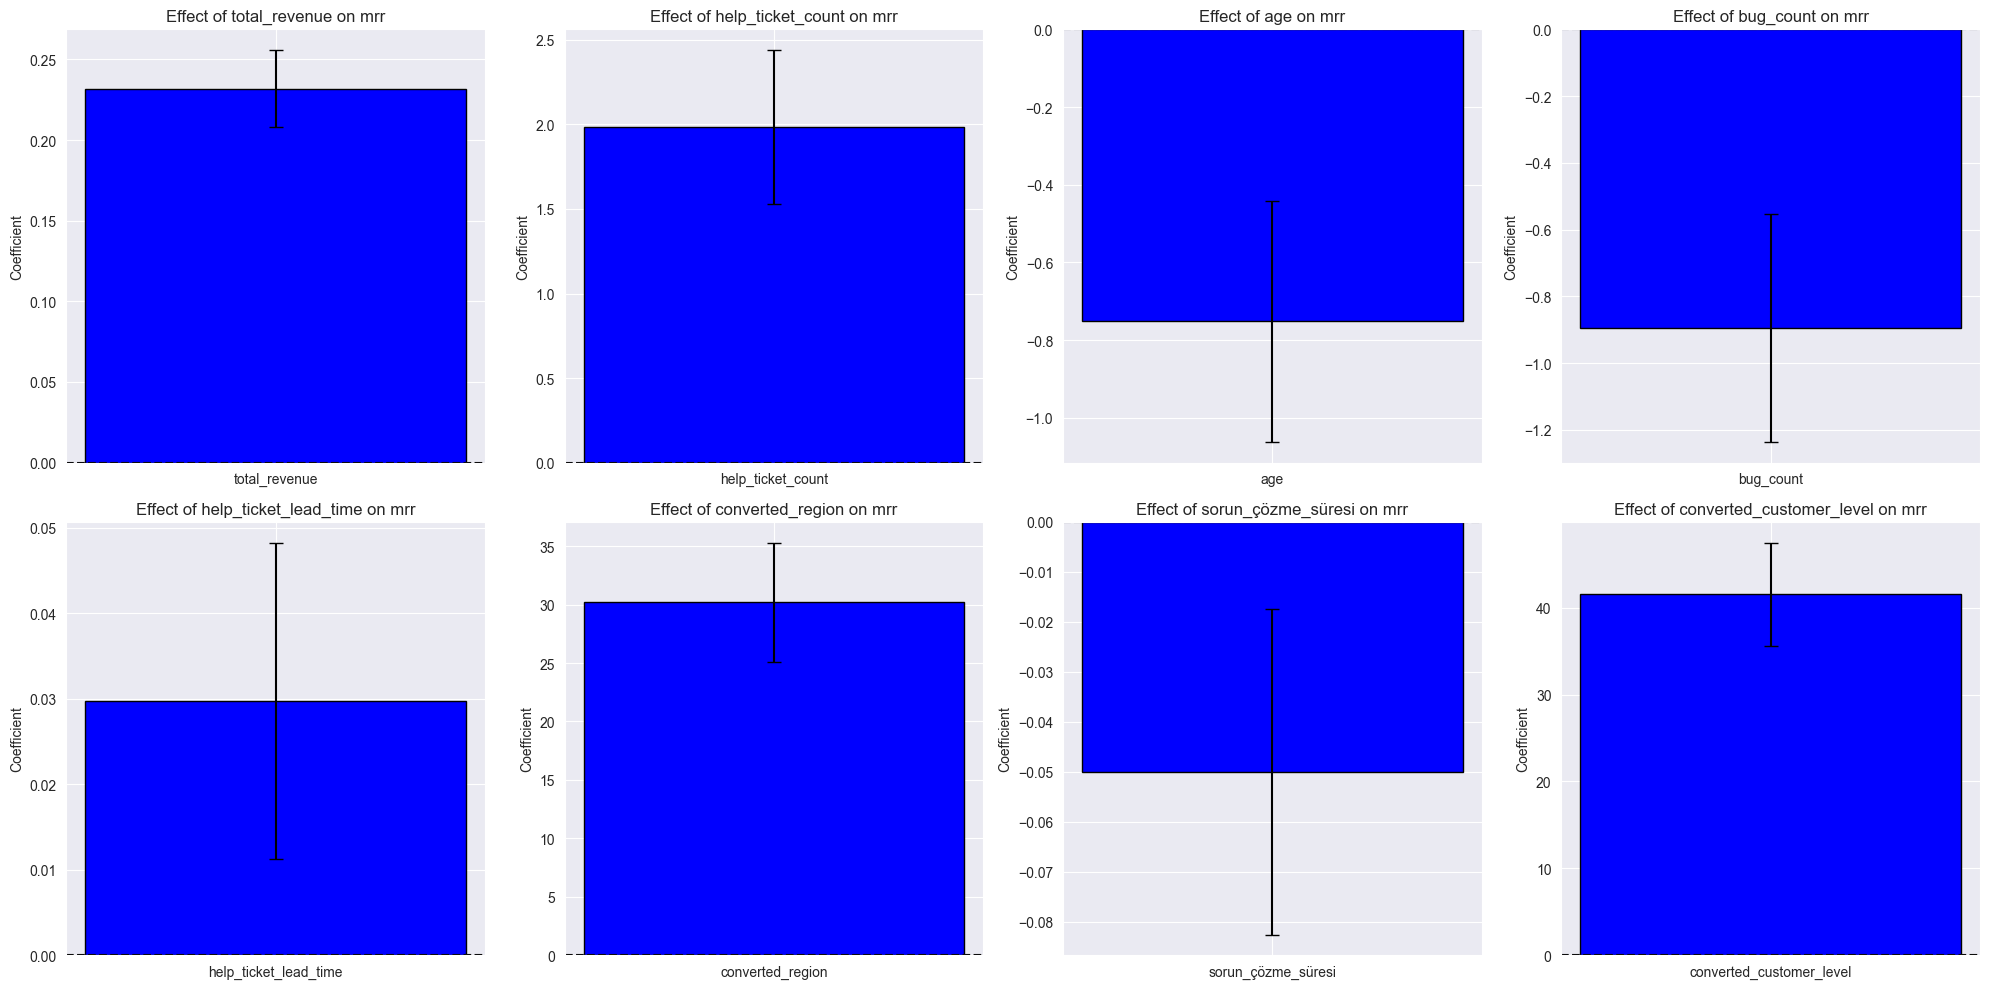

In [573]:
# İncelenecek faktörler
factors = ['total_revenue',"help_ticket_count", "age", "bug_count", "help_ticket_lead_time",
           "converted_region", "sorun_çözme_süresi", "converted_customer_level"]

titles = [
    "Effect of total_revenue on mrr",
    "Effect of help_ticket_count on mrr",
    "Effect of age on mrr",
    "Effect of bug_count on mrr",
    "Effect of help_ticket_lead_time on mrr",
    "Effect of converted_region on mrr",
    "Effect of sorun_çözme_süresi on mrr",
    "Effect of converted_customer_level on mrr"
]

colors = ['blue'] * len(factors)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, (factor, title, color) in enumerate(zip(factors, titles, colors)):
    formula = f"mrr ~ {factor}"
    model = smf.mixedlm(formula, merged_df, groups=merged_df["customer_id"])
    result = model.fit()

    coef = result.params[factor]
    ci_lower, ci_upper = result.conf_int().loc[factor]

    error_lower = coef - ci_lower
    error_upper = ci_upper - coef

    ax = axes[i]
    ax.bar(factor, coef, yerr=[[error_lower], [error_upper]], capsize=5, color=color, edgecolor='black')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_ylabel("Coefficient")
    ax.set_title(title)

if len(axes) > len(factors):
    for j in range(len(factors), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


 MRR (Aylık Tekrarlayan Gelir) İçin Önemli Faktörler:
* Total Revenue → MRR ile güçlü bir pozitif ilişki var. Daha yüksek toplam gelir, düzenli ödemeleri artırıyor.
* Yaş (Customer Age)  → Uzun süredir sistemde olan müşteriler genellikle daha fazla ödeme yapıyor.
* Bug Count  → Üründeki hata sayısının artması MRR'yi olumsuz etkiliyor. Daha az hata, daha fazla güvenilirlik getiriyor.
* Help Ticket Lead Time → Sorunların geç çözülmesi, MRR üzerinde negatif etki yapıyor. Destek süreci hızlandırılmalı.
* Interaction Rate → Platformla daha fazla etkileşimde bulunan müşteriler daha sadık ve düzenli ödeme yapıyor.

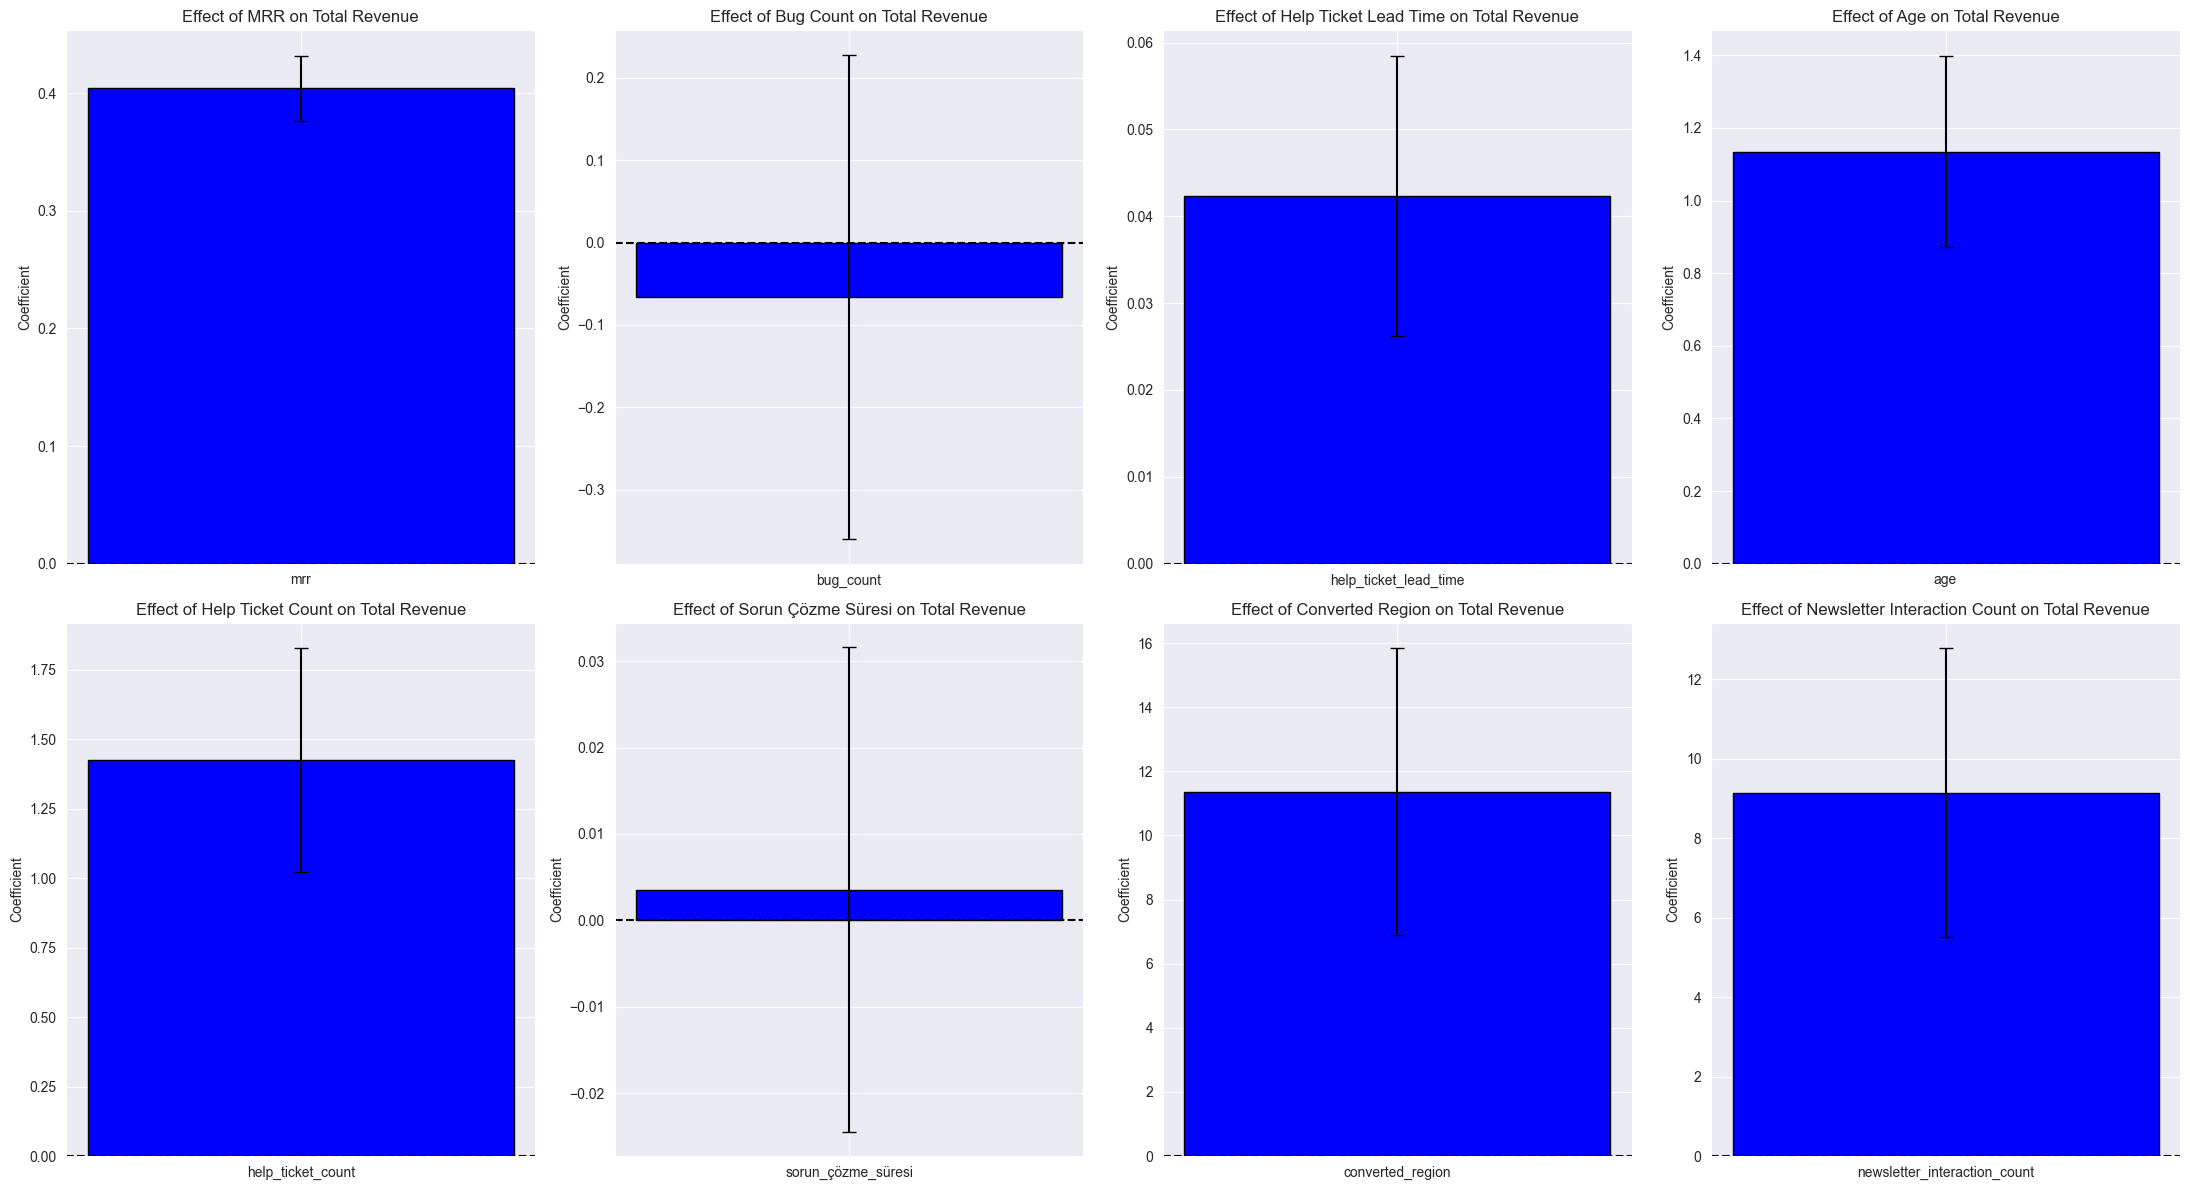

In [574]:
factors = [
    "mrr","bug_count", "help_ticket_lead_time", "age",
    "help_ticket_count", "sorun_çözme_süresi", "converted_region",
    "newsletter_interaction_count"
]

titles = [
    "Effect of MRR on Total Revenue",
    "Effect of Bug Count on Total Revenue",
    "Effect of Help Ticket Lead Time on Total Revenue",
    "Effect of Age on Total Revenue",
    "Effect of Help Ticket Count on Total Revenue",
    "Effect of Sorun Çözme Süresi on Total Revenue",
    "Effect of Converted Region on Total Revenue",
    "Effect of Newsletter Interaction Count on Total Revenue"
]

colors = ['blue'] * len(factors)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 12))
axes = axes.flatten()

for i, (factor, title, color) in enumerate(zip(factors, titles, colors)):
    formula = f"total_revenue ~ {factor}"
    model = smf.mixedlm(formula, merged_df, groups=merged_df["customer_id"])
    result = model.fit()

    coef = result.params[factor]
    ci_lower, ci_upper = result.conf_int().loc[factor]

    error_lower = coef - ci_lower
    error_upper = ci_upper - coef

    ax = axes[i]
    ax.bar(factor, coef, yerr=[[error_lower], [error_upper]], capsize=5, color=color, edgecolor='black')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_ylabel("Coefficient")
    ax.set_title(title)

if len(axes) > len(factors):
    for j in range(len(factors), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Total Revenue (Toplam Gelir) İçin Önemli Faktörler:

* MRR  → Düzenli ödeme yapan müşterilerin toplam gelir üzerinde doğrudan etkisi var.
* Help Ticket Lead Time  → Destek süreçlerinin uzaması, müşteri harcamalarını azaltıyor.
* Yaş (Customer Age)  → Daha eski müşteriler daha fazla gelir getiriyor.
* Bug Count  → Üründeki hataların fazlalığı, müşteri harcamalarını düşürüyor.
* Interaction Rate  → Platformu aktif kullanan müşteriler daha fazla yatırım yapıyor.


### Region Analizi

/var/folders/g1/9n6mfv4s6mv26tyn3jvx79bw0000gn/T/ipykernel_61083/217682946.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Region", y="mrr", data=region_comparison, ax=axes[0], palette="Blues")
/var/folders/g1/9n6mfv4s6mv26tyn3jvx79bw0000gn/T/ipykernel_61083/217682946.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Region", y="total_revenue", data=region_comparison, ax=axes[1], palette="Greens")
/var/folders/g1/9n6mfv4s6mv26tyn3jvx79bw0000gn/T/ipykernel_61083/217682946.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="R

ValueError: Could not interpret value `birim_basina_kazanc` for `y`. An entry with this name does not appear in `data`.

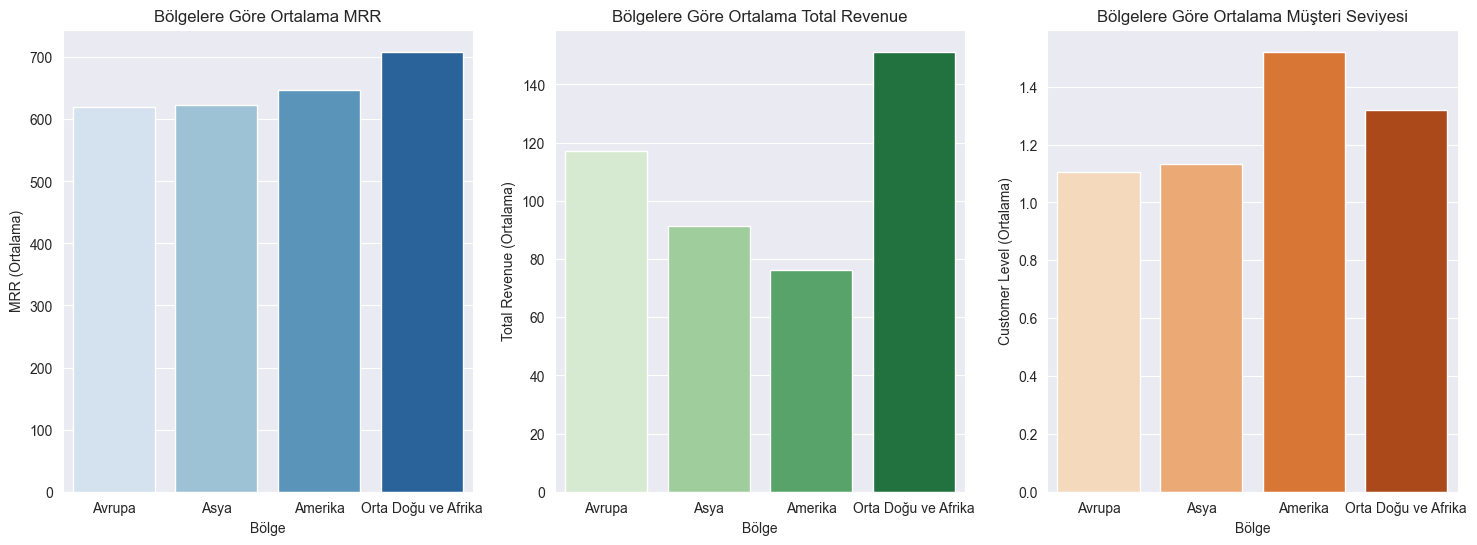

In [575]:
region_comparison = merged_df.groupby("converted_region").agg({
    "mrr": "mean",
    "total_revenue": "mean",
    "converted_customer_level": "mean",
    "birim_basi_kazanc": "mean"
}).reset_index()

region_labels = {
    0: "Avrupa",
    1: "Asya",
    2: "Amerika",
    3: "Orta Doğu ve Afrika"
}
region_comparison["Region"] = region_comparison["converted_region"].map(region_labels)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x="Region", y="mrr", data=region_comparison, ax=axes[0], palette="Blues")
axes[0].set_title("Bölgelere Göre Ortalama MRR")
axes[0].set_ylabel("MRR (Ortalama)")
axes[0].set_xlabel("Bölge")

sns.barplot(x="Region", y="total_revenue", data=region_comparison, ax=axes[1], palette="Greens")
axes[1].set_title("Bölgelere Göre Ortalama Total Revenue")
axes[1].set_ylabel("Total Revenue (Ortalama)")
axes[1].set_xlabel("Bölge")

sns.barplot(x="Region", y="converted_customer_level", data=region_comparison, ax=axes[2], palette="Oranges")
axes[2].set_title("Bölgelere Göre Ortalama Müşteri Seviyesi")
axes[2].set_ylabel("Customer Level (Ortalama)")
axes[2].set_xlabel("Bölge")

sns.barplot(x="Region", y="birim_basina_kazanc", data=region_comparison, ax=axes[2], palette="Oranges")
axes[2].set_title("Bölgelere Göre Ortalama Birim Başına Kazanç")
axes[2].set_ylabel("Birim başına kazanç")
axes[2].set_xlabel("Bölge")

plt.tight_layout()
plt.show()


 Bölgelere Göre MRR, Total Revenue ve Müşteri Seviyesi Analizi:
*  **Orta Doğu ve Afrika**, en yüksek **MRR** ve **toplam gelire** sahip. Bu bölgede büyük ölçekli müşteriler daha yaygın olabilir.
*  **Avrupa ve Amerika**, yüksek MRR seviyelerine sahip ancak toplam gelirde Orta Doğu ve Afrika’nın gerisinde kalıyor. Satış stratejileriyle gelir artırılabilir.
*  **Asya**, en düşük toplam gelire sahip. Asya pazarında müşteri başına düşen kazanç düşük olabilir. Stratejik fiyatlandırma ve müşteri ilişkileri geliştirme önerilebilir.
*  **Müşteri Seviyesi açısından**, **Amerika en büyük müşterilere sahip**, Orta Doğu ve Afrika ise ikinci sırada yer alıyor. Küçük ve orta ölçekli müşterileri büyütmeye yönelik stratejiler uygulanabilir.
*  **Asya ve Avrupa**, müşteri seviyesi açısından birbirine yakın ancak Avrupa’nın geliri daha yüksek. Avrupa’daki müşteriler, Asya’ya kıyasla daha fazla kazanç sağlıyor olabilir.


### Vertical Analizi

In [ ]:
vertical_comparison = merged_df.groupby("converted_vertical").agg({
    "mrr": "mean",
    "total_revenue": "mean",
    "converted_customer_level": "mean",
    "using_frequency": "mean",

}).reset_index()

vertical_labels = {
    0: "Teknoloji ve Dijital",
    1: "Finans ve Ticaret",
    2: "Ulaşım, Lojistik ve Seyahat",
    3: "Sağlık, Eğitim ve Medya",
    4: "Diğer"
}
vertical_comparison["Vertical"] = vertical_comparison["converted_vertical"].map(vertical_labels)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.barplot(x="Vertical", y="mrr", data=vertical_comparison, ax=axes[0, 0], palette="Blues")
axes[0, 0].set_title("İş Alanlarına Göre Ortalama MRR")
axes[0, 0].set_ylabel("MRR (Ortalama)")
axes[0, 0].set_xlabel("İş Alanı")
axes[0, 0].tick_params(axis='x', rotation=30)

sns.barplot(x="Vertical", y="total_revenue", data=vertical_comparison, ax=axes[0, 1], palette="Greens")
axes[0, 1].set_title("İş Alanlarına Göre Ortalama Total Revenue")
axes[0, 1].set_ylabel("Total Revenue (Ortalama)")
axes[0, 1].set_xlabel("İş Alanı")
axes[0, 1].tick_params(axis='x', rotation=30)

sns.barplot(x="Vertical", y="converted_customer_level", data=vertical_comparison, ax=axes[1, 0], palette="Oranges")
axes[1, 0].set_title("İş Alanlarına Göre Ortalama Müşteri Seviyesi")
axes[1, 0].set_ylabel("Customer Level (Ortalama)")
axes[1, 0].set_xlabel("İş Alanı")
axes[1, 0].tick_params(axis='x', rotation=30)

sns.barplot(x="Vertical", y="using_frequency", data=vertical_comparison, ax=axes[1, 1], palette="Purples")
axes[1, 1].set_title("İş Alanlarına Göre Ortalama Panel Kullanma sıklığı")
axes[1, 1].set_ylabel("Interaction Rate (Ortalama)")
axes[1, 1].set_xlabel("İş Alanı")
axes[1, 1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


 * **Ulaşım, Lojistik ve Seyahat** sektörü en yüksek MRR ve toplam gelire sahip. Bu sektör büyük ölçekli müşteriler barındırıyor.
 * **Teknoloji ve Dijital & Finans ve Ticaret** sektörleri istikrarlı ve yüksek gelir seviyesine sahip.
 * **Sağlık, Eğitim ve Medya** sektöründe müşteri seviyesi ve gelir diğer sektörlere göre düşük. Etkileşimi artırmaya yönelik stratejiler geliştirilebilir.


# Zamana bağlı kullanıcıların analizi

In [ ]:
merged_df['response_date'] = pd.to_datetime(merged_df['response_date'])

time_series_data = merged_df.groupby("response_date").agg({
    "recommend_score": "mean",
    "gain_score": "mean",
    "product_quality": "mean",
    "panel_usability": "mean",
    "mrr": "mean",
    "total_revenue": "mean",
    "interaction_rate": "mean"
}).reset_index()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.lineplot(x="response_date", y="recommend_score", data=time_series_data, ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Zamana Göre Recommend Score")
axes[0, 0].set_ylabel("Recommend Score (Ortalama)")
axes[0, 0].set_xlabel("Tarih")

sns.lineplot(x="response_date", y="gain_score", data=time_series_data, ax=axes[0, 1], color="green")
axes[0, 1].set_title("Zamana Göre Gain Score")
axes[0, 1].set_ylabel("Gain Score (Ortalama)")
axes[0, 1].set_xlabel("Tarih")

sns.lineplot(x="response_date", y="product_quality", data=time_series_data, ax=axes[0, 2], color="purple")
axes[0, 2].set_title("Zamana Göre Product Quality")
axes[0, 2].set_ylabel("Product Quality (Ortalama)")
axes[0, 2].set_xlabel("Tarih")

sns.lineplot(x="response_date", y="interaction_rate", data=time_series_data, ax=axes[1, 0], color="brown")
axes[1, 0].set_title("Zamana Göre Interaction Rate")
axes[1, 0].set_ylabel("Interaction Rate (Ortalama)")
axes[1, 0].set_xlabel("Tarih")

fig.delaxes(axes[1, 1])
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()


# 3. Genel Analiz ve Öneriler


# İyileştirilmesi Gereken Alanlar ve Nedenleri

## 1. Müşteri Koruma Sistemi İyileştirilmeli
**Çünkü:** Veriler 20-30 ay arası sürede kritik bir müşteri kaybı yaşandığını gösteriyor. Özellikle Küme 2'deki eski ve memnuniyetsiz müşteriler yüksek risk altında. %32'lik kayıp müşteri oranı rekabet gücünü ciddi şekilde tehdit ediyor. Uzun süreli müşteriler gelir istikrarı için hayati öneme sahipken, bu grup şu anda en düşük memnuniyet skorlarına sahip.

## 2. Destek Süreçleri Hızlandırılmalı
**Çünkü:** 29 günlük ortalama destek çözüm süresi sektör standartlarının çok üzerinde ve müşteri memnuniyetini doğrudan etkiliyor. Yüksek destek bileti sayısı, ürün/hizmet kalitesinde temel sorunların varlığına işaret ediyor. Hızlı destek, modern SaaS işletmelerinde rekabet avantajı sağlayan bir faktör.

## 3. Fiyatlandırma Stratejisi Yenilenmeli
**Çünkü:** 0.01 birim başı kazanç son derece düşük olup iş modelinin sürdürülebilirliğini tehlikeye atıyor. Değer tabanlı fiyatlandırma olmadan, sunulan hizmetin gerçek değeri müşterilere yansıtılamıyor. Enterprise segmentinin %47,5 olması ve yüksek destek maliyetleri, mevcut fiyatlandırma modelinin kârlılığı olumsuz etkilediğini gösteriyor.

## 4. Pazar Çeşitliliği Artırılmalı
**Çünkü:** Ulaşım sektörüne %71 oranında bağımlılık, sektörel bir kriz durumunda gelir akışında büyük risk oluşturuyor. Coğrafi olarak Avrupa (%46,1) ve Asya'ya (%32,6) odaklanılması, ABD pazarındaki büyük fırsatların kaçırılmasına neden oluyor.ABD pazarı şuanda en fazla Total Revenue'ya sahip pazar bu yüzden müşteri sayısı arttırılmalı. Çeşitlendirilmiş müşteri tabanı ekonomik dalgalanmalara karşı koruma sağlar.

## 5. Ürün Kalitesi Stabilize Edilmeli
**Çünkü:** Ürün kalitesi metriklerinin zaman zaman 0'a düşmesi, kritik kesintilerin ve teknik sorunların sıklığını gösteriyor. Memnuniyet ve tavsiye puanlarının dalgalı seyretmesi, kullanıcı deneyiminde tutarsızlığa işaret ediyor. Kararlı bir ürün performansı olmadan, müşteri sadakati oluşturmak imkansızdır. Zamana bağlı yaptığımız analizde de görüleceği gibi product rate zaman zaman çok büyük düşüşler yaşamış, o zamanlardaki yapılan değişikliklere dikkat edilmeli.

## 6. Organizasyonel Yapı Müşteri Odaklı Hale Getirilmeli
**Çünkü:** Veriler reaktif bir iş yönetimi modelini gösteriyor; proaktif iyileştirmeler yerine destek biletlerine dayalı bir sistem mevcut. Segment bazlı uzmanlaşmanın olmaması, farklı müşteri gruplarının kendine özgü ihtiyaçlarının karşılanamamasına yol açıyor. Müşteri odaklı bir organizasyonel yapı, müşteri deneyimini ve memnuniyetini doğrudan etkiler.

## 7. Veri Odaklı Karar Mekanizması Kurulmalı
**Çünkü:** Şirketin şu anda müşteri metriklerini proaktif olarak izleyen bir sistem kuramamış olduğu görülüyor. Müşteri sağlığını önceden tahmin eden bir skorlama modelinin olmaması, risklerin ancak müşteri kaybı gerçekleştikten sonra fark edilmesine yol açıyor. Veri odaklı yaklaşım, stratejik kararların zamanında ve doğru alınmasını sağlayacaktır.

Bu alanların iyileştirilmesi, şirketin sürdürülebilir büyüme yoluna girmesi, müşteri memnuniyetini artırması ve rekabet avantajı elde etmesi için kritik öneme sahiptir.


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




Şirketin finansal performansını iyileştirmek için MRR (Aylık Tekrarlayan Gelir) ve toplam geliri artıracak stratejik öneriler sunacağım. Mevcut analizlerden yola çıkarak, veriye dayalı çözümler öneriyorum.

## MRR ve Toplam Geliri Artırmak İçin Stratejik Öneriler

### 1. Segment Bazlı Fiyatlandırma Stratejisi Geliştirin
**Çünkü:** Birim başı kazanç tüm memnuniyet metriklerini olumlu etkiliyor ve mevcut fiyatlandırma modelinde birim başı kazanç çok düşük (0.01) seviyede. Ayrıca, veri MRR'nin 500-700 aralığında yoğunlaştığını gösteriyor.

**Öneriler:**
- Enterprise segmenti (%47,5) için değer odaklı premium paketler oluşturun
- Semi-Enterprise (%22) ve Long-tail (%30,4) müşteriler için ölçeklenebilir fiyat yapısı geliştirin
- Bölgesel faktörleri dikkate alarak fiyatlandırma yapın (analiz bölgesel faktörlerin gelir üzerinde güçlü etkisi olduğunu gösteriyor)

### 2. Müşteri Tutundurma Stratejilerini İyileştirin
**Çünkü:** Customer Age histogramı 0-20 ve 30-40 ay aralığında bimodal dağılım gösteriyor ve 20-30 ay arası bir tutundurma problemi olduğunu işaret ediyor. Ayrıca, kayıp müşteri oranı %32 gibi yüksek bir seviyede.

**Öneriler:**
- Cluster 2 (en düşük memnuniyet skoruna sahip en eski müşteriler) için acil kurtarma programları uygulayın
- 20-30 ay aralığındaki müşteriler için özel bağlılık programları geliştirin
- Müşteri yaşı arttıkça MRR düşse de toplam gelire pozitif etki yaptığından, uzun süreli müşterilere özel avantajlar sunun

### 3. Destek Süreçlerini Optimize Edin
**Çünkü:** Destek bileti çözüm süresi ortalama 29 gün gibi çok uzun ve analizler destek süresi uzadıkça memnuniyetin düştüğünü gösteriyor. Ayrıca, hata sayısı MRR'yi negatif etkiliyor.

**Öneriler:**
- Destek süreçlerini %30-50 hızlandıracak otomasyon araçları geliştirin
- Özellikle Cluster 1 (yeni müşteriler) için destek süreçlerini hızlandırın
- Enterprise segmenti için premium destek seçenekleri sunarak ek gelir kaynağı yaratın
- Self-servis çözüm merkezi oluşturarak tekrarlayan sorunları azaltın

### 4. Bölgesel Genişleme Stratejisi Uygulayın
**Çünkü:** Şirketin müşteri tabanı ağırlıklı olarak Avrupa (%46,1) ve Asya'da (%32,6) yoğunlaşırken, Amerika pazarı sadece %5,4'lük bir pay alıyor. Analizler bölgesel faktörlerin gelir üzerinde güçlü etki gösterdiğini belirtiyor.

**Öneriler:**
- Amerika pazarına özel büyüme stratejisi geliştirin
- Bölgesel ihtiyaçlara göre özelleştirilmiş hizmetler sunun
- En kârlı bölgeleri belirleyerek yatırımları bu alanlara yönlendirin

### 5. Ürün Kullanımını ve Kalitesini Artırın
**Çünkü:** Kullanım sıklığı düşük olarak rapor edilmiş ve özellikle Cluster 2 için ürün kalitesi skorları düşük. Ayrıca, zaman serisi analizinde ürün kalitesi kritik bir noktada 0'a düşmüş.

**Öneriler:**
- Kullanıcı arayüzünü iyileştirerek etkileşimi artırın
- Kritik ürün hatalarını öncelikli olarak giderin
- Yeni özellikler ekleyerek kullanım sıklığını artırın
- Ulaşım dikey segmentindeki (%71) baskınlığınızı korurken, yeni dikey sektörlere genişleyin

### 6. Müşteri Aktivasyon ve Upsell Programları Geliştirin
**Çünkü:** Cluster 1 (yeni müşteriler) düşük etkileşim gösteriyor ve genel olarak etkileşim oranı %10-25 bandında değişiyor. Ayrıca yeni müşterilerin birim başı kazancı daha yüksek.

**Öneriler:**
- Yeni müşteriler için kapsamlı onboarding programları oluşturun
- Mevcut müşterilere yönelik yukarı satış ve çapraz satış fırsatları geliştirin
- Kullanım artışına bağlı ödül mekanizmaları ile etkileşimi teşvik edin
- Özellikle Cluster 0 (değerli ancak riskli müşteriler) için özel VIP programlar sunun

### 7. Veri Odaklı Erken Uyarı Sistemi Kurun
**Çünkü:** MRR ve toplam gelir yüksek dalgalanmalar gösteriyor ve bu durum finansal planlama açısından risk yaratıyor.

**Öneriler:**
- Müşteri davranışını izleyen ve kayıp riskini önceden tespit eden analitik araçlar geliştirin
- Proaktif müdahale protokolleri oluşturun
- Segment bazlı metrik takibi ile performans dalgalanmalarını kontrol edin
- Özellikle yüksek gelirli müşterilerde (Cluster 0) memnuniyet düşüşlerini anlık takip edin

Bu öneriler, mevcut müşteri analizlerine dayanarak MRR ve toplam geliri artırmak için kapsamlı bir yol haritası sunmaktadır. Özellikle segment bazlı yaklaşım, destek süreçlerinin iyileştirilmesi ve kullanıcı deneyiminin geliştirilmesi üzerine odaklanarak, hem kısa vadede gelir artışı hem de uzun vadede sürdürülebilir büyüme sağlanabilir.



-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Müşteri Sadakatini Artırmak İçin Stratejik Öneriler

### 1. Kişiselleştirilmiş Müşteri Başarı Programı Oluşturun
*Çünkü:* Analizler gösteriyor ki uzun süreli müşteriler (Cluster 2) en düşük memnuniyet skorlarına sahip ve daha fazla hata bildiriyor. Ayrıca segmentler arasında (Enterprise %47,5, Long-tail %30,4, Semi-Enterprise %22) farklı ihtiyaçlar mevcut.

*Öneriler:*
•⁠  ⁠Her müşteri segmenti için özel müşteri başarı yöneticileri atayın
•⁠  ⁠Enterprise müşterilerine düzenli strateji toplantıları sunun
•⁠  ⁠Müşteri yolculuk haritası çıkararak kritik temas noktalarını belirleyin
•⁠  ⁠Büyük müşterileriniz için üst düzey yönetici sponsorluğu programı başlatın

### 2. Destek Deneyimini Tamamen Yeniden Tasarlayın
*Çünkü:* Ortalama destek çözüm süresi 29 gün gibi çok uzun ve destek süresi uzadıkça müşteri memnuniyeti düşüyor. Ayrıca uzun süreli müşterilerin destek süreçleri daha uzun sürüyor.

*Öneriler:*
•⁠  ⁠Destek taleplerinde önceliklendirme sistemi geliştirin
•⁠  ⁠24 saat içinde ilk yanıt garantisi verin
•⁠  ⁠Müşteri segmentine göre farklılaştırılmış SLA'lar belirleyin
•⁠  ⁠Self-servis destek portalı oluşturarak sık sorulan sorunları hızlıca çözün
•⁠  ⁠Destek ekibinizi müşteri segmentlerine göre uzmanlaştırın

### 3. Proaktif İletişim ve Erken Uyarı Sistemi Kurun
*Çünkü:* Öneri puanı dalgalı bir seyir izliyor ve müşteri memnuniyeti değişken. Ayrıca bimodal customer age dağılımı (0-20 ve 30-40 ay) 20-30 ay arasında bir sadakat problemi olduğunu gösteriyor.

*Öneriler:*
•⁠  ⁠Kritik dönemlerde (örn. 18-24 ay) özel müşteri teması programı başlatın
•⁠  ⁠Platform kullanımında düşüş yaşayan müşteriler için otomatik uyarı sistemi oluşturun
•⁠  ⁠Planlanan bakım ve güncellemeler için önceden bilgilendirme yapın
•⁠  ⁠Düzenli "sağlık kontrolü" görüşmeleri ile sorunları erkenden tespit edin
•⁠  ⁠Müşterilerinizin başarı hikayelerini paylaşın ve topluluk hissi yaratın

### 4. Çok Katmanlı Sadakat Programı Geliştirin
*Çünkü:* Analizler, uzun süreli müşterilerin toplam gelire pozitif etki yaptığını gösteriyor, ancak müşteri yaşı arttıkça MRR düşüyor. Etkileşim oranı da sadece %10-25 bandında değişiyor.

*Öneriler:*
•Kullanım süresi ve hacmine bağlı ödül sistemi oluşturun
•Uzun süreli müşterilere özel erken erişim ve beta test imkanları sunun
•Müşteri referans programı ile yeni müşteri getirenleri ödüllendirin
•Her müşteri segmenti için farklılaştırılmış sadakat programları tasarlayın
•Yıllık sözleşmelere geçişi teşvik eden indirimler sunun

### 5. Ürün Kalitesini ve Kullanılabilirliği İyileştirin
*Çünkü:* Zaman serisi analizinde ürün kalitesi kritik bir noktada 0'a düşmüş ve Cluster 2 için ürün kalitesi skorları düşük. Kullanım sıklığı da genel olarak düşük rapor edilmiş.

*Öneriler:*
•Müşteri geri bildirimlerini önceliklendiren ürün geliştirme süreci oluşturun
•Kullanıcı deneyimi araştırmaları yaparak arayüz problemlerini tespit edin
•Özellik kullanım analizleri ile en değerli özellikleri belirleyin ve geliştirin
•Müşteri danışma kurulu oluşturarak ürün yol haritasına müşterileri dahil edin
•Kritik ürün hatalarını hızla çözmek için "hata sıfır" programı başlatın

### 6. Eğitim ve Yetkinlik Programları Sunun
*Çünkü:* Özellikle Cluster 2 (orta seviye kullanıcılar) olumlu görüş bildiriyor ancak düşük kullanım sıklığına sahip ve analizler kullanım sıklığının düşük olduğunu gösteriyor.

*Öneriler:*
•Segment bazlı eğitim programları oluşturun
•Düzenli webinarlar ve kullanım ipuçları paylaşın
•Online eğitim platformu ile self-servis öğrenme imkanı sağlayın
•İleri seviye kullanıcılar için sertifikasyon programları başlatın
•Müşteri başarı hikayeleri ile ilham verici içerikler paylaşın

### 7. Değer Temelli İlişki Geliştirin
*Çünkü:* Birim başı kazanç tüm metrikleri olumlu etkiliyor ancak mevcut değeri çok düşük (0.01) ve fiyat-değer dengesi müşteri segmentlerine göre optimize edilmeli.

*Öneriler:*
•ROI odaklı raporlama ile müşterilere sağladığınız değeri somut gösterin
•İş sonuçlarına odaklanan düzenli değerlendirme toplantıları yapın
•Sektör kıyaslamaları ve başarı ölçütleri paylaşarak değer algısını güçlendirin
•Uzun vadeli stratejik ortaklık yaklaşımı ile geçici fiyat avantajları yerine değer yaratmaya odaklanın
•Müşteri iş süreçlerine daha fazla entegrasyon sağlayarak vazgeçilmez olun

Tüm bu öneriler, veri analizinden elde edilen içgörülere dayanarak müşteri sadakatini artırmayı hedeflemektedir. Özellikle destek süreçlerinin iyileştirilmesi, proaktif iletişim, kişiselleştirilmiş deneyim ve ürün kalitesine odaklanmak, müşteri memnuniyetini ve bağlılığını önemli ölçüde artırabilir.
